<a href="https://colab.research.google.com/github/AndrzejOlejniczak/PORTFOLIO/blob/main/BullionPredict_01_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BullionPredict: Time series forecasting for gold price.
## PART ONE
This Project is based on a milestone project by D. Bourke. You can access it taking this Udemy course:
https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/.
<p> I chose to use gold price data instead of Bitcoin data. I also used scikeras package to tune hyperparameters.

In [ ]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## 1. Get and prepare the data

### 1.1. Install and import yfinance

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf

### 1.2. Create the dataset

In [ ]:
df = yf.download('GC=F', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
GLD_object = yf.Ticker('GC=F')

In [ ]:
GLD_object.fast_info['currency']

yfinance: Note: 'Ticker.info' dict is now fixed & improved, 'fast_info' is no longer faster


'USD'

In [ ]:
df

Open         High          Low        Close  Volume
Date                                                                  
2000-08-30   273.899994   273.899994   273.899994   273.899994       0
2000-08-31   274.799988   278.299988   274.799988   278.299988       0
2000-09-01   277.000000   277.000000   277.000000   277.000000       0
2000-09-05   275.799988   275.799988   275.799988   275.799988       2
2000-09-06   274.200012   274.200012   274.200012   274.200012       0
...                 ...          ...          ...          ...     ...
2023-05-15  2013.800049  2018.000000  2013.800049  2018.000000       3
2023-05-16  1988.400024  1988.400024  1988.400024  1988.400024      49
2023-05-17  1983.599976  1983.599976  1980.699951  1980.699951      13
2023-05-18  1956.500000  1956.800049  1956.500000  1956.500000      23
2023-05-19  1960.000000  1978.699951  1960.000000  1978.699951      23

[5702 rows x 5 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5702 entries, 2000-08-30 to 2023-05-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5702 non-null   float64
 1   High    5702 non-null   float64
 2   Low     5702 non-null   float64
 3   Close   5702 non-null   float64
 4   Volume  5702 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 267.3 KB


In [ ]:
gold_close = df.Close

In [ ]:
# Drop the timestamp information
gold_close.index = gold_close.index.date

In [ ]:
gold_close.index.set_names('Date', inplace=True)

In [ ]:
gold_close.index

Index([2000-08-30, 2000-08-31, 2000-09-01, 2000-09-05, 2000-09-06, 2000-09-07,
       2000-09-08, 2000-09-11, 2000-09-12, 2000-09-13,
       ...
       2023-05-08, 2023-05-09, 2023-05-10, 2023-05-11, 2023-05-12, 2023-05-15,
       2023-05-16, 2023-05-17, 2023-05-18, 2023-05-19],
      dtype='object', name='Date', length=5702)

In [ ]:
gold_close_df = gold_close.to_frame().dropna()

In [ ]:
gold_volume = df.Volume

In [ ]:
# Drop the timestamp information
gold_volume.index = gold_volume.index.date

In [ ]:
gold_volume.index.set_names('Date', inplace=True)

In [ ]:
gold_volume_df = gold_volume.to_frame().dropna()


In [ ]:
gold_volume_df.index = pd.to_datetime(gold_volume_df.index)

In [ ]:
gold_volume_df.index = pd.MultiIndex.from_arrays([gold_volume_df.index.strftime('%Y-%m'), gold_volume_df.index.date], names=('YearMonth', 'Date'))

In [ ]:
import matplotlib

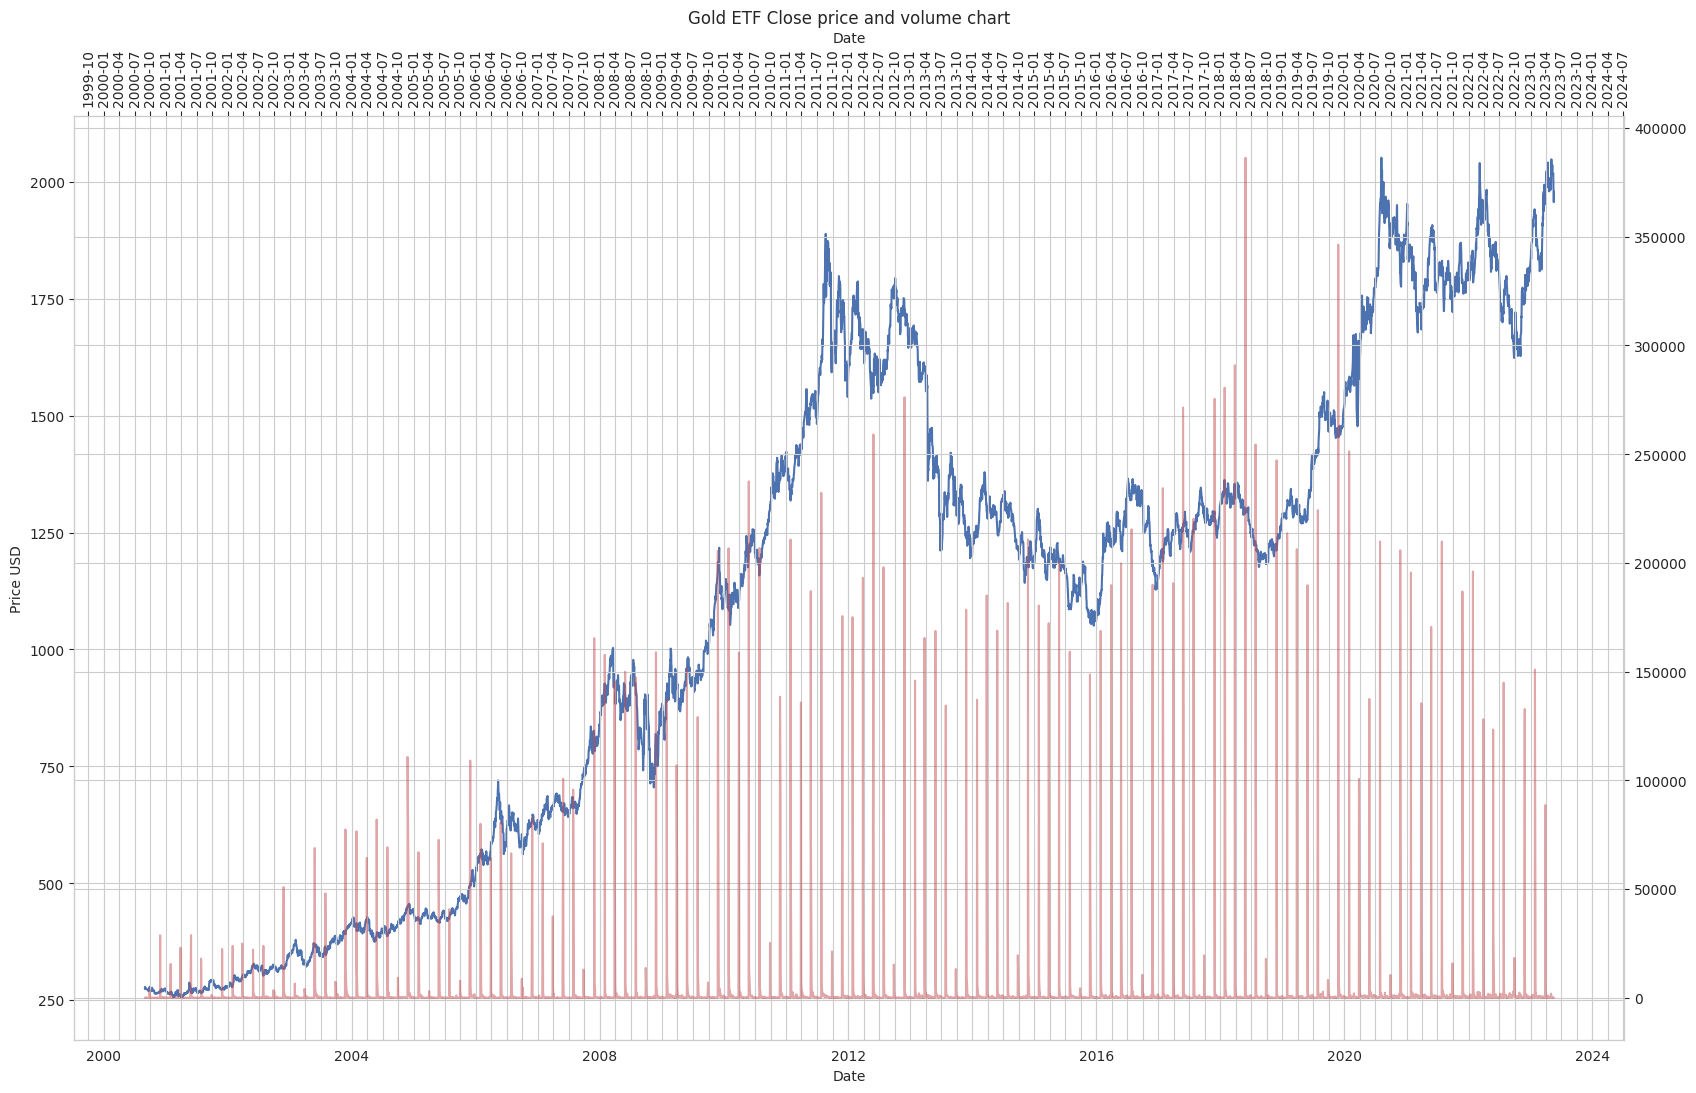

In [ ]:
sns.set_style('whitegrid')
sns.set_palette('deep')
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
plt.title('Gold ETF Close price and volume chart')
sns.lineplot(x='Date', y='Close', data=gold_close_df.reset_index(), ax=ax, color='b')
ax.set_ylabel('Price USD')

ax2 = ax.twinx().twiny()

ax2locator = matplotlib.dates.MonthLocator(bymonth=[1, 4, 7,10])
ax2formatter = matplotlib.dates.DateFormatter(fmt='%Y-%m')


ax2.xaxis.set_major_locator(ax2locator)
ax2.xaxis.set_major_formatter(ax2formatter)
ax2.tick_params(axis='x', which='major', labelrotation=90)

sns.lineplot(x='Date', y='Volume', data=gold_volume_df.reset_index(), ax=ax2, color='r', alpha=0.5)
ax2.set_ylabel('Volume USD')

plt.show()

In [ ]:
# Create arrays of the data
price = gold_close_df['Close'].to_numpy()
volume = gold_volume_df['Volume'].to_numpy()

In [ ]:
len(gold_close_df.index) == len(gold_volume_df.index)

True

In [ ]:
timesteps = gold_close_df.index.to_numpy()

In [ ]:
# Create combined array of price and volume values
price_volume = np.stack((price, volume), axis=-1)

### 1.3. Split the dataset to train and test datasets

In [ ]:
split_size = int(0.8 * len(price))
split_size

4561

#### Split just price and timesteps

In [ ]:
# Create train splits
X_train, y_train = timesteps[:split_size], price[:split_size]

# Create test splits
X_test, y_test = timesteps[split_size:], price[split_size:]

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(4561, 4561, 1141, 1141)

#### Split price/volume pairs

In [ ]:
y_pv_train, y_pv_test = price_volume[:split_size], price_volume[split_size:]

In [ ]:
len(y_pv_train), len(y_pv_test)

(4561, 1141)

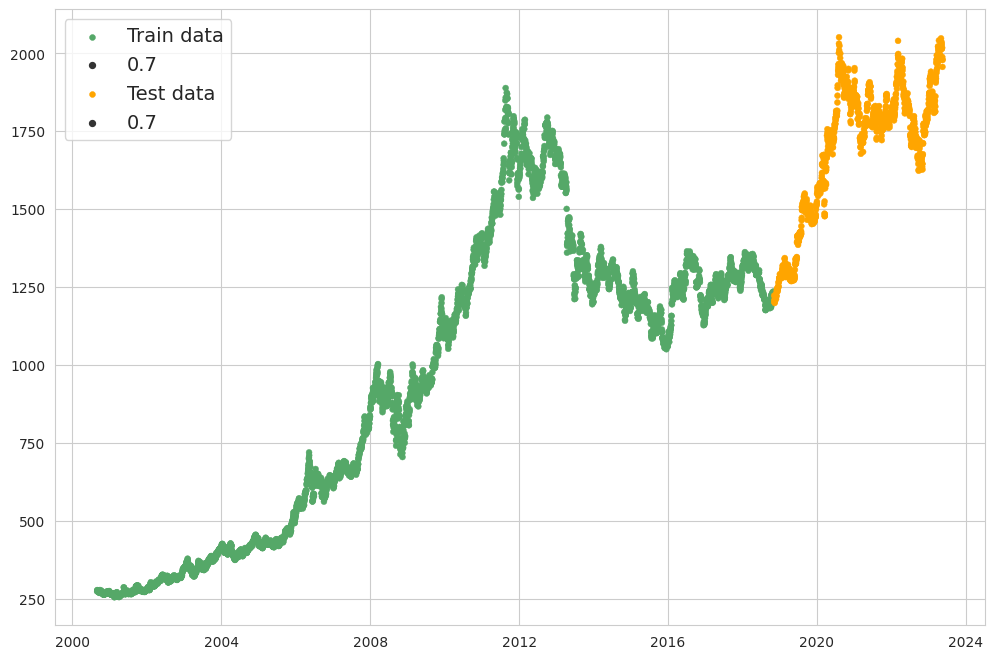

In [ ]:
# Check the data split on a plot
sns.set_style('whitegrid')
sns.set_palette('deep')
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.scatterplot(x=X_train, y=y_train, color='g', ax=ax, label='Train data', edgecolor=None, size=.7)
sns.scatterplot(x=X_test, y=y_test, color='orange', ax=ax, label='Test data', edgecolor=None, size=.7)
plt.legend(fontsize=14)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.dates import date2num

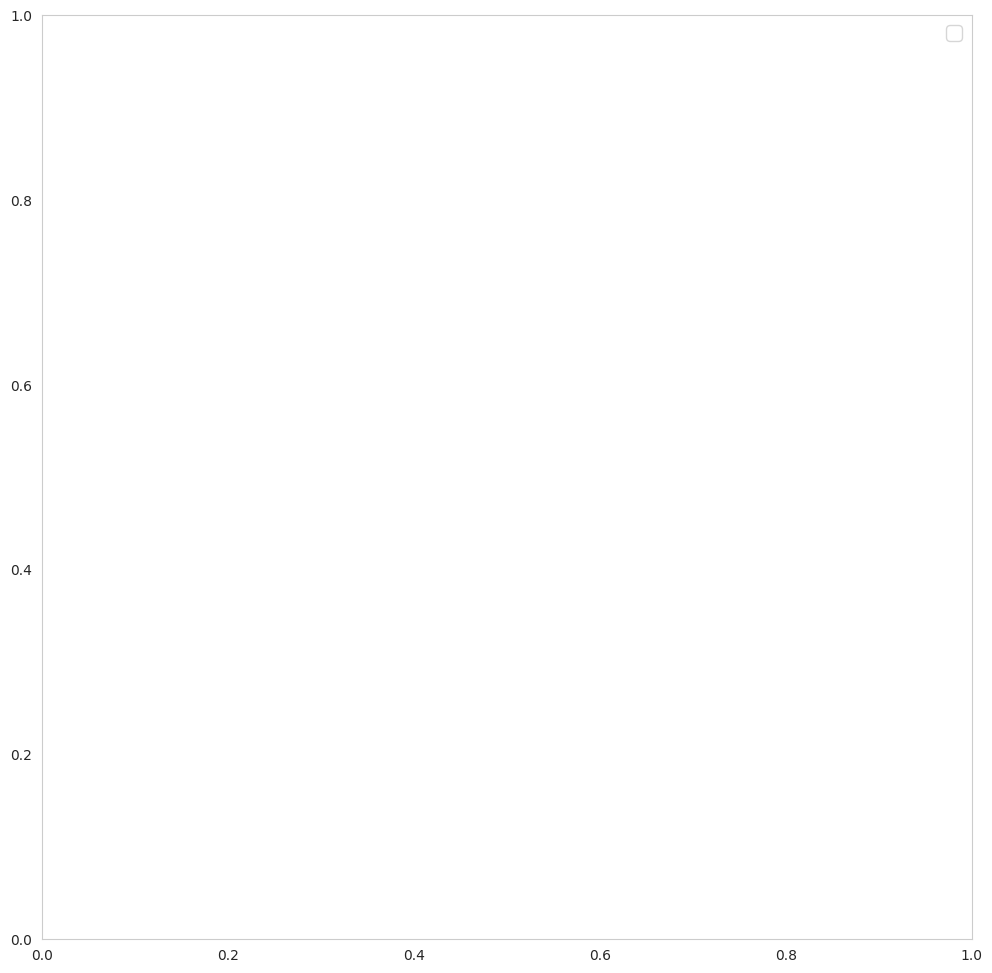

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(12,12))

ax = Axes3D(fig, proj_type='ortho', azim=-20)

ax.scatter(xs=y_pv_train[:,0], ys=y_pv_train[:,1] , zs=date2num(X_train), color='g', label='Train data', s=24)
ax.scatter(xs=y_pv_test[:,0], ys=y_pv_test[:,1] , zs=date2num(X_test), color='orange', label='Test data', s=24)

ax.set_xlabel('Price')
ax.set_ylabel('Volume')
ax.set_zlabel('Time')
plt.legend(fontsize=14)
plt.show()

In [ ]:
matplotlib.__version__

'3.7.1'

**I am not sure if the volume data for gold (commodity) transactions is the best second feature for the model. On the 3D scatter plot volume data looks like random noise added to the plot.**

The are some possible additional indices to be included in the model:
1. Gold ETF instrument volume data available at yfinance ('GLD' ticker)
2. US Dollar/USDX - Index - Cash (DX-Y.NYB).

### **HELPER FUNCTION**

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  '''
  Plots timesteps against values

  Parameters
  ----------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : index of timesteps series
  end : index of timesteps series
  label: label to show on plot values
  '''

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel(f'Value')
  if label is not None:
    plt.legend(fontsize=14)
  plt.grid(True)

In [ ]:
X_train.shape, y_train.shape

((4561,), (4561,))

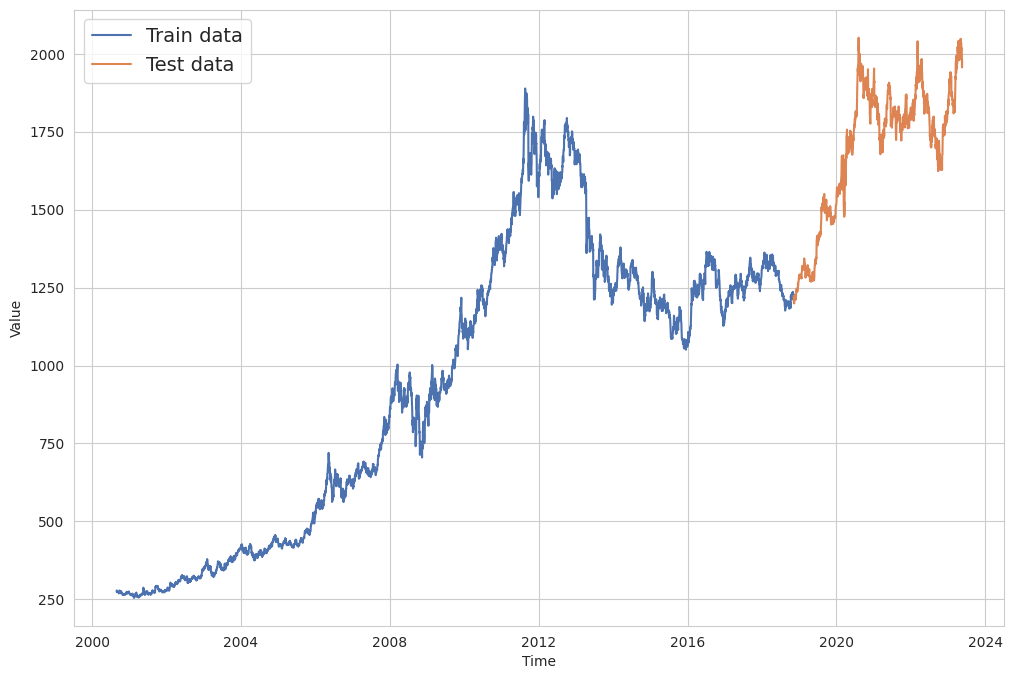

In [ ]:
plt.figure(figsize=(12,8))
plot_time_series(timesteps=X_train, values=y_train, format='-', label='Train data')
plot_time_series(timesteps=X_test, values=y_test, format='-', label='Test data')

### 1.4. Window the data

In [ ]:
# Setup global variables
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
y_test.shape

(1141,)

In [ ]:
tf.expand_dims(y_test, axis=0)

<tf.Tensor: shape=(1, 1141), dtype=float64, numpy=
array([[1222.90002441, 1206.40002441, 1201.30004883, ..., 1980.69995117,
        1956.5       , 1978.69995117]])>

In [ ]:
# Create function to label windowed data
def create_windows_and_labels(x, horizon=HORIZON, window=WINDOW_SIZE):
  '''
  Creates labels for windowed time series dataset
  '''
  window_plus_horizon = int(horizon + window)
  list_for_tuples = []
  for it, element in enumerate(x[ :-window_plus_horizon]):
    window_it = x[it:int(it+window)]
    horizon_it = x[int(it+window):int(it+window_plus_horizon)]
    list_for_tuples.append((window_it, horizon_it))
  return list_for_tuples

In [ ]:
data = create_windows_and_labels(y_train, horizon=3, window=17)

In [ ]:
data[:3]

[(array([273.8999939 , 278.29998779, 277.        , 275.79998779,
         274.20001221, 274.        , 273.29998779, 273.1000061 ,
         272.8999939 , 272.79998779, 272.3999939 , 272.29998779,
         271.3999939 , 271.8999939 , 269.        , 270.29998779,
         271.79998779]),
  array([274.1000061, 273.8999939, 278.3999939])),
 (array([278.29998779, 277.        , 275.79998779, 274.20001221,
         274.        , 273.29998779, 273.1000061 , 272.8999939 ,
         272.79998779, 272.3999939 , 272.29998779, 271.3999939 ,
         271.8999939 , 269.        , 270.29998779, 271.79998779,
         274.1000061 ]),
  array([273.8999939, 278.3999939, 275.6000061])),
 (array([277.        , 275.79998779, 274.20001221, 274.        ,
         273.29998779, 273.1000061 , 272.8999939 , 272.79998779,
         272.3999939 , 272.29998779, 271.3999939 , 271.8999939 ,
         269.        , 270.29998779, 271.79998779, 274.1000061 ,
         273.8999939 ]),
  array([278.3999939, 275.6000061, 273.6000

In [ ]:
y_train[:60]

array([273.8999939 , 278.29998779, 277.        , 275.79998779,
       274.20001221, 274.        , 273.29998779, 273.1000061 ,
       272.8999939 , 272.79998779, 272.3999939 , 272.29998779,
       271.3999939 , 271.8999939 , 269.        , 270.29998779,
       271.79998779, 274.1000061 , 273.8999939 , 278.3999939 ,
       275.6000061 , 273.6000061 , 273.1000061 , 271.6000061 ,
       270.29998779, 270.6000061 , 269.29998779, 270.1000061 ,
       272.3999939 , 270.5       , 276.3999939 , 272.3999939 ,
       271.5       , 271.1000061 , 270.29998779, 270.1000061 ,
       271.20001221, 270.1000061 , 270.1000061 , 266.20001221,
       264.8999939 , 264.3999939 , 264.29998779, 264.8999939 ,
       263.8999939 , 264.3999939 , 264.6000061 , 264.5       ,
       264.29998779, 265.        , 265.79998779, 264.5       ,
       264.29998779, 264.8999939 , 265.1000061 , 265.79998779,
       265.70001221, 266.29998779, 265.70001221, 266.29998779])

**It looks ok, but there is a better way - using array vectorization instead of for loop**

Better way is to create he function that will:

1. Create a window step
2. Use NumPy indexing to create 2D array of multiple window steps.
3. Inject the (time) series data into the 2D array from 2 to create feature dataset.
4. Will use label_the_window function to create additional target dataset of horizon data for the (time) series.

This approach is based on this article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [ ]:
def label_the_window(x, horizon=HORIZON):
  '''
  Create label for windowed data
  '''
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
test_window, test_label = label_the_window(tf.expand_dims(tf.range(8), axis=0), horizon=3)

In [ ]:
test_window, test_label

(<tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[0, 1, 2, 3, 4]], dtype=int32)>,
 <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[5, 6, 7]], dtype=int32)>)

In [ ]:
def make_windows(x, window=WINDOW_SIZE, horizon=HORIZON):
  '''
  Turns 1D array into 2D array of size (N, window+horizon), where N is equal to the 1D arrays lenghth minus window.
  '''
  # 1. Create a window array
  window_step =  np.expand_dims(np.arange(window + horizon), axis=0)

  # 2. Create a 2D array of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window+horizon)), axis=0).T

  print(f'Window indexes:\n {window_indexes, window_indexes.shape}')

  # 3. Index on the target  array with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Label the wondows

  windows, labels = label_the_window(windowed_array, horizon=horizon)
  return windows, labels




In [ ]:
price.shape

(5702,)

In [ ]:
price_windows, price_labels = make_windows(price, window=WINDOW_SIZE , horizon=HORIZON)

Window indexes:
 (array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [5691, 5692, 5693, ..., 5696, 5697, 5698],
       [5692, 5693, 5694, ..., 5697, 5698, 5699],
       [5693, 5694, 5695, ..., 5698, 5699, 5700]]), (5694, 8))


In [ ]:
len(price_windows), len(price_labels)

(5694, 5694)

In [ ]:
# Inspect created dataset
for i in range(3):
  print(f'Window {price_windows[i]} -> Label: {price_labels[i]}')

Window [273.8999939  278.29998779 277.         275.79998779 274.20001221
 274.         273.29998779] -> Label: [273.1000061]
Window [278.29998779 277.         275.79998779 274.20001221 274.
 273.29998779 273.1000061 ] -> Label: [272.8999939]
Window [277.         275.79998779 274.20001221 274.         273.29998779
 273.1000061  272.8999939 ] -> Label: [272.79998779]


**Such functionality is also implemented in tensorflow: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array**

### 1.5. Split windowed data

#### **HELPER FUNCTION**

In [ ]:
def make_train_test_splits(features, labels, test_split=0.2):

  if len(labels) == len(features):
    split_size = int(len(features) * (1-test_split))
    train_features = features[:split_size]
    train_labels = labels[:split_size]
    test_features = features[split_size:]
    test_labels = labels[split_size:]
    return train_features, test_features, train_labels, test_labels
  else:
    print('Feature and label lenghths do not match!')
    print(f'Feature array length: {len(features)}. Label array length: {len(labels)}')

In [ ]:
# Create the splits
train_price_feats, test_price_feats, train_price_labels, test_price_labels = make_train_test_splits(price_windows, price_labels)

In [ ]:
len(train_price_feats), len(test_price_feats), len(train_price_labels), len(test_price_labels)

(4555, 1139, 4555, 1139)

In [ ]:
for element in zip(train_price_feats[:3, :], train_price_labels[:3]):
  print(element)

(array([273.8999939 , 278.29998779, 277.        , 275.79998779,
       274.20001221, 274.        , 273.29998779]), array([273.1000061]))
(array([278.29998779, 277.        , 275.79998779, 274.20001221,
       274.        , 273.29998779, 273.1000061 ]), array([272.8999939]))
(array([277.        , 275.79998779, 274.20001221, 274.        ,
       273.29998779, 273.1000061 , 272.8999939 ]), array([272.79998779]))


In [ ]:
for element in zip(test_price_feats[:3, :], test_price_labels[:3]):
  print(element)

(array([1212.30004883, 1236.        , 1230.90002441, 1229.80004883,
       1223.80004883, 1226.19995117, 1222.90002441]), array([1206.40002441]))
(array([1236.        , 1230.90002441, 1229.80004883, 1223.80004883,
       1226.19995117, 1222.90002441, 1206.40002441]), array([1201.30004883]))
(array([1230.90002441, 1229.80004883, 1223.80004883, 1226.19995117,
       1222.90002441, 1206.40002441, 1201.30004883]), array([1199.19995117]))


## 2. Modelling experiments

### 2.1. Overview

Terms' definitions:

**horizon** - number of timesteps into the futire we are going to predict

**window** - number of timesteps used to predict horizon

0. Naive model (baseline) *horizon=1, window=7*
1. Dense model *horizon=1, window=7*
2. Naive model *horizon=1, window=30*
3. Naive model *horizon=1, window=30*
4. Conv1D
5. LSTM
6. Naive model with multivariate data
7. N-BEATS algorithm
8. Ensamble model
9. Future prediction model
10. ??

### 2.2. Evaluation metrics

* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* (s)MAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

#### **MASE for non-seasonal data**

$q_{j} = \frac{\displaystyle e_{j}}     {\displaystyle\frac{1}{T-1}\sum_{t=2}^T |y_{t}-y_{t-1}|}$

#### **MASE for seasonal data**

$q_{j} = \frac{\displaystyle e_{j}}
    {\displaystyle\frac{1}{T-m}\sum_{t=m+1}^T |y_{t}-y_{t-m}|}$

In [ ]:
# Create MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  '''
  Implement MASE assuming no seasonality of the data
  '''
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive

In [ ]:
# Implement a function reaturning a dictionary with all the above metrics
def produce_metrics(y_true, y_pred):
  # Mean absolute error
  mae = tf.reduce_mean(tf.abs(y_pred-y_true))

  # Mean absolute error of naive forecast no seasonality
  mae_naive = tf.reduce_mean(tf.abs(y_true[:-1] - y_true[1:]))

  # Mean squared error
  mse = tf.reduce_mean((y_pred-y_true)**2)

  # Root mean squared error
  rmse = tf.math.sqrt(tf.reduce_mean((y_pred-y_true)**2))

  # Mean absolute percentage error
  mape = tf.reduce_mean((tf.abs((y_pred - y_true) / y_true)*100))

  # Symmetric mean absolute percentage error
  smape = tf.reduce_mean(200*(tf.abs(y_pred - y_true)/(y_true + y_pred)))

  # Mean absolute scaled error
  mase = mae / mae_naive

  # Return dictionary

  return {
      'mae': mae.numpy(),
      'mse': mse.numpy(),
      'rmse': rmse.numpy(),
      'mape': mape.numpy(),
      'smape': smape.numpy(),
      'mase': mase.numpy()
  }


In [ ]:
def produce_metrics_v2(y_true, y_pred):
  # Cast input data to tf.float32
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {
      'mae': mae.numpy(),
      'mse': mse.numpy(),
      'rmse': rmse.numpy(),
      'mape': mape.numpy(),
      'mase': mase.numpy()
  }


## 3. Model 0: Naive forecast (baseline)

The formula is:

$$\hat{y}_{t} = y_{t-1}$$

...so the prediction for the horizon of one is equal to the last observation.

### 3.1. Build :D the model

In [ ]:
# Create the forecast
naive_forecast = y_test[:-1]

### 3.2. Evaluate the model

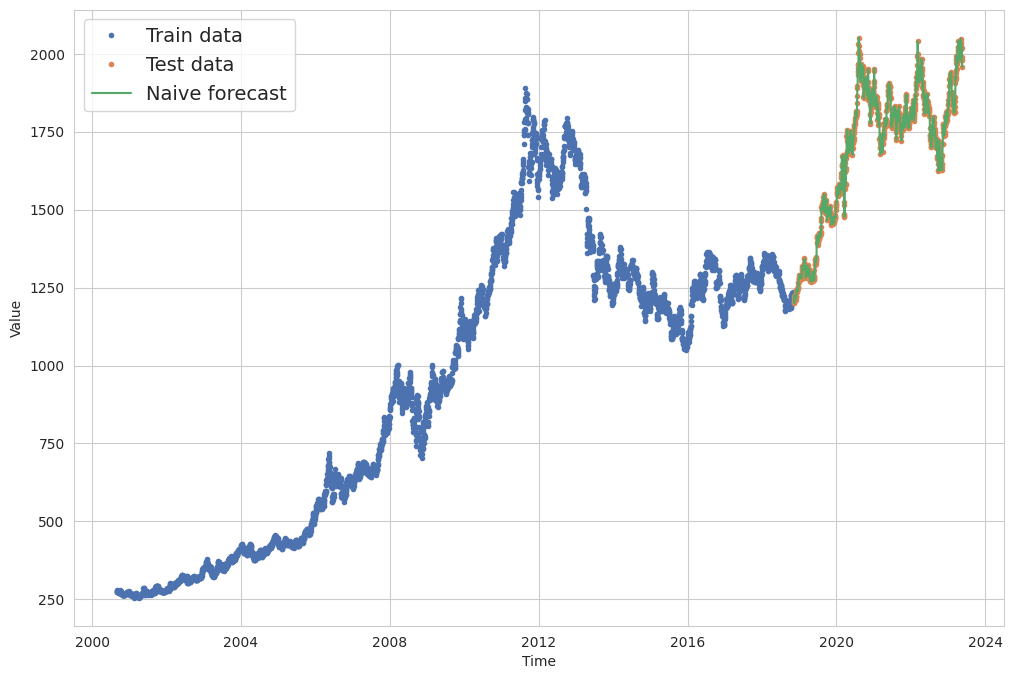

In [ ]:
plt.figure(figsize=(12, 8))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast')

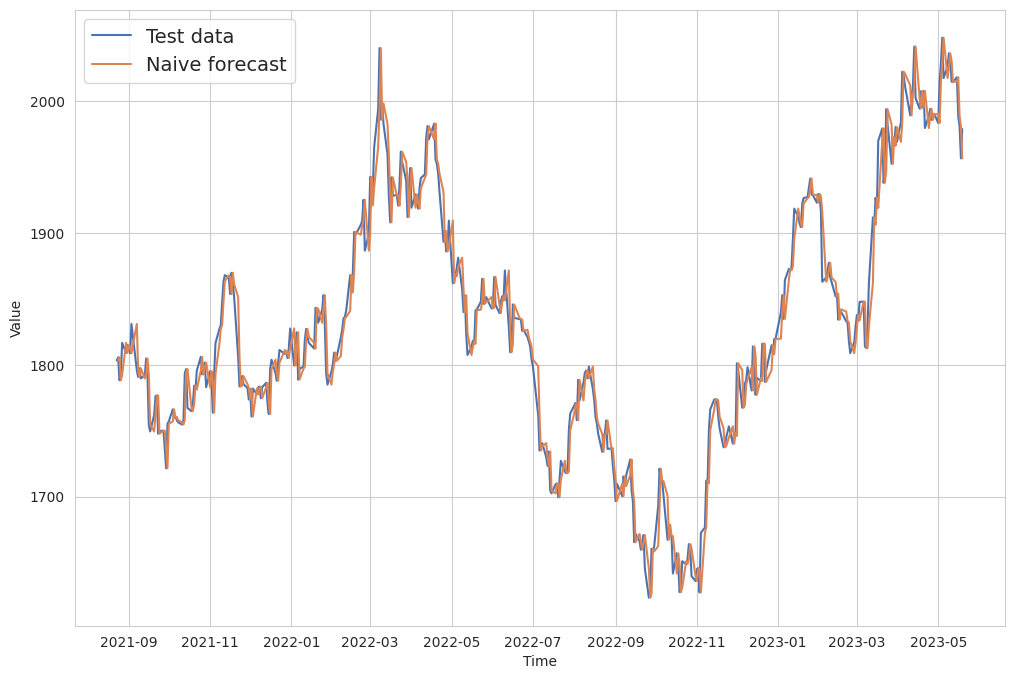

In [ ]:
plt.figure(figsize=(12, 8))
plot_time_series(timesteps=X_test, values=y_test, start=700, format='-', label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=700, format='-', label='Naive forecast')

In [ ]:
produce_metrics_v2(y_test[1:], naive_forecast)

{'mae': 12.263685,
 'mse': 309.2431,
 'rmse': 17.585308,
 'mape': 0.71118677,
 'mase': 1.0003034}

In [ ]:
naive_result = produce_metrics(y_test[1:], naive_forecast)

## 4. Model 1: Dense model
#### WINDOW_SIZE = 7, HORIZON = 1

### 4.1. Create checkpoint callback for experiments

In [ ]:
import os

def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### 4.2. Create hyperparameter tuning environment

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create hyperparameter grid
dense_layer_n_units = [16, 32, 64, 128, 256]
learning_rates = [0.1, 0.001, 0.0001, 0.00001]
batch_sizes = [16, 32, 64, 128, 256]
epochs = [25, 50, 75, 100]

grid = dict(
    n_units = dense_layer_n_units,
    lr = learning_rates,
    batch_size = batch_sizes,
    epochs = epochs
)

In [ ]:
tf.__version__

'2.12.0'

### 4.3. Build the model

scikeras implementation thanks to: https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#### 4.3.1. Explore the possibilities: use SciKeras for hyperparameter tuning

In [ ]:
INPUT_SHAPE = train_price_feats.shape[1]

In [ ]:
OUTPUT_SHAPE = train_price_labels.shape[1]
OUTPUT_SHAPE

1

In [ ]:
def create_model(learning_rate=0.001, n_units=128, activation='relu'):
  model = Sequential()
  model.add(Dense(n_units, input_shape=(INPUT_SHAPE,), activation=activation))
  model.add(Dense(OUTPUT_SHAPE, activation='linear'))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=['mse', 'mape'])
  return model

In [ ]:
model = KerasRegressor(build_fn=create_model, verbose=0, learning_rate=0.001, activation='relu', n_units=128)

In [ ]:
params = {'activation': ["relu", "tanh", 'elu', 'sigmoid' ],
          'batch_size': [16, 32, 64],
          'n_units': [32, 64, 128, 256, 1024],
          'epochs': [50, 100],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [ ]:
from sklearn.metrics import mean_absolute_error
random_search = RandomizedSearchCV(model,
                                   param_distributions = params,
                                   cv = KFold(3),
                                   n_iter=30,
                                   n_jobs=-1,
                                   scoring='neg_mean_squared_error',
                                   return_train_score=True,
                                   error_score='raise')

In [ ]:
random_search_results = random_search.fit(train_price_feats, train_price_labels)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


In [ ]:
random_search_results.best_estimator_

KerasRegressor(
	model=None
	build_fn=<function create_model at 0x7f0cd04eba30>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	learning_rate=0.0001
	activation=elu
	n_units=256
)

In [ ]:
random_search_results.cv_results_

{'mean_fit_time': array([195.88534482, 195.32289378,  33.06283593,  36.51197338,
         94.51599987, 188.052864  ,  48.56237706, 103.92053334,
         22.86235778,  45.32772398, 123.65914488,  29.678931  ,
         57.43602236,  43.56357551,  39.83935054,  16.79857429,
        179.33167815, 183.77594503,  40.1338075 , 173.90941771,
         95.49608779,  55.5084242 ,  21.06946023,  19.16729188,
        142.6117123 ,  45.35451206,  57.60741623,  84.37884108,
         44.56609511,  97.84291474]),
 'std_fit_time': array([ 6.38291234,  6.65914132,  0.38306578,  5.02026278,  1.63126367,
        10.3778517 ,  0.27621083, 27.44143737,  0.21842227,  0.55304774,
        26.96840838,  8.53438459, 17.86219781,  0.77056835,  2.92393463,
         0.24286386, 16.51297392, 13.39888577,  0.59066381,  0.32922229,
         1.69622095, 19.24560496,  0.77862623,  0.25050204,  2.12894274,
         0.72907649, 17.73962319,  1.34162946,  0.53172367, 13.76368172]),
 'mean_score_time': array([0.66730261, 0.

In [ ]:
random_search_df = pd.DataFrame(random_search_results.cv_results_['params'])

In [ ]:
random_search_ranking_df = pd.DataFrame({
    'rank_test_score': random_search_results.cv_results_['rank_test_score'],
    'mean_test_score': random_search_results.cv_results_['mean_test_score'] ,
    'mean_train_score': random_search_results.cv_results_['mean_train_score']
})

In [ ]:
random_search_ranking_df['train_test_diff'] = random_search_ranking_df['mean_train_score'] - random_search_ranking_df['mean_test_score']

In [ ]:
random_search_ranking_df['diff_score'] = random_search_ranking_df['train_test_diff'].abs().rank(method='max')

In [ ]:
model_1_param_tuning_df = random_search_df.join(random_search_ranking_df)

**Since overfitting renders the model useless, to preserve good generalization capabilities we will sort by diff_score rank and then test_score rank.**

In [ ]:
model_1_param_tuning_df.sort_values(by=['diff_score', 'rank_test_score'])

n_units  learning_rate  epochs  batch_size activation  rank_test_score  \
25      256         0.0001      50          32        elu                7   
17      256         0.0001     100          16        elu                1   
18      256         0.0001     100          64        elu                4   
19      128         0.0001     100          16       relu                2   
24     1024         0.0100     100          16        elu                6   
26       64         0.0001      50          32       relu                9   
23       32         0.0001      50          64       relu               13   
1       128         0.0010     100          16        elu                3   
10       32         0.0010     100          32       relu                5   
3        64         0.0100      50          64        elu               14   
7        32         0.0100     100          32       relu               11   
12       32         0.0001     100          64       relu                8   
29       32         0.0001     100          16        elu               10   
14      128         0.0001     100          64       relu               12   
6       128         0.0100      50          32       relu               15   
2       128         0.0010      50          64    sigmoid               25   
8        64         0.0001      50          64    sigmoid               30   
11      256         0.0001      50          64       tanh               28   
5        64         0.0001     100          16       tanh               27   
21       32         0.0001      50          32       tanh               29   
13     1024         0.0001     100          64    sigmoid               24   
27       32         0.0010     100          32    sigmoid               26   
15      256         0.0010      50          64       tanh               18   
22       32         0.0100      50          64       tanh               17   
16     1024         0.0001     100          16    sigmoid               16   
9      1024         0.0100     100          64       tanh               19   
0      1024         0.0010     100          16    sigmoid               20   
28      128         0.0100      50          32    sigmoid               21   
20      256         0.0010      50          16       tanh               22   
4        32         0.0100      50          16    sigmoid               23   

    mean_test_score  mean_train_score  train_test_diff  diff_score  
25    -1.835607e+02     -1.816072e+02         1.953515         1.0  
17    -1.562983e+02     -1.591333e+02        -2.835013         2.0  
18    -1.724383e+02     -1.759396e+02        -3.501296         3.0  
19    -1.709014e+02     -1.669894e+02         3.912018         4.0  
24    -1.728896e+02     -1.775003e+02        -4.610677         5.0  
26    -2.341718e+02     -2.396097e+02        -5.437881         6.0  
23    -3.530068e+02     -3.600936e+02        -7.086841         7.0  
1     -1.710353e+02     -1.608751e+02        10.160270         8.0  
10    -1.726715e+02     -1.561022e+02        16.569348         9.0  
3     -3.550152e+02     -3.733289e+02       -18.313740        10.0  
7     -2.624354e+02     -2.412300e+02        21.205419        11.0  
12    -1.992357e+02     -2.264909e+02       -27.255217        12.0  
29    -2.396235e+02     -1.960850e+02        43.538431        13.0  
14    -3.211349e+02     -2.473824e+02        73.752473        14.0  
6     -4.638017e+02     -3.177532e+02       146.048510        15.0  
2     -7.945412e+05     -7.943524e+05       188.817053        16.0  
8     -1.062438e+06     -1.062219e+06       219.335101        17.0  
11    -9.629873e+05     -9.632582e+05      -270.881134        18.0  
5     -8.621160e+05     -8.626637e+05      -547.655095        19.0  
21    -1.052380e+06     -1.051588e+06       791.841373        20.0  
13    -6.394237e+05     -6.491748e+05     -9751.090927        21.0  
27    -8.074170e+05     -8.413807e+05    -33963.737871        22.0 

In [ ]:
model_1_param_tuning_df.to_csv('model_1_param_tuning.csv')

We will use configuration than ranks in overfitting (still it's third best in predicting):


*   number of units in the hidden layer: 1024
*   optimizer learning rate: 0.001
*   number of epochs: 100
*   batch size: 32
*   activation: relu

#### 4.3.2. Create model using parameters above

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Construct the model
model_1_1 = Sequential(
    [
        Dense(1024, activation='relu'),
        Dense(HORIZON, activation='linear')
    ], name='model_1_1_dense'
)

# Compile the model
model_1_1.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=['mse', 'mape']
)

# Fit the model
history_1_1 = model_1_1.fit(x=train_price_feats,
              y=train_price_labels,
              epochs=100,
              verbose=1,
              batch_size=32,
              validation_data=(test_price_feats, test_price_labels),
              callbacks=[create_model_checkpoint(model_name=model_1_1.name)])

Epoch 1/100
142/143 [============================>.] - ETA: 0s - loss: 52.6848 - mse: 24404.4961 - mape: 5.5147

143/143 [==============================] - 2s 8ms/step - loss: 52.5798 - mse: 24345.9707 - mape: 5.5045 - val_loss: 26.2835 - val_mse: 1130.0546 - val_mape: 1.5443
Epoch 2/100
143/143 [==============================] - 0s 3ms/step - loss: 13.5461 - mse: 386.1821 - mape: 1.4519 - val_loss: 29.0883 - val_mse: 1279.4451 - val_mape: 1.7125
Epoch 3/100
126/143 [=========================>....] - ETA: 0s - loss: 13.2264 - mse: 363.1767 - mape: 1.4116

143/143 [==============================] - 1s 6ms/step - loss: 13.0567 - mse: 356.3573 - mape: 1.3933 - val_loss: 16.6196 - val_mse: 539.1881 - val_mape: 0.9670
Epoch 4/100
126/143 [=========================>....] - ETA: 0s - loss: 12.6701 - mse: 347.1900 - mape: 1.3482

143/143 [==============================] - 1s 6ms/step - loss: 12.9577 - mse: 354.4598 - mape: 1.3807 - val_loss: 16.0921 - val_mse: 505.7941 - val_mape: 0.9363
Epoch 5/100
143/143 [==============================] - 0s 3ms/step - loss: 11.6160 - mse: 287.1889 - mape: 1.2385 - val_loss: 16.5417 - val_mse: 508.8222 - val_mape: 0.9642
Epoch 6/100
143/143 [==============================] - 0s 3ms/step - loss: 13.0748 - mse: 352.6347 - mape: 1.4055 - val_loss: 25.2398 - val_mse: 963.5099 - val_mape: 1.4856
Epoch 7/100
143/143 [==============================] - 0s 3ms/step - loss: 12.0442 - mse: 303.9827 - mape: 1.2857 - val_loss: 42.1487 - val_mse: 2137.1851 - val_mape: 2.4795
Epoch 8/100
126/143 [=========================>....] - ETA: 0s - loss: 13.3062 - mse: 357.8047 - mape: 1.4378

143/143 [==============================] - 1s 6ms/step - loss: 13.1214 - mse: 348.6242 - mape: 1.4199 - val_loss: 16.0211 - val_mse: 474.0813 - val_mape: 0.9336
Epoch 9/100
143/143 [==============================] - 0s 3ms/step - loss: 10.8554 - mse: 258.4069 - mape: 1.1548 - val_loss: 16.0489 - val_mse: 480.0718 - val_mape: 0.9368
Epoch 10/100
143/143 [==============================] - 0s 3ms/step - loss: 11.7070 - mse: 290.6506 - mape: 1.2467 - val_loss: 17.9121 - val_mse: 559.2835 - val_mape: 1.0486
Epoch 11/100
143/143 [==============================] - 0s 3ms/step - loss: 11.7153 - mse: 282.1249 - mape: 1.2565 - val_loss: 22.9694 - val_mse: 780.5356 - val_mape: 1.3471
Epoch 12/100
143/143 [==============================] - 0s 3ms/step - loss: 12.2674 - mse: 311.0989 - mape: 1.3061 - val_loss: 42.3643 - val_mse: 2134.2869 - val_mape: 2.4925
Epoch 13/100
143/143 [==============================] - 0s 3ms/step - loss: 10.3384 - mse: 233.1109 - mape: 1.1046 - val_loss: 26.7602 - val_ms

143/143 [==============================] - 1s 6ms/step - loss: 10.9694 - mse: 251.2495 - mape: 1.1698 - val_loss: 14.5537 - val_mse: 402.9135 - val_mape: 0.8465
Epoch 16/100
143/143 [==============================] - 0s 3ms/step - loss: 11.3870 - mse: 273.6134 - mape: 1.2084 - val_loss: 16.3813 - val_mse: 468.8636 - val_mape: 0.9554
Epoch 17/100
143/143 [==============================] - 0s 3ms/step - loss: 10.7305 - mse: 253.5669 - mape: 1.1485 - val_loss: 24.2316 - val_mse: 871.1716 - val_mape: 1.4267
Epoch 18/100
140/143 [============================>.] - ETA: 0s - loss: 10.3347 - mse: 232.9265 - mape: 1.1047

143/143 [==============================] - 1s 8ms/step - loss: 10.3263 - mse: 232.0019 - mape: 1.1031 - val_loss: 13.7757 - val_mse: 372.8706 - val_mape: 0.8003
Epoch 19/100
143/143 [==============================] - 0s 3ms/step - loss: 11.4300 - mse: 276.0312 - mape: 1.2191 - val_loss: 23.2810 - val_mse: 816.8862 - val_mape: 1.3702
Epoch 20/100
143/143 [==============================] - 0s 3ms/step - loss: 12.4898 - mse: 309.7605 - mape: 1.3405 - val_loss: 26.2124 - val_mse: 983.9659 - val_mape: 1.5447
Epoch 21/100
143/143 [==============================] - 0s 3ms/step - loss: 10.1227 - mse: 222.8476 - mape: 1.0812 - val_loss: 22.1822 - val_mse: 724.0534 - val_mape: 1.3006
Epoch 22/100
143/143 [==============================] - 0s 3ms/step - loss: 10.2271 - mse: 228.2970 - mape: 1.0897 - val_loss: 22.4899 - val_mse: 737.0079 - val_mape: 1.3189
Epoch 23/100
125/143 [=========================>....] - ETA: 0s - loss: 10.8116 - mse: 246.7013 - mape: 1.1515

143/143 [==============================] - 1s 6ms/step - loss: 10.6253 - mse: 239.5159 - mape: 1.1307 - val_loss: 13.5708 - val_mse: 371.1906 - val_mape: 0.7893
Epoch 24/100
143/143 [==============================] - 0s 3ms/step - loss: 10.9823 - mse: 252.5171 - mape: 1.1777 - val_loss: 13.5848 - val_mse: 364.8618 - val_mape: 0.7889
Epoch 25/100
126/143 [=========================>....] - ETA: 0s - loss: 9.3242 - mse: 192.4423 - mape: 0.9963

143/143 [==============================] - 1s 6ms/step - loss: 9.5903 - mse: 204.6903 - mape: 1.0257 - val_loss: 13.2639 - val_mse: 354.3809 - val_mape: 0.7699
Epoch 26/100
143/143 [==============================] - 0s 3ms/step - loss: 9.5589 - mse: 203.5219 - mape: 1.0234 - val_loss: 16.0645 - val_mse: 447.5222 - val_mape: 0.9368
Epoch 27/100
143/143 [==============================] - 0s 3ms/step - loss: 11.0133 - mse: 262.2741 - mape: 1.1753 - val_loss: 33.6508 - val_mse: 1421.6346 - val_mape: 1.9786
Epoch 28/100
143/143 [==============================] - 0s 3ms/step - loss: 10.1344 - mse: 224.2338 - mape: 1.0862 - val_loss: 20.5996 - val_mse: 642.8756 - val_mape: 1.2068
Epoch 29/100
143/143 [==============================] - 0s 3ms/step - loss: 11.4002 - mse: 271.4168 - mape: 1.2214 - val_loss: 17.9282 - val_mse: 546.3682 - val_mape: 1.0507
Epoch 30/100
143/143 [==============================] - 0s 3ms/step - loss: 9.5117 - mse: 199.7825 - mape: 1.0172 - val_loss: 16.6951 - val_mse:

143/143 [==============================] - 1s 6ms/step - loss: 9.4808 - mse: 197.8172 - mape: 1.0039 - val_loss: 13.2081 - val_mse: 346.8354 - val_mape: 0.7667
Epoch 38/100
143/143 [==============================] - 0s 3ms/step - loss: 9.5922 - mse: 201.9037 - mape: 1.0209 - val_loss: 13.4761 - val_mse: 364.6092 - val_mape: 0.7842
Epoch 39/100
143/143 [==============================] - 0s 3ms/step - loss: 11.5333 - mse: 278.1497 - mape: 1.2158 - val_loss: 13.3873 - val_mse: 359.5951 - val_mape: 0.7771
Epoch 40/100
143/143 [==============================] - 0s 3ms/step - loss: 9.6778 - mse: 207.8917 - mape: 1.0321 - val_loss: 14.3752 - val_mse: 398.7818 - val_mape: 0.8379
Epoch 41/100
143/143 [==============================] - 0s 3ms/step - loss: 9.7826 - mse: 209.8587 - mape: 1.0431 - val_loss: 13.4118 - val_mse: 355.6126 - val_mape: 0.7786
Epoch 42/100
143/143 [==============================] - 0s 3ms/step - loss: 9.4769 - mse: 200.4433 - mape: 1.0101 - val_loss: 31.5149 - val_mse: 13

143/143 [==============================] - 1s 6ms/step - loss: 11.0434 - mse: 259.7950 - mape: 1.1811 - val_loss: 13.1237 - val_mse: 348.3348 - val_mape: 0.7616
Epoch 46/100
143/143 [==============================] - 0s 3ms/step - loss: 9.0071 - mse: 187.1222 - mape: 0.9562 - val_loss: 13.1733 - val_mse: 352.1548 - val_mape: 0.7659
Epoch 47/100
143/143 [==============================] - 0s 3ms/step - loss: 10.0914 - mse: 225.9508 - mape: 1.0764 - val_loss: 27.4993 - val_mse: 1044.3081 - val_mape: 1.6210
Epoch 48/100
143/143 [==============================] - 0s 3ms/step - loss: 10.6303 - mse: 248.4338 - mape: 1.1289 - val_loss: 21.1391 - val_mse: 692.7187 - val_mape: 1.2430
Epoch 49/100
143/143 [==============================] - 0s 3ms/step - loss: 9.8325 - mse: 204.9236 - mape: 1.0488 - val_loss: 14.1648 - val_mse: 377.7181 - val_mape: 0.8237
Epoch 50/100
126/143 [=========================>....] - ETA: 0s - loss: 8.7270 - mse: 176.7954 - mape: 0.9321

143/143 [==============================] - 1s 6ms/step - loss: 8.8141 - mse: 180.5473 - mape: 0.9355 - val_loss: 12.9630 - val_mse: 342.9327 - val_mape: 0.7530
Epoch 51/100
143/143 [==============================] - 0s 3ms/step - loss: 9.7791 - mse: 207.9849 - mape: 1.0458 - val_loss: 13.4722 - val_mse: 363.7543 - val_mape: 0.7842
Epoch 52/100
143/143 [==============================] - 0s 3ms/step - loss: 9.0379 - mse: 186.9739 - mape: 0.9591 - val_loss: 13.2932 - val_mse: 356.5738 - val_mape: 0.7734
Epoch 53/100
143/143 [==============================] - 0s 3ms/step - loss: 9.3174 - mse: 197.9357 - mape: 0.9928 - val_loss: 33.6439 - val_mse: 1407.7520 - val_mape: 1.9787
Epoch 54/100
143/143 [==============================] - 0s 3ms/step - loss: 11.5070 - mse: 270.8321 - mape: 1.2312 - val_loss: 17.9700 - val_mse: 521.0619 - val_mape: 1.0507
Epoch 55/100
143/143 [==============================] - 0s 3ms/step - loss: 9.2032 - mse: 189.6732 - mape: 0.9852 - val_loss: 15.2505 - val_mse: 4

143/143 [==============================] - 1s 6ms/step - loss: 9.1064 - mse: 188.6736 - mape: 0.9711 - val_loss: 12.9320 - val_mse: 338.0294 - val_mape: 0.7505
Epoch 57/100
143/143 [==============================] - 0s 3ms/step - loss: 8.8248 - mse: 177.5508 - mape: 0.9384 - val_loss: 13.0647 - val_mse: 346.9468 - val_mape: 0.7595
Epoch 58/100
143/143 [==============================] - 0s 3ms/step - loss: 9.3139 - mse: 189.4396 - mape: 0.9955 - val_loss: 23.8163 - val_mse: 790.8396 - val_mape: 1.3973
Epoch 59/100
143/143 [==============================] - 0s 3ms/step - loss: 9.0511 - mse: 184.6469 - mape: 0.9587 - val_loss: 18.6675 - val_mse: 543.4772 - val_mape: 1.0922
Epoch 60/100
143/143 [==============================] - 0s 3ms/step - loss: 9.1263 - mse: 185.0254 - mape: 0.9727 - val_loss: 21.1270 - val_mse: 654.4527 - val_mape: 1.2381
Epoch 61/100
143/143 [==============================] - 0s 3ms/step - loss: 9.3886 - mse: 192.4253 - mape: 1.0022 - val_loss: 12.9737 - val_mse: 343

143/143 [==============================] - 1s 7ms/step - loss: 8.7947 - mse: 177.6895 - mape: 0.9328 - val_loss: 12.8909 - val_mse: 334.4193 - val_mape: 0.7480
Epoch 67/100
143/143 [==============================] - 0s 3ms/step - loss: 9.6549 - mse: 207.7170 - mape: 1.0362 - val_loss: 19.0968 - val_mse: 590.7623 - val_mape: 1.1212
Epoch 68/100
143/143 [==============================] - 0s 3ms/step - loss: 9.5189 - mse: 207.5467 - mape: 1.0083 - val_loss: 13.0187 - val_mse: 338.3688 - val_mape: 0.7556
Epoch 69/100
143/143 [==============================] - 0s 3ms/step - loss: 9.2796 - mse: 191.9309 - mape: 0.9911 - val_loss: 21.0595 - val_mse: 650.8191 - val_mape: 1.2341
Epoch 70/100
143/143 [==============================] - 0s 3ms/step - loss: 9.9670 - mse: 213.1511 - mape: 1.0641 - val_loss: 17.1610 - val_mse: 507.1596 - val_mape: 1.0055
Epoch 71/100
143/143 [==============================] - 0s 3ms/step - loss: 9.0424 - mse: 183.5696 - mape: 0.9646 - val_loss: 17.7039 - val_mse: 501

143/143 [==============================] - 1s 6ms/step - loss: 9.2406 - mse: 192.0843 - mape: 0.9872 - val_loss: 12.7774 - val_mse: 334.0822 - val_mape: 0.7418
Epoch 78/100
143/143 [==============================] - ETA: 0s - loss: 9.4827 - mse: 199.3708 - mape: 1.0108

143/143 [==============================] - 1s 6ms/step - loss: 9.4827 - mse: 199.3708 - mape: 1.0108 - val_loss: 12.7547 - val_mse: 332.1203 - val_mape: 0.7402
Epoch 79/100
143/143 [==============================] - 0s 3ms/step - loss: 9.2497 - mse: 192.2637 - mape: 0.9898 - val_loss: 12.7661 - val_mse: 330.8660 - val_mape: 0.7407
Epoch 80/100
143/143 [==============================] - 0s 3ms/step - loss: 9.9226 - mse: 215.9716 - mape: 1.0586 - val_loss: 18.3106 - val_mse: 557.2983 - val_mape: 1.0740
Epoch 81/100
143/143 [==============================] - 0s 3ms/step - loss: 8.8154 - mse: 177.4383 - mape: 0.9372 - val_loss: 13.6465 - val_mse: 356.0588 - val_mape: 0.7929
Epoch 82/100
143/143 [==============================] - 0s 3ms/step - loss: 9.1332 - mse: 186.3975 - mape: 0.9715 - val_loss: 18.2221 - val_mse: 550.8902 - val_mape: 1.0690
Epoch 83/100
143/143 [==============================] - 0s 3ms/step - loss: 8.8001 - mse: 174.8266 - mape: 0.9429 - val_loss: 18.7800 - val_mse: 574

143/143 [==============================] - 1s 6ms/step - loss: 9.1909 - mse: 186.2208 - mape: 0.9870 - val_loss: 12.6874 - val_mse: 328.9594 - val_mape: 0.7363
Epoch 86/100
143/143 [==============================] - 0s 3ms/step - loss: 8.4792 - mse: 166.5208 - mape: 0.9039 - val_loss: 12.9762 - val_mse: 343.0114 - val_mape: 0.7546
Epoch 87/100
143/143 [==============================] - 0s 3ms/step - loss: 8.4575 - mse: 165.4363 - mape: 0.9001 - val_loss: 27.3432 - val_mse: 985.4061 - val_mape: 1.6061
Epoch 88/100
143/143 [==============================] - 0s 3ms/step - loss: 9.2594 - mse: 185.7628 - mape: 0.9895 - val_loss: 20.5205 - val_mse: 623.3783 - val_mape: 1.2021
Epoch 89/100
143/143 [==============================] - 0s 3ms/step - loss: 9.9431 - mse: 213.8449 - mape: 1.0627 - val_loss: 12.8101 - val_mse: 331.8781 - val_mape: 0.7433
Epoch 90/100
143/143 [==============================] - 0s 3ms/step - loss: 9.4985 - mse: 197.3350 - mape: 1.0143 - val_loss: 15.5959 - val_mse: 443

### 4.4. Evaluate the model

In [ ]:
# First evaluation
model_1_1_results = model_1_1.evaluate(test_price_feats, test_price_labels)

36/36 [==============================] - 0s 2ms/step - loss: 16.8181 - mse: 466.5245 - mape: 0.9821


In [ ]:
naive_result

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

In [ ]:
# Load best performing model
model_1_1_best = tf.keras.models.load_model('/content/model_experiments/model_1_1_dense')

In [ ]:
model_1_1_best_results = model_1_1_best.evaluate(test_price_feats, test_price_labels)

36/36 [==============================] - 0s 2ms/step - loss: 12.6874 - mse: 328.9594 - mape: 0.7363


In [ ]:
model_1_1_best_results

[12.687423706054688, 328.9593811035156, 0.736274242401123]

#### **HEPER FUNCTION**

In [ ]:
def make_preds(model, input_data):
  '''
  Uses model to make predictions on input_data
  '''
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
# Make predictions
model_1_1_best_preds = make_preds(model_1_1_best, test_price_feats)

len(model_1_1_best_preds), model_1_1_best_preds[:10], len(test_price_labels), test_price_labels[:10]

36/36 [==============================] - 0s 1ms/step


(1139,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1223.9412, 1211.8254, 1203.5935, 1200.4786, 1205.8201, 1211.6515,
        1219.4835, 1223.3123, 1221.2505, 1224.795 ], dtype=float32)>,
 1139,
 array([[1206.40002441],
        [1201.30004883],
        [1199.19995117],
        [1207.90002441],
        [1212.80004883],
        [1220.80004883],
        [1223.09997559],
        [1219.        ],
        [1225.80004883],
        [1221.        ]]))

In [ ]:
# Produce metrics for model_1_1_best
model_1_1_best_results = produce_metrics(tf.cast(test_price_labels, dtype=tf.float32), model_1_1_best_preds)

In [ ]:
model_1_1_best_results

{'mae': 237.65211,
 'mse': 92826.016,
 'rmse': 304.6736,
 'mape': 14.81863,
 'smape': 14.539687,
 'mase': 19.398224}

In [ ]:
naive_result

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

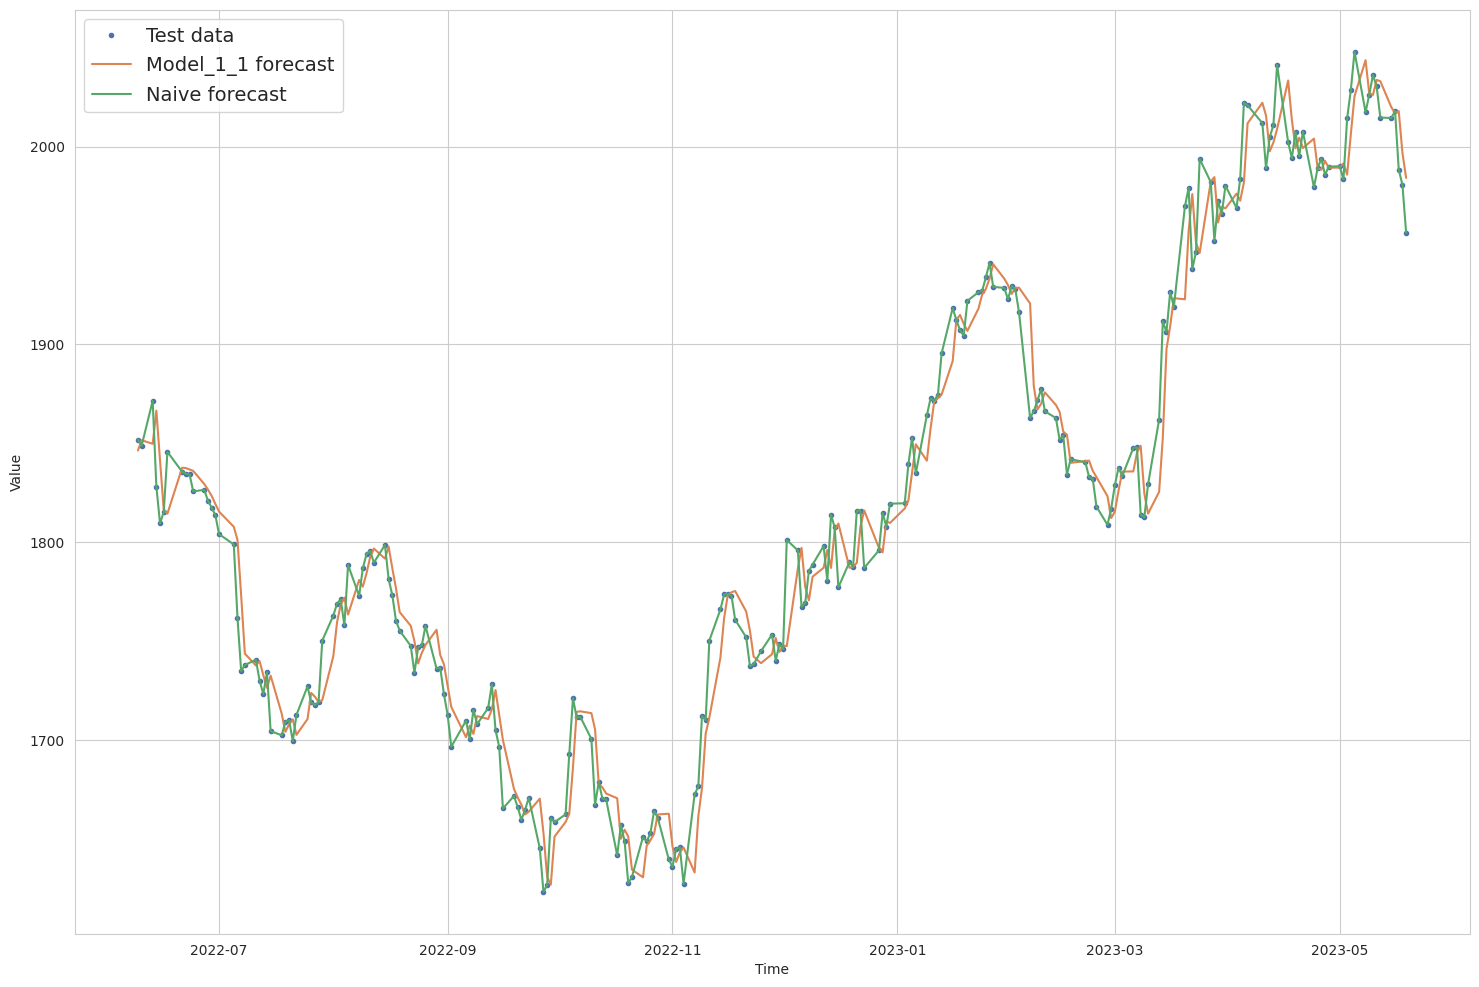

In [ ]:
# Visalise the differences
plt.figure(figsize=(18, 12))
plot_time_series(timesteps=X_test[-len(test_price_feats):], values=tf.squeeze(test_price_labels), start=900, format='.', label='Test data')
plot_time_series(timesteps=X_test[-len(test_price_feats):], values=model_1_1_best_preds, format='-', start=900, label='Model_1_1 forecast')
plot_time_series(timesteps=X_test[-len(test_price_feats):], values=naive_forecast[-len(test_price_feats):], start=900, format='-', label='Naive forecast')

## 5. Model 2: Dense model
WINDOW=30, HORIZON=1

### 5.1. Create new sets of data

In [ ]:
WINDOW_SIZE = 30
HORIZON = 1

In [ ]:
price_windows_31, price_labels_31 = make_windows(price, window=WINDOW_SIZE , horizon=HORIZON)

Window indexes:
 (array([[   0,    1,    2, ...,   28,   29,   30],
       [   1,    2,    3, ...,   29,   30,   31],
       [   2,    3,    4, ...,   30,   31,   32],
       ...,
       [5668, 5669, 5670, ..., 5696, 5697, 5698],
       [5669, 5670, 5671, ..., 5697, 5698, 5699],
       [5670, 5671, 5672, ..., 5698, 5699, 5700]]), (5671, 31))


In [ ]:
price_labels_31.shape, price_windows_31.shape

((5671, 1), (5671, 30))

In [ ]:
# Create the splits
train_price_31_feats, test_price_31_feats, train_price_31_labels, test_price_31_labels = make_train_test_splits(price_windows_31, price_labels_31)

In [ ]:
train_price_31_feats.shape, test_price_31_feats.shape, train_price_31_labels.shape, test_price_31_labels.shape

((4536, 30), (1135, 30), (4536, 1), (1135, 1))

### 5.2. Tune parameters

In [ ]:
INPUT_SHAPE = train_price_31_feats.shape[1]
INPUT_SHAPE

30

#### 5.2.1. Create tuning ensamble using SciKeras and Randomized Search CV

In [ ]:
model_2 = KerasRegressor(build_fn=create_model, verbose=0, learning_rate=0.001, activation='relu', n_units=128)

In [ ]:
params = {'activation': ["relu", "tanh", 'elu', 'sigmoid' ],
          'batch_size': [16, 32, 64],
          'n_units': [32, 64, 128, 256, 1024],
          'epochs': [50, 100],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [ ]:
from sklearn.metrics import mean_absolute_error
random_search = RandomizedSearchCV(model_2,
                                   param_distributions = params,
                                   cv = KFold(3),
                                   n_iter=30,
                                   n_jobs=-1,
                                   scoring='neg_mean_squared_error',
                                   return_train_score=True,
                                   error_score='raise')

In [ ]:
random_search_results_2 = random_search.fit(train_price_31_feats, train_price_31_labels)

#### 5.2.2. Retrieve tuning data and rank the configirations

In [ ]:
random_search_results_2.best_estimator_

In [ ]:
random_search_results_2.cv_results_

In [ ]:
random_search_2_df = pd.DataFrame(random_search_results_2.cv_results_['params'])

In [ ]:
random_search_2_ranking_df = pd.DataFrame({
    'rank_test_score': random_search_results_2.cv_results_['rank_test_score'],
    'mean_test_score': random_search_results_2.cv_results_['mean_test_score'] ,
    'mean_train_score': random_search_results_2.cv_results_['mean_train_score']
})

In [ ]:
random_search_2_ranking_df['train_test_diff'] = random_search_2_ranking_df['mean_train_score'] - random_search_2_ranking_df['mean_test_score']

In [ ]:
random_search_2_ranking_df['diff_score'] = random_search_2_ranking_df['train_test_diff'].abs().rank(method='max')

In [ ]:
model_2_param_tuning_df = random_search_2_df.join(random_search_2_ranking_df)

**Since overfitting renders the model useless, to preserve good generalization capabilities we will sort by diff_score rank and then test_score rank.**

In [ ]:
model_2_param_tuning_df.sort_values(by=['diff_score', 'rank_test_score'])

n_units  learning_rate  epochs  batch_size activation  rank_test_score  \
4      1024         0.0001      50          64       relu                9   
18     1024         0.0001      50          32       relu                6   
29      256         0.0010      50          32        elu               12   
27      128         0.0010     100          32        elu                2   
25       32         0.0001      50          64       relu               15   
10      128         0.0100      50          64       relu               16   
28       32         0.0010      50          32       relu               10   
3      1024         0.0100     100          16       relu                5   
22      256         0.0001      50          16       relu                4   
1        32         0.0001     100          16        elu                8   
2       128         0.0010     100          16       relu                3   
9        32         0.0001     100          32       relu               11   
12      256         0.0001      50          64       relu               14   
21       32         0.0100     100          64       relu               13   
17      128         0.0010     100          16        elu                1   
14       64         0.0100      50          32        elu                7   
5        32         0.0001      50          16       tanh               29   
16      128         0.0001      50          64    sigmoid               30   
0        64         0.0010     100          32    sigmoid               27   
19       64         0.0010      50          64    sigmoid               28   
15      128         0.0010      50          16    sigmoid               17   
8       128         0.0010      50          32       tanh               18   
24      256         0.0010     100          64       tanh               19   
11      256         0.0010      50          32       tanh               20   
7       256         0.0100     100          16       tanh               21   
6       256         0.0100     100          32    sigmoid               22   
20       64         0.0100      50          32       tanh               23   
13      256         0.0100      50          64    sigmoid               24   
26       32         0.0100      50          16       tanh               25   
23      256         0.0010     100          32       tanh               26   

    mean_test_score  mean_train_score  train_test_diff  diff_score  
4     -3.236619e+02     -3.245846e+02        -0.922652         1.0  
18    -3.065626e+02     -3.138474e+02        -7.284740         2.0  
29    -3.990101e+02     -3.909998e+02         8.010287         3.0  
27    -2.160970e+02     -2.261257e+02       -10.028707         4.0  
25    -6.248968e+02     -6.100214e+02        14.875429         5.0  
10    -6.470360e+02     -6.248927e+02        22.143292         6.0  
28    -3.320516e+02     -3.064731e+02        25.578466         7.0  
3     -3.023662e+02     -2.700400e+02        32.326191         8.0  
22    -2.648834e+02     -3.000253e+02       -35.141913         9.0  
1     -3.206791e+02     -2.843886e+02        36.290462        10.0  
2     -2.395306e+02     -1.955553e+02        43.975369        11.0  
9     -3.864501e+02     -3.225930e+02        63.857183        12.0  
12    -4.774730e+02     -3.814008e+02        96.072224        13.0  
21    -4.482766e+02     -3.404410e+02       107.835628        14.0  
17    -2.131931e+02     -3.588528e+02      -145.659772        15.0  
14    -3.090147e+02     -5.878626e+02      -278.847847        16.0  
5     -1.025835e+06     -1.024319e+06      1515.379832        17.0  
16    -1.051976e+06     -1.053907e+06     -1931.127117        18.0  
0     -5.523448e+05     -5.581197e+05     -5774.923172        19.0  
19    -9.331961e+05     -9.402786e+05     -7082.485551        20.0  
15    -4.193576e+05     -3.845823e+05     34775.334443        21.0  
8     -4.397401e+05     -3.627562e+05     76983.893094        22.0 

### 5.3. Build the model

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Construct the model
model_2_1 = Sequential(
    [
        Dense(32, activation='relu'),
        Dense(HORIZON, activation='linear')
    ], name='model_2_1_dense'
)

# Compile the model
model_2_1.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=['mse', 'mape']
)

# Fit the model
history_2_1 = model_2_1.fit(x=train_price_31_feats,
              y=train_price_31_labels,
              epochs=100,
              verbose=1,
              batch_size=16,
              validation_data=(test_price_31_feats, test_price_31_labels),
              callbacks=[create_model_checkpoint(model_name=model_2_1.name)])

Epoch 1/100
269/284 [===========================>..] - ETA: 0s - loss: 155.5442 - mse: 248598.2656 - mape: 17.0675

284/284 [==============================] - 2s 5ms/step - loss: 149.4430 - mse: 236018.8281 - mape: 16.3835 - val_loss: 64.7849 - val_mse: 6208.0640 - val_mape: 3.7931
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 30.4158 - mse: 1882.6127 - mape: 3.2322 - val_loss: 66.5504 - val_mse: 6090.6006 - val_mape: 3.9042
Epoch 3/100
272/284 [===========================>..] - ETA: 0s - loss: 26.7456 - mse: 1473.9279 - mape: 2.8455

284/284 [==============================] - 2s 6ms/step - loss: 26.4288 - mse: 1443.5886 - mape: 2.8124 - val_loss: 31.9886 - val_mse: 1776.7288 - val_mape: 1.8554
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 22.7046 - mse: 1058.8481 - mape: 2.4378 - val_loss: 32.6379 - val_mse: 1851.9778 - val_mape: 1.9043
Epoch 5/100
267/284 [===========================>..] - ETA: 0s - loss: 22.0401 - mse: 994.0519 - mape: 2.3825 

284/284 [==============================] - 1s 5ms/step - loss: 21.9262 - mse: 987.5853 - mape: 2.3602 - val_loss: 31.6483 - val_mse: 1644.5183 - val_mape: 1.8431
Epoch 6/100
284/284 [==============================] - 1s 3ms/step - loss: 21.2402 - mse: 927.6704 - mape: 2.2769 - val_loss: 34.4471 - val_mse: 1834.3137 - val_mape: 2.0124
Epoch 7/100
283/284 [============================>.] - ETA: 0s - loss: 21.4507 - mse: 933.4401 - mape: 2.2901

284/284 [==============================] - 1s 5ms/step - loss: 21.4375 - mse: 932.3005 - mape: 2.2891 - val_loss: 26.0513 - val_mse: 1232.2911 - val_mape: 1.5140
Epoch 8/100
284/284 [==============================] - 1s 3ms/step - loss: 19.1470 - mse: 765.3499 - mape: 2.0494 - val_loss: 33.7985 - val_mse: 1740.4608 - val_mape: 1.9763
Epoch 9/100
284/284 [==============================] - 1s 3ms/step - loss: 19.4182 - mse: 777.5676 - mape: 2.0811 - val_loss: 48.1555 - val_mse: 3239.3257 - val_mape: 2.8352
Epoch 10/100
284/284 [==============================] - 1s 3ms/step - loss: 18.4693 - mse: 707.0211 - mape: 1.9661 - val_loss: 78.3352 - val_mse: 7122.3628 - val_mape: 4.6070
Epoch 11/100
267/284 [===========================>..] - ETA: 0s - loss: 19.3075 - mse: 752.2240 - mape: 2.0670

284/284 [==============================] - 1s 5ms/step - loss: 19.1062 - mse: 738.4066 - mape: 2.0442 - val_loss: 24.9073 - val_mse: 1067.4948 - val_mape: 1.4491
Epoch 12/100
270/284 [===========================>..] - ETA: 0s - loss: 18.0959 - mse: 683.6757 - mape: 1.9387

284/284 [==============================] - 1s 5ms/step - loss: 18.4408 - mse: 701.2478 - mape: 1.9723 - val_loss: 24.5969 - val_mse: 1102.9131 - val_mape: 1.4360
Epoch 13/100
269/284 [===========================>..] - ETA: 0s - loss: 17.8537 - mse: 662.2730 - mape: 1.8896

284/284 [==============================] - 1s 5ms/step - loss: 17.7170 - mse: 652.9315 - mape: 1.8749 - val_loss: 22.1143 - val_mse: 909.4039 - val_mape: 1.2861
Epoch 14/100
284/284 [==============================] - 1s 3ms/step - loss: 19.6772 - mse: 790.5938 - mape: 2.0798 - val_loss: 41.8523 - val_mse: 2472.4343 - val_mape: 2.4632
Epoch 15/100
284/284 [==============================] - 1s 3ms/step - loss: 16.0014 - mse: 540.8574 - mape: 1.7021 - val_loss: 36.2262 - val_mse: 1951.1200 - val_mape: 2.1298
Epoch 16/100
270/284 [===========================>..] - ETA: 0s - loss: 17.0073 - mse: 583.5253 - mape: 1.8177

284/284 [==============================] - 1s 5ms/step - loss: 16.9224 - mse: 576.5800 - mape: 1.8112 - val_loss: 21.9273 - val_mse: 854.8716 - val_mape: 1.2755
Epoch 17/100
270/284 [===========================>..] - ETA: 0s - loss: 17.2903 - mse: 601.4716 - mape: 1.8465

284/284 [==============================] - 1s 5ms/step - loss: 17.1788 - mse: 597.1558 - mape: 1.8388 - val_loss: 21.0631 - val_mse: 837.7084 - val_mape: 1.2269
Epoch 18/100
284/284 [==============================] - 1s 3ms/step - loss: 15.6476 - mse: 505.0938 - mape: 1.6647 - val_loss: 37.2903 - val_mse: 1900.8566 - val_mape: 2.1881
Epoch 19/100
281/284 [============================>.] - ETA: 0s - loss: 16.1170 - mse: 561.6375 - mape: 1.7195

284/284 [==============================] - 1s 5ms/step - loss: 16.1021 - mse: 560.0706 - mape: 1.7188 - val_loss: 20.1600 - val_mse: 774.4341 - val_mape: 1.1737
Epoch 20/100
284/284 [==============================] - 1s 3ms/step - loss: 15.6404 - mse: 501.5700 - mape: 1.6863 - val_loss: 31.0094 - val_mse: 1479.0427 - val_mape: 1.8210
Epoch 21/100
284/284 [==============================] - 1s 3ms/step - loss: 16.6391 - mse: 556.5806 - mape: 1.7681 - val_loss: 48.0117 - val_mse: 2966.9851 - val_mape: 2.8288
Epoch 22/100
284/284 [==============================] - 1s 3ms/step - loss: 15.7858 - mse: 519.8162 - mape: 1.6933 - val_loss: 21.6707 - val_mse: 847.8605 - val_mape: 1.2657
Epoch 23/100
284/284 [==============================] - 1s 3ms/step - loss: 15.6743 - mse: 496.7968 - mape: 1.6619 - val_loss: 29.0350 - val_mse: 1245.7595 - val_mape: 1.7010
Epoch 24/100
269/284 [===========================>..] - ETA: 0s - loss: 15.6358 - mse: 508.1966 - mape: 1.6698

284/284 [==============================] - 1s 4ms/step - loss: 15.5162 - mse: 499.9680 - mape: 1.6548 - val_loss: 18.9868 - val_mse: 669.8040 - val_mape: 1.1041
Epoch 25/100
267/284 [===========================>..] - ETA: 0s - loss: 16.4822 - mse: 555.9803 - mape: 1.7483

284/284 [==============================] - 1s 5ms/step - loss: 16.2786 - mse: 544.1713 - mape: 1.7254 - val_loss: 18.4148 - val_mse: 650.6541 - val_mape: 1.0705
Epoch 26/100
268/284 [===========================>..] - ETA: 0s - loss: 14.0619 - mse: 420.0600 - mape: 1.5009

284/284 [==============================] - 1s 5ms/step - loss: 13.9426 - mse: 413.7908 - mape: 1.4854 - val_loss: 18.2117 - val_mse: 632.0560 - val_mape: 1.0584
Epoch 27/100
284/284 [==============================] - 1s 3ms/step - loss: 14.9435 - mse: 457.1613 - mape: 1.6015 - val_loss: 41.2487 - val_mse: 2178.8005 - val_mape: 2.4232
Epoch 28/100
268/284 [===========================>..] - ETA: 0s - loss: 14.6388 - mse: 434.8135 - mape: 1.5577

284/284 [==============================] - 1s 5ms/step - loss: 14.7091 - mse: 446.9543 - mape: 1.5635 - val_loss: 17.8838 - val_mse: 614.9835 - val_mape: 1.0396
Epoch 29/100
284/284 [==============================] - 1s 3ms/step - loss: 14.1476 - mse: 413.7448 - mape: 1.5043 - val_loss: 32.6158 - val_mse: 1469.9305 - val_mape: 1.9136
Epoch 30/100
284/284 [==============================] - 1s 3ms/step - loss: 13.3640 - mse: 373.3388 - mape: 1.4254 - val_loss: 20.6148 - val_mse: 725.2919 - val_mape: 1.2027
Epoch 31/100
284/284 [==============================] - ETA: 0s - loss: 14.2248 - mse: 419.2740 - mape: 1.5227

284/284 [==============================] - 1s 5ms/step - loss: 14.2248 - mse: 419.2740 - mape: 1.5227 - val_loss: 17.8435 - val_mse: 607.9016 - val_mape: 1.0383
Epoch 32/100
284/284 [==============================] - 1s 3ms/step - loss: 12.8066 - mse: 348.1391 - mape: 1.3652 - val_loss: 20.2274 - val_mse: 729.1077 - val_mape: 1.1813
Epoch 33/100
284/284 [==============================] - 1s 3ms/step - loss: 14.8007 - mse: 429.5461 - mape: 1.5882 - val_loss: 20.4031 - val_mse: 707.7679 - val_mape: 1.1894
Epoch 34/100
284/284 [==============================] - 1s 3ms/step - loss: 13.0132 - mse: 357.3680 - mape: 1.3697 - val_loss: 20.1097 - val_mse: 718.6298 - val_mape: 1.1744
Epoch 35/100
270/284 [===========================>..] - ETA: 0s - loss: 13.1575 - mse: 359.8673 - mape: 1.3918

284/284 [==============================] - 1s 5ms/step - loss: 13.1350 - mse: 358.5284 - mape: 1.3896 - val_loss: 16.7612 - val_mse: 544.0439 - val_mape: 0.9734
Epoch 36/100
284/284 [==============================] - 1s 3ms/step - loss: 14.8288 - mse: 438.4087 - mape: 1.5769 - val_loss: 30.7457 - val_mse: 1320.3503 - val_mape: 1.8039
Epoch 37/100
284/284 [==============================] - 1s 3ms/step - loss: 13.3122 - mse: 369.2010 - mape: 1.4084 - val_loss: 18.4613 - val_mse: 605.7151 - val_mape: 1.0755
Epoch 38/100
284/284 [==============================] - 1s 3ms/step - loss: 12.3393 - mse: 322.5274 - mape: 1.3126 - val_loss: 17.6149 - val_mse: 581.5966 - val_mape: 1.0253
Epoch 39/100
284/284 [==============================] - 1s 3ms/step - loss: 13.9060 - mse: 403.9471 - mape: 1.4803 - val_loss: 18.6752 - val_mse: 633.1992 - val_mape: 1.0889
Epoch 40/100
284/284 [==============================] - 1s 3ms/step - loss: 12.9745 - mse: 351.6432 - mape: 1.3660 - val_loss: 22.4136 - val_m

284/284 [==============================] - 1s 5ms/step - loss: 11.4133 - mse: 281.9649 - mape: 1.2166 - val_loss: 16.1488 - val_mse: 507.3189 - val_mape: 0.9381
Epoch 45/100
284/284 [==============================] - 1s 3ms/step - loss: 13.4052 - mse: 372.2663 - mape: 1.4219 - val_loss: 32.7242 - val_mse: 1427.3158 - val_mape: 1.9213
Epoch 46/100
284/284 [==============================] - 1s 3ms/step - loss: 12.2417 - mse: 312.6158 - mape: 1.3071 - val_loss: 24.8460 - val_mse: 959.7795 - val_mape: 1.4583
Epoch 47/100
284/284 [==============================] - 1s 3ms/step - loss: 11.9131 - mse: 304.6116 - mape: 1.2680 - val_loss: 19.6163 - val_mse: 673.8207 - val_mape: 1.1463
Epoch 48/100
284/284 [==============================] - 1s 3ms/step - loss: 12.2971 - mse: 320.9024 - mape: 1.2978 - val_loss: 16.6775 - val_mse: 513.0048 - val_mape: 0.9711
Epoch 49/100
284/284 [==============================] - 1s 3ms/step - loss: 12.0437 - mse: 307.5556 - mape: 1.2865 - val_loss: 19.6129 - val_m

284/284 [==============================] - 1s 5ms/step - loss: 11.8659 - mse: 302.4204 - mape: 1.2590 - val_loss: 15.4266 - val_mse: 466.4296 - val_mape: 0.8957
Epoch 53/100
284/284 [==============================] - 1s 3ms/step - loss: 10.7894 - mse: 258.4039 - mape: 1.1411 - val_loss: 15.6906 - val_mse: 478.2792 - val_mape: 0.9115
Epoch 54/100
284/284 [==============================] - 1s 3ms/step - loss: 11.5717 - mse: 287.6096 - mape: 1.2231 - val_loss: 19.2793 - val_mse: 618.2891 - val_mape: 1.1262
Epoch 55/100
284/284 [==============================] - 1s 3ms/step - loss: 11.7085 - mse: 289.7436 - mape: 1.2433 - val_loss: 21.2378 - val_mse: 748.2493 - val_mape: 1.2439
Epoch 56/100
284/284 [==============================] - 1s 3ms/step - loss: 11.1669 - mse: 276.2108 - mape: 1.1879 - val_loss: 15.4682 - val_mse: 459.1919 - val_mape: 0.8991
Epoch 57/100
284/284 [==============================] - 1s 3ms/step - loss: 11.7113 - mse: 292.6708 - mape: 1.2433 - val_loss: 19.8609 - val_ms

284/284 [==============================] - 2s 6ms/step - loss: 11.6228 - mse: 287.5706 - mape: 1.2244 - val_loss: 15.1485 - val_mse: 446.6444 - val_mape: 0.8797
Epoch 59/100
284/284 [==============================] - 1s 3ms/step - loss: 10.9958 - mse: 257.4937 - mape: 1.1657 - val_loss: 17.1296 - val_mse: 538.9985 - val_mape: 0.9985
Epoch 60/100
281/284 [============================>.] - ETA: 0s - loss: 11.7570 - mse: 293.5109 - mape: 1.2544

284/284 [==============================] - 1s 5ms/step - loss: 11.7293 - mse: 292.1807 - mape: 1.2520 - val_loss: 14.9983 - val_mse: 440.9227 - val_mape: 0.8707
Epoch 61/100
284/284 [==============================] - 1s 3ms/step - loss: 11.3581 - mse: 272.3589 - mape: 1.2074 - val_loss: 15.5367 - val_mse: 455.9129 - val_mape: 0.9034
Epoch 62/100
284/284 [==============================] - 1s 3ms/step - loss: 11.4429 - mse: 279.6024 - mape: 1.2188 - val_loss: 17.2752 - val_mse: 543.7865 - val_mape: 1.0076
Epoch 63/100
267/284 [===========================>..] - ETA: 0s - loss: 11.1756 - mse: 265.0472 - mape: 1.1871

284/284 [==============================] - 1s 5ms/step - loss: 11.1680 - mse: 271.5971 - mape: 1.1856 - val_loss: 14.9098 - val_mse: 433.6873 - val_mape: 0.8656
Epoch 64/100
284/284 [==============================] - 1s 3ms/step - loss: 11.0740 - mse: 263.6803 - mape: 1.1803 - val_loss: 17.6673 - val_mse: 561.2553 - val_mape: 1.0314
Epoch 65/100
284/284 [==============================] - 1s 3ms/step - loss: 11.7484 - mse: 291.0807 - mape: 1.2549 - val_loss: 15.4538 - val_mse: 449.0109 - val_mape: 0.8985
Epoch 66/100
284/284 [==============================] - 1s 3ms/step - loss: 11.2150 - mse: 271.8781 - mape: 1.1913 - val_loss: 20.4024 - val_mse: 693.2249 - val_mape: 1.1949
Epoch 67/100
270/284 [===========================>..] - ETA: 0s - loss: 11.6672 - mse: 286.8954 - mape: 1.2422

284/284 [==============================] - 1s 5ms/step - loss: 11.6464 - mse: 285.0533 - mape: 1.2397 - val_loss: 14.8900 - val_mse: 435.9590 - val_mape: 0.8644
Epoch 68/100
284/284 [==============================] - 1s 3ms/step - loss: 11.2478 - mse: 268.8041 - mape: 1.2046 - val_loss: 15.7637 - val_mse: 458.4398 - val_mape: 0.9171
Epoch 69/100
284/284 [==============================] - 1s 3ms/step - loss: 10.6068 - mse: 241.2344 - mape: 1.1295 - val_loss: 21.5748 - val_mse: 712.6196 - val_mape: 1.2627
Epoch 70/100
267/284 [===========================>..] - ETA: 0s - loss: 10.6915 - mse: 254.1947 - mape: 1.1392

284/284 [==============================] - 1s 5ms/step - loss: 10.8172 - mse: 257.3675 - mape: 1.1490 - val_loss: 14.6664 - val_mse: 420.9180 - val_mape: 0.8513
Epoch 71/100
281/284 [============================>.] - ETA: 0s - loss: 11.3939 - mse: 276.1939 - mape: 1.2140

284/284 [==============================] - 1s 5ms/step - loss: 11.3832 - mse: 275.9153 - mape: 1.2136 - val_loss: 14.6342 - val_mse: 421.9685 - val_mape: 0.8493
Epoch 72/100
279/284 [============================>.] - ETA: 0s - loss: 11.5744 - mse: 283.6373 - mape: 1.2302

284/284 [==============================] - 1s 5ms/step - loss: 11.6165 - mse: 285.5787 - mape: 1.2333 - val_loss: 14.6253 - val_mse: 421.6746 - val_mape: 0.8488
Epoch 73/100
284/284 [==============================] - 1s 3ms/step - loss: 10.1077 - mse: 232.5671 - mape: 1.0717 - val_loss: 14.6365 - val_mse: 422.2656 - val_mape: 0.8496
Epoch 74/100
284/284 [==============================] - 1s 3ms/step - loss: 10.1833 - mse: 232.4546 - mape: 1.0816 - val_loss: 15.1546 - val_mse: 445.5009 - val_mape: 0.8810
Epoch 75/100
284/284 [==============================] - 1s 3ms/step - loss: 11.0861 - mse: 259.7046 - mape: 1.1773 - val_loss: 17.4992 - val_mse: 547.8027 - val_mape: 1.0220
Epoch 76/100
284/284 [==============================] - 1s 3ms/step - loss: 10.2623 - mse: 230.2409 - mape: 1.0909 - val_loss: 23.6676 - val_mse: 817.6803 - val_mape: 1.3868
Epoch 77/100
284/284 [==============================] - 1s 3ms/step - loss: 11.3287 - mse: 277.8648 - mape: 1.1999 - val_loss: 18.1261 - val_ms

284/284 [==============================] - 1s 5ms/step - loss: 10.6050 - mse: 240.3490 - mape: 1.1233 - val_loss: 14.5944 - val_mse: 410.5616 - val_mape: 0.8471
Epoch 84/100
284/284 [==============================] - 1s 3ms/step - loss: 10.2672 - mse: 231.3500 - mape: 1.0879 - val_loss: 26.6081 - val_mse: 981.6312 - val_mape: 1.5609
Epoch 85/100
284/284 [==============================] - 1s 3ms/step - loss: 10.7422 - mse: 249.2274 - mape: 1.1445 - val_loss: 26.7435 - val_mse: 988.7177 - val_mape: 1.5690
Epoch 86/100
284/284 [==============================] - 1s 3ms/step - loss: 10.5330 - mse: 239.4212 - mape: 1.1234 - val_loss: 17.8698 - val_mse: 534.8375 - val_mape: 1.0431
Epoch 87/100
284/284 [==============================] - 1s 3ms/step - loss: 11.0983 - mse: 263.3391 - mape: 1.1760 - val_loss: 16.5351 - val_mse: 479.3932 - val_mape: 0.9636
Epoch 88/100
284/284 [==============================] - 1s 3ms/step - loss: 10.2212 - mse: 227.8719 - mape: 1.0865 - val_loss: 16.2220 - val_ms

284/284 [==============================] - 1s 5ms/step - loss: 9.7785 - mse: 215.6063 - mape: 1.0334 - val_loss: 14.4489 - val_mse: 409.3242 - val_mape: 0.8391
Epoch 99/100
284/284 [==============================] - ETA: 0s - loss: 11.6100 - mse: 284.1182 - mape: 1.2371

284/284 [==============================] - 1s 5ms/step - loss: 11.6100 - mse: 284.1182 - mape: 1.2371 - val_loss: 14.2008 - val_mse: 398.5579 - val_mape: 0.8240
Epoch 100/100
284/284 [==============================] - 1s 3ms/step - loss: 10.3333 - mse: 236.8158 - mape: 1.0995 - val_loss: 14.4121 - val_mse: 399.4821 - val_mape: 0.8363


### 5.4. Evaluate the model

In [ ]:
model_2_1_results = model_2_1.evaluate(test_price_31_feats, test_price_31_labels)

36/36 [==============================] - 0s 2ms/step - loss: 14.4121 - mse: 399.4820 - mape: 0.8363


In [ ]:
naive_result

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

In [ ]:
model_2_1_results

[14.41213321685791, 399.48199462890625, 0.836272656917572]

In [ ]:
# Load best performing model
model_2_1_best = tf.keras.models.load_model('/content/model_experiments/model_2_1_dense')

In [ ]:
model_2_1_best_results = model_2_1_best.evaluate(test_price_31_feats, test_price_31_labels)

36/36 [==============================] - 0s 2ms/step - loss: 14.2008 - mse: 398.5579 - mape: 0.8240


In [ ]:
model_2_1_best_results

[14.200836181640625, 398.557861328125, 0.8239765763282776]

In [ ]:
# Make predictions
model_2_1_best_preds = make_preds(model_2_1_best, test_price_31_feats)

len(model_2_1_best_preds), model_2_1_best_preds[:10], len(test_price_31_labels), test_price_31_labels[:10]

36/36 [==============================] - 0s 1ms/step


(1135,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1210.383 , 1207.503 , 1221.957 , 1218.7908, 1224.0479, 1227.8716,
        1224.4028, 1226.0446, 1215.1289, 1222.0099], dtype=float32)>,
 1135,
 array([[1212.80004883],
        [1220.80004883],
        [1223.09997559],
        [1219.        ],
        [1225.80004883],
        [1221.        ],
        [1220.19995117],
        [1211.19995117],
        [1221.40002441],
        [1224.09997559]]))

In [ ]:
# Produce metrics for model_1_1_best
model_2_1_best_results = produce_metrics(tf.cast(test_price_31_labels, dtype=tf.float32), model_2_1_best_preds)

In [ ]:
model_2_1_best_results

{'mae': 236.06375,
 'mse': 91610.24,
 'rmse': 302.67184,
 'mape': 14.703503,
 'smape': 14.413929,
 'mase': 19.229536}

In [ ]:
model_1_1_best_results

{'mae': 237.65211,
 'mse': 92826.016,
 'rmse': 304.6736,
 'mape': 14.81863,
 'smape': 14.539687,
 'mase': 19.398224}

In [ ]:
naive_result

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

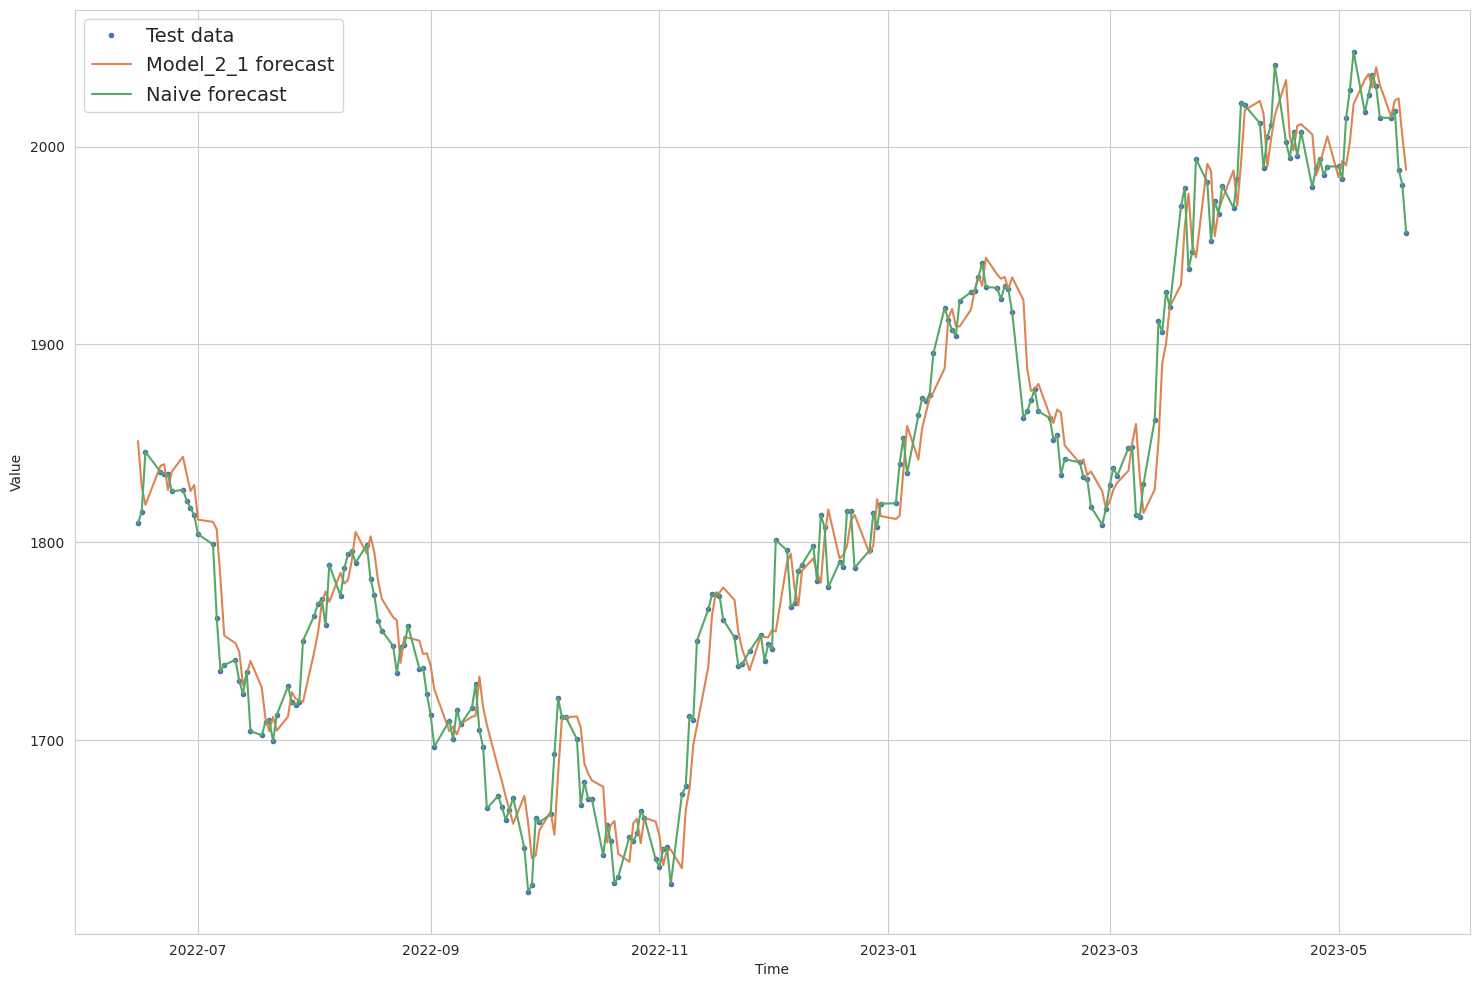

In [ ]:
# Visalise the differences
plt.figure(figsize=(18, 12))
plot_time_series(timesteps=X_test[-len(test_price_31_labels):], values=tf.squeeze(test_price_31_labels), start=900, format='.', label='Test data')
plot_time_series(timesteps=X_test[-len(test_price_31_labels):], values=model_2_1_best_preds, format='-', start=900, label='Model_2_1 forecast')
plot_time_series(timesteps=X_test[-len(test_price_31_labels):], values=naive_forecast[-len(test_price_31_labels):], start=900, format='-', label='Naive forecast')

## 6. Model 3: Dense model
WINDOW=30, HORIZON=7

### 6.1. Create new sets of data

In [ ]:
WINDOW_SIZE = 30
HORIZON = 7

In [ ]:
price_windows_37, price_labels_37 = make_windows(price, window=WINDOW_SIZE , horizon=HORIZON)

Window indexes:
 (array([[   0,    1,    2, ...,   34,   35,   36],
       [   1,    2,    3, ...,   35,   36,   37],
       [   2,    3,    4, ...,   36,   37,   38],
       ...,
       [5662, 5663, 5664, ..., 5696, 5697, 5698],
       [5663, 5664, 5665, ..., 5697, 5698, 5699],
       [5664, 5665, 5666, ..., 5698, 5699, 5700]]), (5665, 37))


In [ ]:
price_windows_37.shape, price_labels_37.shape

((5665, 30), (5665, 7))

In [ ]:
# Create the splits
train_price_37_feats, test_price_37_feats, train_price_37_labels, test_price_37_labels = make_train_test_splits(price_windows_37, price_labels_37)

In [ ]:
train_price_37_feats.shape, test_price_37_feats.shape, train_price_37_labels.shape, test_price_37_labels.shape

((4532, 30), (1133, 30), (4532, 7), (1133, 7))

### 6.2. Tune parameters

In [ ]:
# Modify parameters used by create_model function
INPUT_SHAPE = train_price_37_feats.shape[1]
OUTPUT_SHAPE = train_price_37_labels.shape[1]

INPUT_SHAPE, OUTPUT_SHAPE

(30, 7)

#### 6.2.1. Create tuning ensamble using SciKeras and Randomized Search CV

In [ ]:
model_3 = KerasRegressor(build_fn=create_model, verbose=0, learning_rate=0.001, activation='relu', n_units=128)

In [ ]:
params = {'activation': ["relu", "tanh", 'elu', 'sigmoid' ],
          'batch_size': [16, 32, 64],
          'n_units': [32, 64, 128, 256, 1024],
          'epochs': [50, 100],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [ ]:
from sklearn.metrics import mean_absolute_error
random_search = RandomizedSearchCV(model_3,
                                   param_distributions = params,
                                   cv = KFold(3),
                                   n_iter=30,
                                   n_jobs=-1,
                                   scoring='neg_mean_squared_error',
                                   return_train_score=True,
                                   error_score='raise')

In [ ]:
random_search_results_3 = random_search.fit(train_price_37_feats, train_price_37_labels)

/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


#### 6.2.2. Retrieve tuning data and rank the configirations

In [ ]:
random_search_results_3.best_estimator_

KerasRegressor(
	model=None
	build_fn=<function create_model at 0x7facf4140f70>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	learning_rate=0.001
	activation=relu
	n_units=256
)

In [ ]:
random_search_results_3.cv_results_

{'mean_fit_time': array([11.57054949, 20.66687059, 40.39024369, 20.14093677, 20.44345633,
        79.28007166, 40.89263741, 12.06711626, 40.91096878, 41.69475492,
        42.67336019, 76.31372062, 27.21792626, 20.44209131, 11.59280658,
        20.45078127, 42.25848142, 40.25498136, 39.70247626, 40.13997157,
        38.41544938, 14.30291637, 38.51937556, 20.49190172, 39.90857315,
        41.1227053 , 40.66629728, 80.29778131, 21.42301949, 68.94432608]),
 'std_fit_time': array([ 0.40554563,  0.61094998,  2.06016548,  1.9686909 ,  0.53824004,
         2.58797375,  1.2246704 ,  6.63388434,  0.5174077 ,  0.01959271,
         0.85823768,  1.13938802, 10.63978516,  0.69095365,  0.36209914,
         0.80958446,  0.45768843,  2.70286536,  2.92596884,  2.42167165,
         4.38713641,  4.95681129,  0.92746831,  0.52626309,  1.15563691,
         2.94937683,  0.76590149,  4.37565186,  0.01979918, 12.75674347]),
 'mean_score_time': array([0.20536582, 0.23678843, 0.75375803, 0.30351472, 0.48731128,


In [ ]:
# Create data frame with checked model parameters
random_search_3_df = pd.DataFrame(random_search_results_3.cv_results_['params'])

In [ ]:
# Add ranking columns
random_search_3_ranking_df = pd.DataFrame({
    'rank_test_score': random_search_results_3.cv_results_['rank_test_score'],
    'mean_test_score': random_search_results_3.cv_results_['mean_test_score'] ,
    'mean_train_score': random_search_results_3.cv_results_['mean_train_score']
})

In [ ]:
# Compute the difference between train and test scores
random_search_3_ranking_df['train_test_diff'] = random_search_3_ranking_df['mean_train_score'] - random_search_3_ranking_df['mean_test_score']

In [ ]:
# Create diff score ranking
random_search_3_ranking_df['diff_score'] = random_search_3_ranking_df['train_test_diff'].abs().rank(method='max')

In [ ]:
model_3_param_tuning_df = random_search_3_df.join(random_search_3_ranking_df)

**Since overfitting renders the model useless, to preserve good generalization capabilities we will sort by diff_score rank and then test_score rank.**

In [ ]:
model_3_param_tuning_df.sort_values(by=['diff_score', 'rank_test_score'])

n_units  learning_rate  epochs  batch_size activation  rank_test_score  \
2        32         0.0010      50          16        elu                8   
3        64         0.0010      50          32        elu                2   
29      256         0.0010     100          16       relu                1   
23       64         0.0010      50          32       relu                9   
24       64         0.0010     100          32       relu                3   
15       64         0.0001      50          32       relu               12   
25      128         0.0001     100          32       relu                6   
11       64         0.0001     100          16        elu                7   
27       64         0.0010     100          16       relu                5   
28       64         0.0001      50          32        elu               13   
13      128         0.0100     100          64       relu                4   
0        64         0.0001      50          64       tanh               30   
7       128         0.0010      50          64       relu               10   
9        64         0.0010      50          16       relu               11   
1        32         0.0001     100          64       tanh               29   
14       64         0.0001      50          64       relu               15   
26     1024         0.0100      50          16        elu               14   
18      256         0.0001      50          16    sigmoid               28   
6        32         0.0010      50          16    sigmoid               27   
19     1024         0.0001     100          32    sigmoid               18   
17       64         0.0010      50          16    sigmoid               26   
4        32         0.0100      50          32    sigmoid               16   
22       64         0.0010      50          16       tanh               17   
8       128         0.0010     100          32       tanh               19   
21     1024         0.0100      50          64    sigmoid               20   
16      256         0.0100     100          32    sigmoid               21   
10      128         0.0100     100          32       tanh               22   
5       256         0.0100     100          16       tanh               23   
12     1024         0.0010     100          64       tanh               24   
20       32         0.0100      50          16       tanh               25   

    mean_test_score  mean_train_score  train_test_diff  diff_score  
2     -8.716997e+02     -8.647057e+02         6.994025         1.0  
3     -7.301366e+02     -7.037921e+02        26.344510         2.0  
29    -6.677160e+02     -6.345241e+02        33.191813         3.0  
23    -8.963991e+02     -8.597075e+02        36.691556         4.0  
24    -7.444041e+02     -7.838151e+02       -39.410972         5.0  
15    -1.047576e+03     -9.728657e+02        74.710119         6.0  
25    -7.796801e+02     -7.004351e+02        79.245081         7.0  
11    -8.422156e+02     -7.482241e+02        93.991586         8.0  
27    -7.593640e+02     -6.565361e+02       102.827860         9.0  
28    -1.258582e+03     -1.132374e+03       126.208423        10.0  
13    -7.564434e+02     -9.179075e+02      -161.464018        11.0  
0     -1.053694e+06     -1.053511e+06       182.724382        12.0  
7     -9.306416e+02     -7.370998e+02       193.541824        13.0  
9     -9.604010e+02     -7.570123e+02       203.388725        14.0  
1     -1.053380e+06     -1.053110e+06       270.323455        15.0  
14    -1.722804e+03     -1.353497e+03       369.307214        16.0  
26    -1.544134e+03     -1.022664e+03       521.469597        17.0  
18    -8.775540e+05     -8.802096e+05     -2655.616499        18.0  
6     -8.069034e+05     -8.242738e+05    -17370.408217        19.0  
19    -4.470961e+05     -4.211199e+05     25976.246112        20.0  
17    -5.656852e+05     -5.973506e+05    -31665.437379        21.0  
4     -3.737865e+05     -3.154222e+05     58364.236033        22.0 

### 6.3. Build the model

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Construct the model
model_3_1 = Sequential(
    [
        Dense(1024, activation='elu'),
        Dense(HORIZON, activation='linear')
    ], name='model_3_1_dense'
)

# Compile the model
model_3_1.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=['mse', 'mape']
)

# Fit the model
history_3_1 = model_3_1.fit(x=train_price_37_feats,
              y=train_price_37_labels,
              epochs=100,
              verbose=1,
              batch_size=16,
              validation_data=(test_price_37_feats, test_price_37_labels),
              callbacks=[create_model_checkpoint(model_name=model_3_1.name)])

Epoch 1/100
270/284 [===========================>..] - ETA: 0s - loss: 53.9506 - mse: 17759.5898 - mape: 5.6865

284/284 [==============================] - 2s 5ms/step - loss: 52.6724 - mse: 16992.4883 - mape: 5.5511 - val_loss: 55.5292 - val_mse: 4724.0200 - val_mape: 3.2487
Epoch 2/100
266/284 [===========================>..] - ETA: 0s - loss: 28.6929 - mse: 1682.5972 - mape: 3.0557

284/284 [==============================] - 1s 5ms/step - loss: 28.6002 - mse: 1665.4609 - mape: 3.0384 - val_loss: 39.2519 - val_mse: 2838.2793 - val_mape: 2.2933
Epoch 3/100
264/284 [==========================>...] - ETA: 0s - loss: 26.2321 - mse: 1379.2333 - mape: 2.7922

284/284 [==============================] - 1s 5ms/step - loss: 26.2257 - mse: 1380.1909 - mape: 2.7900 - val_loss: 39.2436 - val_mse: 2550.2380 - val_mape: 2.2963
Epoch 4/100
269/284 [===========================>..] - ETA: 0s - loss: 24.9043 - mse: 1265.0681 - mape: 2.6561

284/284 [==============================] - 1s 5ms/step - loss: 24.8088 - mse: 1251.2125 - mape: 2.6452 - val_loss: 38.1704 - val_mse: 2465.1682 - val_mape: 2.2314
Epoch 5/100
278/284 [============================>.] - ETA: 0s - loss: 24.4374 - mse: 1223.9269 - mape: 2.6085

284/284 [==============================] - 1s 5ms/step - loss: 24.5373 - mse: 1231.3085 - mape: 2.6212 - val_loss: 36.3514 - val_mse: 2264.1699 - val_mape: 2.1269
Epoch 6/100
276/284 [============================>.] - ETA: 0s - loss: 22.8070 - mse: 1074.9534 - mape: 2.4411

284/284 [==============================] - 2s 6ms/step - loss: 22.7190 - mse: 1066.1934 - mape: 2.4317 - val_loss: 33.0275 - val_mse: 1846.1937 - val_mape: 1.9289
Epoch 7/100
284/284 [==============================] - 1s 3ms/step - loss: 22.4791 - mse: 1041.0206 - mape: 2.3891 - val_loss: 33.7480 - val_mse: 1945.4388 - val_mape: 1.9733
Epoch 8/100
270/284 [===========================>..] - ETA: 0s - loss: 23.9847 - mse: 1155.5048 - mape: 2.5506

284/284 [==============================] - 1s 5ms/step - loss: 23.7967 - mse: 1144.4604 - mape: 2.5378 - val_loss: 30.3502 - val_mse: 1639.9547 - val_mape: 1.7714
Epoch 9/100
284/284 [==============================] - 1s 3ms/step - loss: 23.1089 - mse: 1083.0227 - mape: 2.4619 - val_loss: 44.9461 - val_mse: 2959.7295 - val_mape: 2.6444
Epoch 10/100
284/284 [==============================] - 1s 3ms/step - loss: 22.8637 - mse: 1058.9412 - mape: 2.4406 - val_loss: 38.3367 - val_mse: 2320.6709 - val_mape: 2.2431
Epoch 11/100
284/284 [==============================] - 1s 3ms/step - loss: 22.6379 - mse: 1063.2141 - mape: 2.4052 - val_loss: 52.1456 - val_mse: 3948.1174 - val_mape: 3.0725
Epoch 12/100
266/284 [===========================>..] - ETA: 0s - loss: 22.3055 - mse: 1019.1260 - mape: 2.3867

284/284 [==============================] - 1s 5ms/step - loss: 22.2512 - mse: 1015.8839 - mape: 2.3767 - val_loss: 26.6576 - val_mse: 1353.7605 - val_mape: 1.5506
Epoch 13/100
284/284 [==============================] - 1s 3ms/step - loss: 21.4478 - mse: 942.8887 - mape: 2.2893 - val_loss: 27.6226 - val_mse: 1422.2472 - val_mape: 1.6090
Epoch 14/100
284/284 [==============================] - 1s 3ms/step - loss: 21.1523 - mse: 930.7120 - mape: 2.2558 - val_loss: 28.6265 - val_mse: 1481.4539 - val_mape: 1.6695
Epoch 15/100
284/284 [==============================] - 1s 3ms/step - loss: 21.2386 - mse: 937.0720 - mape: 2.2775 - val_loss: 41.9629 - val_mse: 2851.0012 - val_mape: 2.4673
Epoch 16/100
284/284 [==============================] - 1s 3ms/step - loss: 22.5818 - mse: 1037.7378 - mape: 2.4110 - val_loss: 56.4901 - val_mse: 4311.4028 - val_mape: 3.3183
Epoch 17/100
284/284 [==============================] - ETA: 0s - loss: 20.5495 - mse: 876.4540 - mape: 2.1995

284/284 [==============================] - 1s 5ms/step - loss: 20.5495 - mse: 876.4540 - mape: 2.1995 - val_loss: 26.2998 - val_mse: 1323.5271 - val_mape: 1.5309
Epoch 18/100
284/284 [==============================] - 1s 3ms/step - loss: 19.9741 - mse: 848.5163 - mape: 2.1341 - val_loss: 37.8270 - val_mse: 2334.1641 - val_mape: 2.2149
Epoch 19/100
284/284 [==============================] - 1s 3ms/step - loss: 20.2049 - mse: 858.1915 - mape: 2.1630 - val_loss: 28.8393 - val_mse: 1475.7706 - val_mape: 1.6837
Epoch 20/100
284/284 [==============================] - 1s 3ms/step - loss: 19.5578 - mse: 822.1086 - mape: 2.0786 - val_loss: 55.1227 - val_mse: 4152.3462 - val_mape: 3.2382
Epoch 21/100
284/284 [==============================] - 1s 3ms/step - loss: 19.9276 - mse: 837.5137 - mape: 2.1374 - val_loss: 29.4614 - val_mse: 1541.8916 - val_mape: 1.7206
Epoch 22/100
284/284 [==============================] - 1s 3ms/step - loss: 19.2316 - mse: 788.9965 - mape: 2.0536 - val_loss: 27.8749 - v

284/284 [==============================] - 1s 5ms/step - loss: 18.1445 - mse: 715.3285 - mape: 1.9394 - val_loss: 26.2436 - val_mse: 1296.6099 - val_mape: 1.5292
Epoch 55/100
284/284 [==============================] - 1s 3ms/step - loss: 18.4597 - mse: 729.6754 - mape: 1.9779 - val_loss: 35.3627 - val_mse: 2005.4828 - val_mape: 2.0706
Epoch 56/100
284/284 [==============================] - 1s 3ms/step - loss: 17.6161 - mse: 677.5723 - mape: 1.8938 - val_loss: 31.7065 - val_mse: 1748.7571 - val_mape: 1.8596
Epoch 57/100
284/284 [==============================] - 1s 3ms/step - loss: 17.7959 - mse: 696.8385 - mape: 1.8984 - val_loss: 29.1927 - val_mse: 1600.7699 - val_mape: 1.7091
Epoch 58/100
284/284 [==============================] - 1s 3ms/step - loss: 18.3301 - mse: 721.4758 - mape: 1.9534 - val_loss: 45.5551 - val_mse: 2954.0310 - val_mape: 2.6737
Epoch 59/100
284/284 [==============================] - 1s 3ms/step - loss: 17.7453 - mse: 690.8191 - mape: 1.8975 - val_loss: 26.9556 - v

284/284 [==============================] - 1s 5ms/step - loss: 18.6987 - mse: 751.3653 - mape: 2.0039 - val_loss: 25.4373 - val_mse: 1268.2437 - val_mape: 1.4817
Epoch 65/100
276/284 [============================>.] - ETA: 0s - loss: 18.1239 - mse: 711.6527 - mape: 1.9365

284/284 [==============================] - 1s 5ms/step - loss: 18.0604 - mse: 706.9561 - mape: 1.9300 - val_loss: 24.9252 - val_mse: 1225.1508 - val_mape: 1.4513
Epoch 66/100
284/284 [==============================] - 1s 3ms/step - loss: 17.8829 - mse: 684.0908 - mape: 1.9151 - val_loss: 28.4216 - val_mse: 1453.5752 - val_mape: 1.6587
Epoch 67/100
284/284 [==============================] - 1s 3ms/step - loss: 18.2173 - mse: 717.5857 - mape: 1.9514 - val_loss: 25.1480 - val_mse: 1238.6863 - val_mape: 1.4642
Epoch 68/100
264/284 [==========================>...] - ETA: 0s - loss: 17.8151 - mse: 691.6154 - mape: 1.9060

284/284 [==============================] - 1s 5ms/step - loss: 17.8099 - mse: 687.9364 - mape: 1.9059 - val_loss: 24.6865 - val_mse: 1215.1703 - val_mape: 1.4369
Epoch 69/100
282/284 [============================>.] - ETA: 0s - loss: 17.6037 - mse: 682.2802 - mape: 1.8857

284/284 [==============================] - 1s 5ms/step - loss: 17.6002 - mse: 681.9218 - mape: 1.8861 - val_loss: 24.6550 - val_mse: 1218.9871 - val_mape: 1.4353
Epoch 70/100
284/284 [==============================] - 1s 3ms/step - loss: 17.6303 - mse: 684.1611 - mape: 1.8944 - val_loss: 36.4672 - val_mse: 2109.8496 - val_mape: 2.1367
Epoch 71/100
284/284 [==============================] - 1s 3ms/step - loss: 18.8525 - mse: 764.6622 - mape: 2.0123 - val_loss: 28.8599 - val_mse: 1492.5541 - val_mape: 1.6890
Epoch 72/100
284/284 [==============================] - 1s 3ms/step - loss: 17.4992 - mse: 677.1996 - mape: 1.8629 - val_loss: 31.9362 - val_mse: 1765.5240 - val_mape: 1.8740
Epoch 73/100
284/284 [==============================] - 1s 3ms/step - loss: 17.8409 - mse: 698.2783 - mape: 1.9132 - val_loss: 29.8415 - val_mse: 1605.4081 - val_mape: 1.7445
Epoch 74/100
284/284 [==============================] - 1s 3ms/step - loss: 18.8063 - mse: 759.8589 - mape: 2.0135 - val_loss: 55.3784 - v

### 6.4. Evaluate the model

In [ ]:
# Load best performing model
model_3_1_best = tf.keras.models.load_model('/content/model_experiments/model_3_1_dense')

In [ ]:
model_3_1_best_results = model_2_1_best.evaluate(test_price_37_feats, test_price_37_labels)

36/36 [==============================] - 0s 2ms/step - loss: 24.5028 - mse: 1212.0352 - mape: 1.4247


In [ ]:
# Make predictions
model_3_1_best_preds = make_preds(model_3_1_best, test_price_37_feats)

len(model_3_1_best_preds), model_3_1_best_preds[:10], len(test_price_37_labels), test_price_37_labels[:10]

36/36 [==============================] - 0s 1ms/step


(1133,
 <tf.Tensor: shape=(10, 7), dtype=float32, numpy=
 array([[1227.7078, 1227.7306, 1224.6617, 1227.9397, 1223.7384, 1236.1006,
         1227.4846],
        [1219.4335, 1219.6061, 1216.3217, 1219.3788, 1215.5361, 1227.7278,
         1219.1232],
        [1212.0624, 1212.5684, 1209.3804, 1212.9895, 1208.788 , 1221.0018,
         1212.4324],
        [1206.3632, 1207.1296, 1203.9398, 1207.2972, 1203.5745, 1214.9434,
         1206.804 ],
        [1207.8989, 1208.3676, 1205.3705, 1208.7538, 1204.8983, 1216.5281,
         1208.1654],
        [1211.3804, 1212.0784, 1209.0394, 1212.2067, 1208.6165, 1220.761 ,
         1211.6012],
        [1217.8771, 1217.6903, 1214.9547, 1218.4237, 1214.8132, 1227.1003,
         1218.0156],
        [1222.6833, 1222.8236, 1220.5482, 1223.2703, 1219.825 , 1232.0657,
         1223.6686],
        [1224.0995, 1224.5696, 1221.5863, 1224.7859, 1221.2827, 1233.519 ,
         1225.2966],
        [1226.8903, 1227.6978, 1224.6906, 1227.866 , 1224.6221, 1237.1393,
    

In [ ]:
model_3_1_best_preds.shape, model_2_1_best_preds.shape

(TensorShape([1133, 7]), TensorShape([1135]))

In [ ]:
# Produce metrics for model_1_1_best
model_3_1_best_results = produce_metrics(tf.cast(test_price_37_labels, dtype=tf.float32), model_3_1_best_preds)

In [ ]:
model_3_1_best_results

{'mae': 24.654978,
 'mse': 1218.9873,
 'rmse': 34.913998,
 'mape': 1.4352645,
 'smape': 1.4327598,
 'mase': 2.010857}

In [ ]:
model_2_1_best_results

{'mae': 236.06375,
 'mse': 91610.24,
 'rmse': 302.67184,
 'mape': 14.703503,
 'smape': 14.413929,
 'mase': 19.229536}

In [ ]:
model_1_1_best_results

{'mae': 237.65211,
 'mse': 92826.016,
 'rmse': 304.6736,
 'mape': 14.81863,
 'smape': 14.539687,
 'mase': 19.398224}

In [ ]:
naive_result

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

In [ ]:
tf.reduce_mean(model_3_1_best_preds)

<tf.Tensor: shape=(), dtype=float32, numpy=1700.1896>

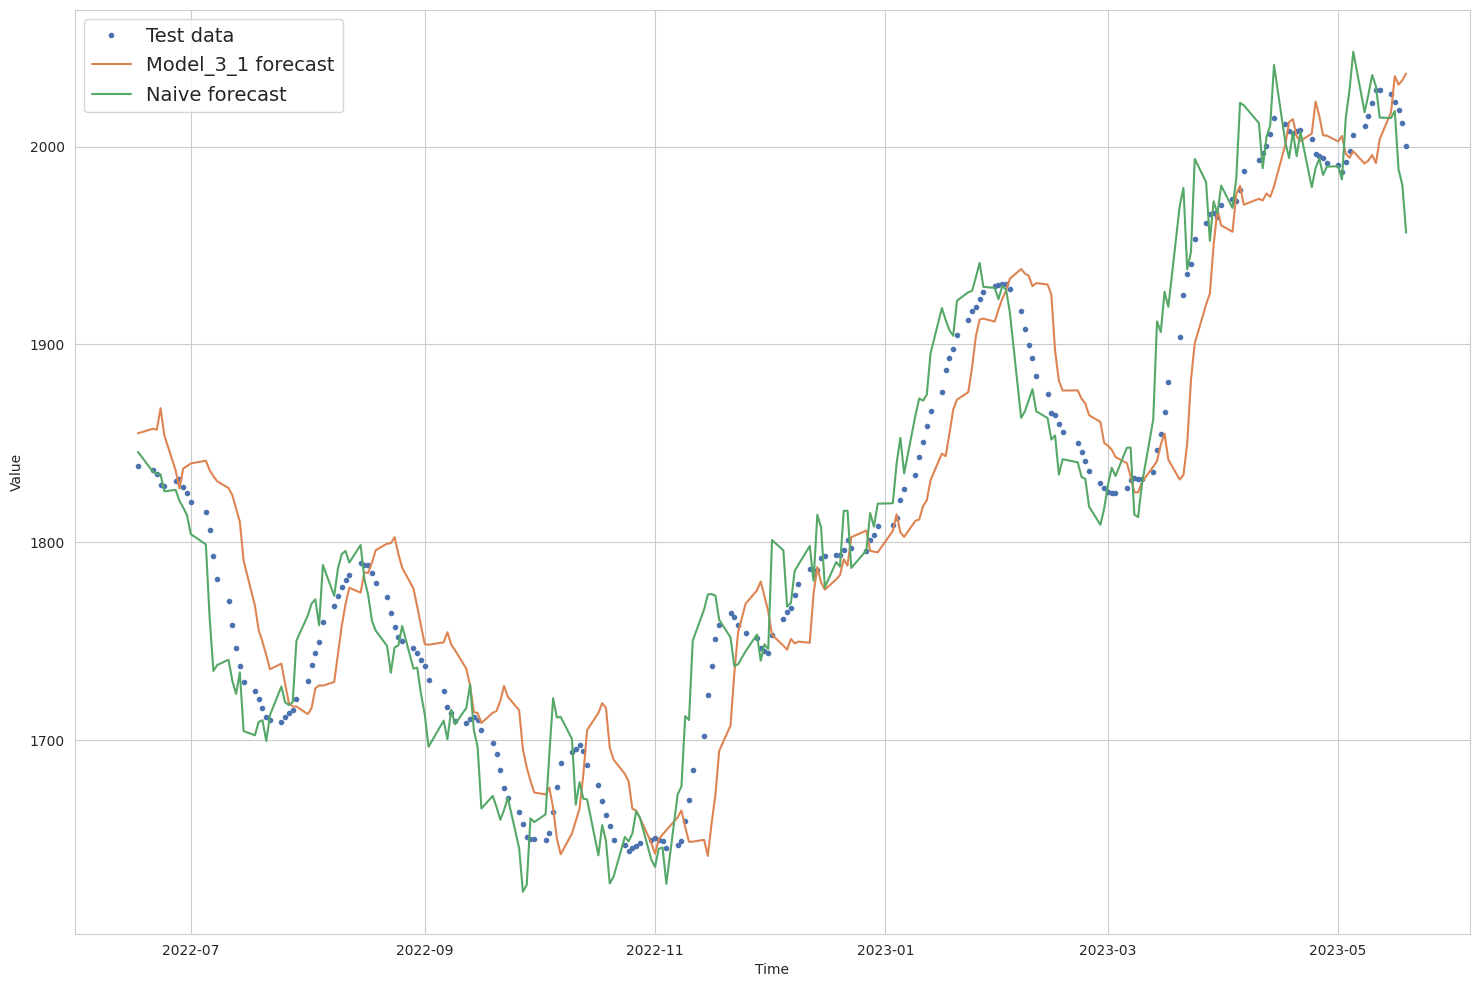

In [ ]:
# Visualise the differences. Observe that for Model_3_1 forecast and for the test data mean from the horizon was used
plt.figure(figsize=(18, 12))
plot_time_series(timesteps=X_test[-len(test_price_37_labels):], values=tf.reduce_mean(test_price_37_labels, axis=1), start=900,  format='.', label='Test data')
plot_time_series(timesteps=X_test[-len(test_price_37_labels):], values=tf.reduce_mean(model_3_1_best_preds, axis=1), start=900, format='-',  label='Model_3_1 forecast')
plot_time_series(timesteps=X_test[-len(test_price_37_labels):], values=naive_forecast[-len(test_price_37_labels):], start=900,  format='-', label='Naive forecast')

## 7. Model 4: Conv1D
HORIZON = 1
WINDOW_SIZE=7

In [ ]:
HORIZON = 1
WINDOW_SIZE=7

In [ ]:
# We use previously created train and test datasets
train_price_feats.shape, train_price_labels.shape, test_price_feats.shape, test_price_labels.shape

((4555, 7), (4555, 1), (1139, 7), (1139, 1))

In [ ]:
train_price_labels.shape

(4555, 1)

In [ ]:
from tensorflow.keras.layers import InputLayer, Conv1D, Lambda

### 7.1. Tune the parameters

In [ ]:
INPUT_SHAPE = train_price_feats.shape[1]

In [ ]:
OUTPUT_SHAPE = train_price_labels.shape[1]
OUTPUT_SHAPE

1

In [ ]:
train_price_feats.shape

(4528, 7)

In [ ]:
def create_conv_model(learning_rate=0.001, filters=7, kernel_size=7, strides=1, padding='causal', activation='relu'):
  model = Sequential()
  model.add(InputLayer( input_shape=(INPUT_SHAPE,)))
  model.add(Lambda(lambda x: tf.expand_dims(x, axis=1)))
  model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation))
  model.add(Dense(OUTPUT_SHAPE, activation='linear'))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=['mse', 'mape'])
  return model

In [ ]:
model_5 = KerasRegressor(build_fn=create_conv_model, verbose=0, learning_rate=0.001, activation='relu', filters=7, kernel_size=7, strides=1, padding='causal')

In [ ]:
params = {'activation': ["relu", "tanh", 'elu', 'sigmoid'],
          'batch_size': [16, 32, 64],
          'filters': [7, 16, 32, 64, 128],
          'kernel_size': [3, 7],
          'strides': [1, 3, 5, 7],
          'padding': [ 'same', 'causal'],
          'epochs': [50, 100],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [ ]:
from sklearn.metrics import mean_absolute_error
random_search_5 = RandomizedSearchCV(model_5,
                                   param_distributions = params,
                                   cv = KFold(3),
                                   n_iter=30,
                                   n_jobs=-1,
                                   scoring='neg_mean_squared_error',
                                   return_train_score=True,
                                   error_score='raise')

In [ ]:
random_search_results_5 = random_search_5.fit(train_price_feats, train_price_labels)

/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


In [ ]:
random_search_results_5.best_estimator_


KerasRegressor(
	model=None
	build_fn=<function create_conv_model at 0x7facdc3ec280>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	learning_rate=0.001
	activation=elu
	filters=128
	kernel_size=7
	strides=3
	padding=same
)

In [ ]:
# Create data frame with checked model parameters and lets fix model's number
random_search_4_df = pd.DataFrame(random_search_results_5.cv_results_['params'])

In [ ]:
# Add ranking columns
random_search_4_ranking_df = pd.DataFrame({
    'rank_test_score': random_search_results_5.cv_results_['rank_test_score'],
    'mean_test_score': random_search_results_5.cv_results_['mean_test_score'] ,
    'mean_train_score': random_search_results_5.cv_results_['mean_train_score']
})

In [ ]:
# Compute the difference between train and test scores
random_search_4_ranking_df['train_test_diff'] = random_search_4_ranking_df['mean_train_score'] - random_search_4_ranking_df['mean_test_score']

In [ ]:
# Create diff score ranking
random_search_4_ranking_df['diff_score'] = random_search_4_ranking_df['train_test_diff'].abs().rank(method='max')

In [ ]:
# Join parameter data df with ranking df
model_4_param_tuning_df = random_search_4_df.join(random_search_4_ranking_df)

**Since overfitting renders the model useless, to preserve good generalization capabilities we will sort by diff_score rank and then test_score rank.**

In [ ]:
model_4_param_tuning_df.sort_values(by=['diff_score', 'rank_test_score'])

strides padding  learning_rate  kernel_size  filters  epochs  batch_size  \
10        3  causal         0.0001            3       32     100          64   
14        1    same         0.0010            7      128      50          16   
20        3  causal         0.0010            7       64     100          32   
2         1  causal         0.0100            3       16      50          32   
6         3    same         0.0010            7      128     100          32   
27        1  causal         0.0010            7       16     100          16   
8         1  causal         0.0010            3       64      50          16   
7         5  causal         0.0010            3       16      50          64   
4         5    same         0.0001            7      128     100          32   
23        7    same         0.0100            3       16     100          32   
24        1  causal         0.0001            3       64     100          32   
0         5    same         0.0010            3        7      50          16   
11        3  causal         0.0010            3       16     100          32   
29        3    same         0.0001            3       64      50          32   
26        3    same         0.0001            7       16     100          32   
3         5    same         0.0010            3       64      50          64   
16        5    same         0.0100            7        7      50          32   
13        7    same         0.0010            7       16      50          64   
19        1  causal         0.0100            7        7      50          64   
21        7  causal         0.0100            7       16      50          32   
12        5  causal         0.0001            3       32      50          16   
9         7  causal         0.0010            7        7      50          32   
5         5  causal         0.0001            7       16      50          32   
18        3  causal         0.0010            3       32     100          32   
28        7    same         0.0100            7       16      50          32   
15        1    same         0.0010            3       64      50          32   
25        1    same         0.0010            7      128     100          64   
17        5    same         0.0010            7      128     100          32   
1         3    same         0.0100            3       64     100          64   
22        5    same         0.0100            7       64      50          32   

   activation  rank_test_score  mean_test_score  mean_train_score  \
10       relu               13    -2.474675e+02     -2.474864e+02   
14        elu                2    -1.796271e+02     -1.778554e+02   
20        elu                4    -1.851258e+02     -1.875009e+02   
2         elu                7    -2.056990e+02     -2.031239e+02   
6         elu                1    -1.762268e+02     -1.726614e+02   
27       relu                5    -1.911595e+02     -1.868641e+02   
8        relu                3    -1.817990e+02     -1.892007e+02   
7         elu               10    -2.185385e+02     -2.274778e+02   
4        relu                8    -2.097784e+02     -2.001029e+02   
23       relu               12    -2.425202e+02     -2.552540e+02   
24       relu                6    -1.958636e+02     -2.201908e+02   
0         elu               11    -2.250598e+02     -1.926847e+02   
11       relu                9    -2.112104e+02     -1.681389e+02   
29       tanh               27    -1.018911e+06     -1.018964e+06   
26       tanh               29    -1.046259e+06     -1.046375e+06   
3         elu               14    -4.228805e+02     -3.033035e+02   
16       relu               15    -4.288238e+02     -3.090943e+02   
13       tanh               25    -1.000348e+06     -1.000580e+06   
19       tanh               23    -7.550717e+05     -7.548075e+05   
21        elu               16    -1.340678e+03     -8.941029e+02   
12    sigmoid               28    -1.045560e+06     -1.044963e+06   
9    

We will use model of index number 11 (1st rank interms of loss and 4th in terms of not overfitting)

### 7.2. Build the model

In [ ]:
model_4_1 = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=1)),
  Conv1D(filters=16, kernel_size=7, strides=1, padding='same', activation='elu'),
  Dense(HORIZON, activation='linear')
], name='model_4_1_conv1d')

In [ ]:
model_4_1.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=['mse', 'mape']
)

In [ ]:
history_4_1 = model_4_1.fit(x=train_price_feats,
                        y=train_price_labels,
                        epochs=50,
                        verbose=1,
                        batch_size=16,
                        validation_data=(test_price_feats, test_price_labels),
                        callbacks=[create_model_checkpoint(model_name=model_4_1.name)])

Epoch 1/50
279/285 [============================>.] - ETA: 0s - loss: 56.9177 - mse: 22511.0098 - mape: 5.9929

285/285 [==============================] - 8s 7ms/step - loss: 56.2265 - mse: 22080.5293 - mape: 5.9149 - val_loss: 23.7051 - val_mse: 1072.0603 - val_mape: 1.3827
Epoch 2/50
285/285 [==============================] - 1s 4ms/step - loss: 15.5262 - mse: 518.0109 - mape: 1.6554 - val_loss: 26.4160 - val_mse: 1241.8317 - val_mape: 1.5487
Epoch 3/50
281/285 [============================>.] - ETA: 0s - loss: 15.3529 - mse: 499.3510 - mape: 1.6483

285/285 [==============================] - 2s 6ms/step - loss: 15.3897 - mse: 501.7126 - mape: 1.6532 - val_loss: 21.7015 - val_mse: 913.4468 - val_mape: 1.2631
Epoch 4/50
285/285 [==============================] - ETA: 0s - loss: 15.2944 - mse: 509.1227 - mape: 1.6219

285/285 [==============================] - 2s 6ms/step - loss: 15.2944 - mse: 509.1227 - mape: 1.6219 - val_loss: 21.4118 - val_mse: 878.9362 - val_mape: 1.2465
Epoch 5/50
285/285 [==============================] - 1s 3ms/step - loss: 14.2939 - mse: 436.7157 - mape: 1.5316 - val_loss: 22.0294 - val_mse: 887.3678 - val_mape: 1.2840
Epoch 6/50
285/285 [==============================] - 1s 3ms/step - loss: 13.8734 - mse: 408.9534 - mape: 1.4862 - val_loss: 26.7802 - val_mse: 1144.4684 - val_mape: 1.5668
Epoch 7/50
281/285 [============================>.] - ETA: 0s - loss: 13.4981 - mse: 397.7947 - mape: 1.4392

285/285 [==============================] - 2s 7ms/step - loss: 13.4752 - mse: 395.8647 - mape: 1.4382 - val_loss: 20.5140 - val_mse: 779.5794 - val_mape: 1.1952
Epoch 8/50
277/285 [============================>.] - ETA: 0s - loss: 13.2695 - mse: 381.6260 - mape: 1.4227

285/285 [==============================] - 2s 6ms/step - loss: 13.3026 - mse: 381.3564 - mape: 1.4260 - val_loss: 19.1203 - val_mse: 717.3657 - val_mape: 1.1135
Epoch 9/50
285/285 [==============================] - 1s 3ms/step - loss: 13.2736 - mse: 377.3067 - mape: 1.4268 - val_loss: 22.2981 - val_mse: 841.9241 - val_mape: 1.3026
Epoch 10/50
285/285 [==============================] - 1s 3ms/step - loss: 13.0091 - mse: 361.5507 - mape: 1.3876 - val_loss: 22.1599 - val_mse: 824.7718 - val_mape: 1.2949
Epoch 11/50
268/285 [===========================>..] - ETA: 0s - loss: 12.1894 - mse: 324.5623 - mape: 1.3100

285/285 [==============================] - 2s 6ms/step - loss: 12.1790 - mse: 323.7305 - mape: 1.3053 - val_loss: 17.7565 - val_mse: 619.8818 - val_mape: 1.0340
Epoch 12/50
285/285 [==============================] - 1s 4ms/step - loss: 11.9238 - mse: 312.7518 - mape: 1.2738 - val_loss: 19.0112 - val_mse: 648.4075 - val_mape: 1.1088
Epoch 13/50
283/285 [============================>.] - ETA: 0s - loss: 11.5307 - mse: 285.0224 - mape: 1.2300

285/285 [==============================] - 2s 6ms/step - loss: 11.5068 - mse: 284.2907 - mape: 1.2290 - val_loss: 16.8779 - val_mse: 560.2486 - val_mape: 0.9825
Epoch 14/50
271/285 [===========================>..] - ETA: 0s - loss: 11.4061 - mse: 285.7596 - mape: 1.2113

285/285 [==============================] - 2s 6ms/step - loss: 11.3479 - mse: 282.2731 - mape: 1.2052 - val_loss: 16.4624 - val_mse: 525.2101 - val_mape: 0.9577
Epoch 15/50
285/285 [==============================] - 1s 4ms/step - loss: 10.9612 - mse: 262.9113 - mape: 1.1747 - val_loss: 19.5080 - val_mse: 648.0895 - val_mape: 1.1397
Epoch 16/50
281/285 [============================>.] - ETA: 0s - loss: 10.7847 - mse: 259.3570 - mape: 1.1563

285/285 [==============================] - 2s 6ms/step - loss: 10.8071 - mse: 261.1325 - mape: 1.1570 - val_loss: 15.7766 - val_mse: 489.5285 - val_mape: 0.9179
Epoch 17/50
285/285 [==============================] - 1s 4ms/step - loss: 10.7200 - mse: 252.4548 - mape: 1.1473 - val_loss: 16.0661 - val_mse: 489.2107 - val_mape: 0.9353
Epoch 18/50
285/285 [==============================] - 1s 4ms/step - loss: 10.0921 - mse: 228.7028 - mape: 1.0848 - val_loss: 21.3298 - val_mse: 718.3401 - val_mape: 1.2488
Epoch 19/50
285/285 [==============================] - 1s 4ms/step - loss: 10.7969 - mse: 257.1044 - mape: 1.1502 - val_loss: 16.3125 - val_mse: 501.1887 - val_mape: 0.9523
Epoch 20/50
285/285 [==============================] - 1s 4ms/step - loss: 10.4977 - mse: 237.9241 - mape: 1.1287 - val_loss: 15.9104 - val_mse: 480.3874 - val_mape: 0.9283
Epoch 21/50
279/285 [============================>.] - ETA: 0s - loss: 9.8870 - mse: 219.6540 - mape: 1.0577

285/285 [==============================] - 2s 6ms/step - loss: 9.8892 - mse: 219.5142 - mape: 1.0562 - val_loss: 14.9336 - val_mse: 430.8824 - val_mape: 0.8684
Epoch 22/50
285/285 [==============================] - 1s 4ms/step - loss: 9.6293 - mse: 210.7325 - mape: 1.0285 - val_loss: 16.3507 - val_mse: 482.3914 - val_mape: 0.9533
Epoch 23/50
285/285 [==============================] - 1s 4ms/step - loss: 9.9784 - mse: 216.9801 - mape: 1.0720 - val_loss: 15.8636 - val_mse: 471.1358 - val_mape: 0.9262
Epoch 24/50
277/285 [============================>.] - ETA: 0s - loss: 9.5515 - mse: 204.1643 - mape: 1.0218

285/285 [==============================] - 2s 6ms/step - loss: 9.5566 - mse: 204.8573 - mape: 1.0199 - val_loss: 14.2343 - val_mse: 403.4400 - val_mape: 0.8282
Epoch 25/50
285/285 [==============================] - 1s 3ms/step - loss: 9.5201 - mse: 207.4603 - mape: 1.0176 - val_loss: 15.3941 - val_mse: 438.0620 - val_mape: 0.8964
Epoch 26/50
285/285 [==============================] - 1s 4ms/step - loss: 9.2730 - mse: 194.2117 - mape: 0.9948 - val_loss: 17.3605 - val_mse: 513.3036 - val_mape: 1.0139
Epoch 27/50
285/285 [==============================] - 1s 4ms/step - loss: 9.5227 - mse: 204.2932 - mape: 1.0117 - val_loss: 19.8494 - val_mse: 619.6235 - val_mape: 1.1621
Epoch 28/50
280/285 [============================>.] - ETA: 0s - loss: 9.1563 - mse: 188.2395 - mape: 0.9815

285/285 [==============================] - 2s 6ms/step - loss: 9.1697 - mse: 190.1903 - mape: 0.9827 - val_loss: 13.7494 - val_mse: 381.1452 - val_mape: 0.7997
Epoch 29/50
285/285 [==============================] - 1s 3ms/step - loss: 9.0288 - mse: 187.9626 - mape: 0.9621 - val_loss: 14.9364 - val_mse: 425.4545 - val_mape: 0.8711
Epoch 30/50
285/285 [==============================] - 1s 3ms/step - loss: 9.4167 - mse: 198.0751 - mape: 1.0078 - val_loss: 19.4527 - val_mse: 622.1603 - val_mape: 1.1417
Epoch 31/50
285/285 [==============================] - 1s 3ms/step - loss: 9.1798 - mse: 194.8250 - mape: 0.9794 - val_loss: 14.1124 - val_mse: 393.6347 - val_mape: 0.8219
Epoch 32/50
285/285 [==============================] - 1s 3ms/step - loss: 8.7680 - mse: 177.7266 - mape: 0.9338 - val_loss: 14.4374 - val_mse: 404.8698 - val_mape: 0.8415
Epoch 33/50
285/285 [==============================] - 1s 3ms/step - loss: 9.2546 - mse: 196.8532 - mape: 0.9845 - val_loss: 17.3115 - val_mse: 501.8949

285/285 [==============================] - 2s 6ms/step - loss: 9.1021 - mse: 187.3456 - mape: 0.9730 - val_loss: 13.3175 - val_mse: 361.3972 - val_mape: 0.7740
Epoch 35/50
285/285 [==============================] - 1s 3ms/step - loss: 9.1058 - mse: 189.6066 - mape: 0.9704 - val_loss: 21.3905 - val_mse: 712.5084 - val_mape: 1.2576
Epoch 36/50
285/285 [==============================] - 1s 3ms/step - loss: 9.2715 - mse: 195.8646 - mape: 0.9936 - val_loss: 15.1059 - val_mse: 415.0602 - val_mape: 0.8799
Epoch 37/50
285/285 [==============================] - 1s 4ms/step - loss: 9.3206 - mse: 195.5495 - mape: 0.9887 - val_loss: 15.7892 - val_mse: 439.6085 - val_mape: 0.9207
Epoch 38/50
285/285 [==============================] - 1s 4ms/step - loss: 9.0383 - mse: 186.6574 - mape: 0.9690 - val_loss: 14.7183 - val_mse: 413.4877 - val_mape: 0.8586
Epoch 39/50
285/285 [==============================] - 1s 4ms/step - loss: 8.9261 - mse: 180.5589 - mape: 0.9500 - val_loss: 14.7415 - val_mse: 414.2450

285/285 [==============================] - 2s 6ms/step - loss: 8.7754 - mse: 178.4419 - mape: 0.9385 - val_loss: 13.0415 - val_mse: 346.1840 - val_mape: 0.7574
Epoch 44/50
285/285 [==============================] - 1s 3ms/step - loss: 9.1719 - mse: 192.2782 - mape: 0.9737 - val_loss: 14.6811 - val_mse: 396.4953 - val_mape: 0.8547
Epoch 45/50
285/285 [==============================] - 1s 3ms/step - loss: 8.6822 - mse: 173.5311 - mape: 0.9249 - val_loss: 14.6041 - val_mse: 408.0379 - val_mape: 0.8521
Epoch 46/50
285/285 [==============================] - 1s 3ms/step - loss: 8.6405 - mse: 175.3604 - mape: 0.9196 - val_loss: 15.7853 - val_mse: 454.5439 - val_mape: 0.9229
Epoch 47/50
285/285 [==============================] - 1s 3ms/step - loss: 8.7431 - mse: 177.9484 - mape: 0.9299 - val_loss: 15.1124 - val_mse: 427.4049 - val_mape: 0.8827
Epoch 48/50
285/285 [==============================] - 1s 3ms/step - loss: 9.0157 - mse: 184.4453 - mape: 0.9641 - val_loss: 13.2620 - val_mse: 349.0165

In [ ]:
naive_result

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

In [ ]:
# Load best performing model
model_4_1_best = tf.keras.models.load_model('/content/model_experiments/model_4_1_conv1d')

In [ ]:
model_4_1_best_results = model_4_1_best.evaluate(test_price_feats, test_price_labels)

36/36 [==============================] - 0s 3ms/step - loss: 13.0415 - mse: 346.1841 - mape: 0.7574


In [ ]:
# Make predictions
model_4_1_best_preds = make_preds(model_4_1_best, test_price_feats)

len(model_4_1_best_preds), model_4_1_best_preds[:10], len(test_price_labels), test_price_labels[:10]

36/36 [==============================] - 0s 2ms/step


(1139,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1223.9999, 1212.3763, 1206.3063, 1201.2822, 1204.4532, 1209.9454,
        1218.0953, 1222.8534, 1221.4144, 1225.8248], dtype=float32)>,
 1139,
 array([[1206.40002441],
        [1201.30004883],
        [1199.19995117],
        [1207.90002441],
        [1212.80004883],
        [1220.80004883],
        [1223.09997559],
        [1219.        ],
        [1225.80004883],
        [1221.        ]]))

In [ ]:
model_4_1_best_preds.shape, model_4_1_best_preds.shape

(TensorShape([1139]), TensorShape([1139]))

In [ ]:
# Produce metrics for model_1_1_best
model_4_1_best_results = produce_metrics(tf.cast(test_price_labels, dtype=tf.float32), model_4_1_best_preds)

In [ ]:
model_4_1_best_results

{'mae': 237.64484,
 'mse': 92826.15,
 'rmse': 304.67383,
 'mape': 14.818308,
 'smape': 14.539459,
 'mase': 19.397629}

In [ ]:
model_3_1_best_results

{'mae': 24.654978,
 'mse': 1218.9873,
 'rmse': 34.913998,
 'mape': 1.4352645,
 'smape': 1.4327598,
 'mase': 2.010857}

In [ ]:
model_2_1_best_results

{'mae': 236.06375,
 'mse': 91610.24,
 'rmse': 302.67184,
 'mape': 14.703503,
 'smape': 14.413929,
 'mase': 19.229536}

In [ ]:
model_1_1_best_results

{'mae': 237.65211,
 'mse': 92826.016,
 'rmse': 304.6736,
 'mape': 14.81863,
 'smape': 14.539687,
 'mase': 19.398224}

In [ ]:
naive_result

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

In [ ]:
model_2_1_best_preds

<tf.Tensor: shape=(1135,), dtype=float32, numpy=
array([1210.383 , 1207.503 , 1221.957 , ..., 2024.3989, 2005.1835,
       1988.2991], dtype=float32)>

In [ ]:
model_4_1_best_preds

<tf.Tensor: shape=(1139,), dtype=float32, numpy=
array([1223.9999, 1212.3763, 1206.3063, ..., 2017.5936, 1996.6376,
       1988.2738], dtype=float32)>

In [ ]:
help(plot_time_series )

Help on function plot_time_series in module __main__:

plot_time_series(timesteps, values, format='.', start=0, end=None, label=None)
    Plots timesteps against values
    
    Parameters
    ----------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : index of timesteps series
    end : index of timesteps series
    label: label to show on plot values



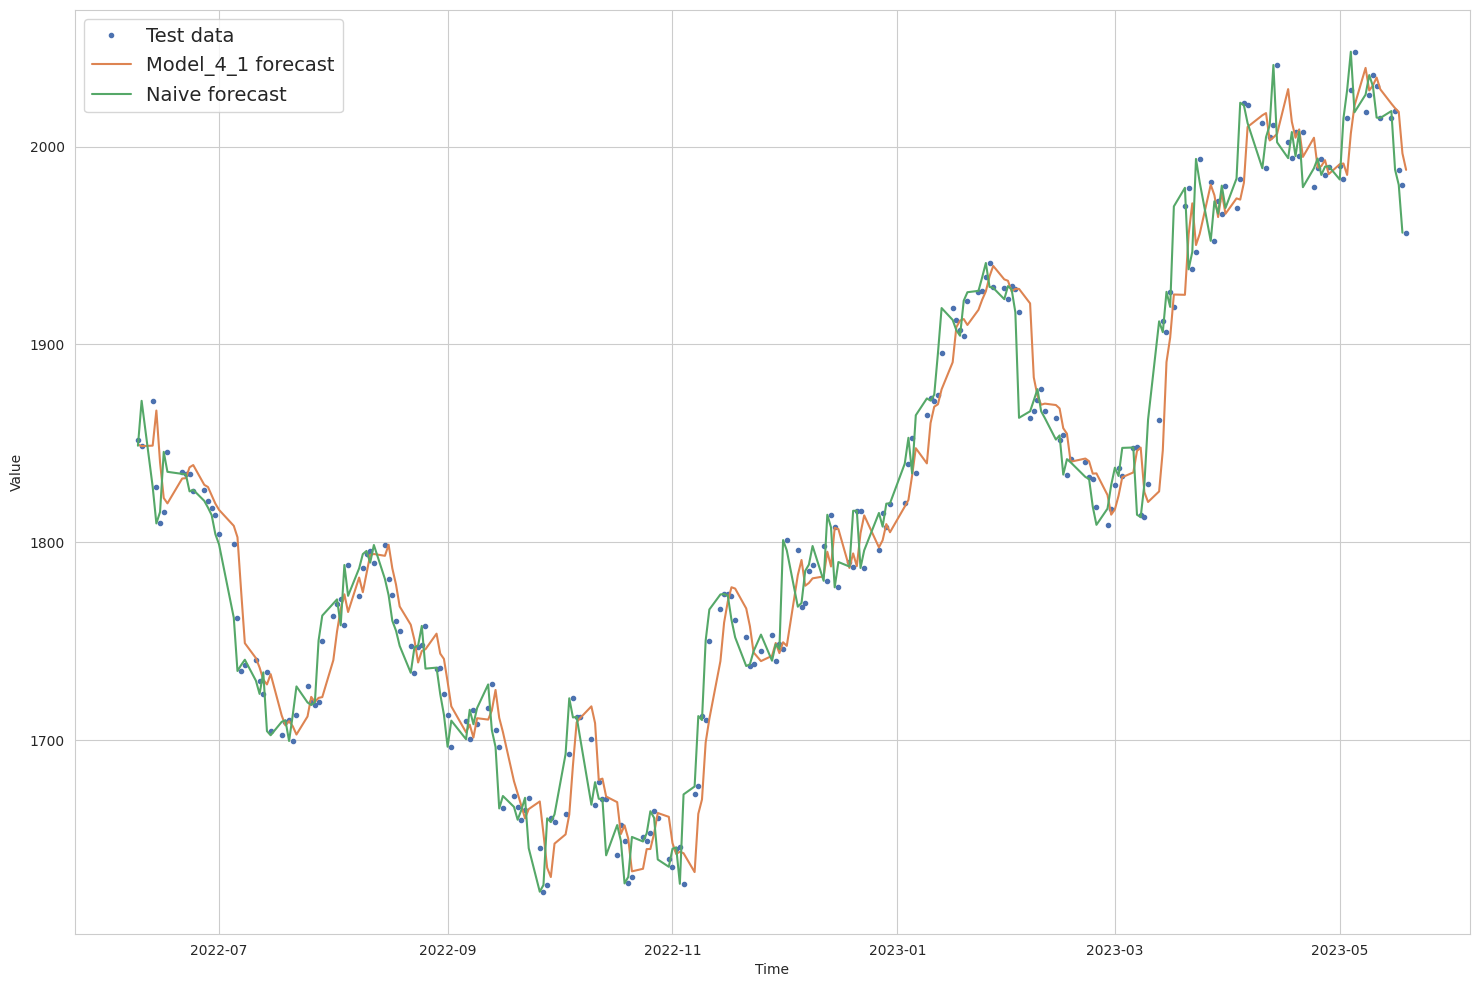

In [ ]:
# Visualise the differences. Observe that for Model_3_1 forecast and for the test data mean from the horizon was used
plt.figure(figsize=(18, 12))
plot_time_series(timesteps=X_test[-len(test_price_labels):], values=tf.reduce_mean(test_price_labels, axis=1), start=900,   format='.', label='Test data')
plot_time_series(timesteps=X_test[-len(test_price_labels):], values=model_4_1_best_preds,  format='-', start=900,  label='Model_4_1 forecast')
plot_time_series(timesteps=X_test[-len(test_price_labels):-1], values=naive_forecast[-len(test_price_labels)+1:], start=900,   format='-', label='Naive forecast')

In [ ]:
model_4_1.summary()

Model: "model_4_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 16)             800       
                                                                 
 dense_8 (Dense)             (None, 1, 1)              17        
                                                                 
Total params: 817
Trainable params: 817
Non-trainable params: 0
_________________________________________________________________


## 8. Model 5: RNN LSTM
HORIZON = 1
WINDOW_SIZE=7

In [ ]:
# Check the data
HORIZON, WINDOW_SIZE

(1, 7)

In [ ]:
# Define shape parameteres
INPUT_SHAPE = WINDOW_SIZE
OUTPUT_SHAPE = HORIZON

In [ ]:
from tensorflow.keras.layers import Input, LSTM

In [ ]:
import scikeras

In [ ]:
scikeras.__version__

'0.10.0'

### 8.1. Tune the hyperparameters

In [ ]:
# Define model creation function for Keras Regressor
def create_LSTM_model(learning_rate=0.001, units=32, dropout=0.2, activation='tanh', recurrent_activation='sigmoid'):
  model = Sequential()
  model.add(InputLayer( input_shape=(INPUT_SHAPE,)))
  model.add(Lambda(lambda x: tf.expand_dims(x, axis=1)))
  model.add(LSTM(
      units=units,
      activation=activation,
      recurrent_activation=recurrent_activation,
      dropout=dropout, ))
  model.add(Dense(OUTPUT_SHAPE, activation='linear'))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=['mse', 'mape'])
  return model

In [ ]:
model_5 = KerasRegressor(build_fn=create_LSTM_model,
                         verbose=0,
                         learning_rate=0.001,
                         activation='tanh',
                         units=16,
                         recurrent_activation='sigmoid',
                         dropout=0.2)

In [ ]:
params = {'activation': ["relu", "tanh", 'elu', 'sigmoid'],
          'recurrent_activation': ["relu", "tanh", 'elu', 'sigmoid'],
          'dropout': [0.2, 0.4, 0.6, 0.8],
          'batch_size': [16, 32, 64],
          'units': [16, 32, 64, 128],
          'epochs': [50, 100],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [ ]:
random_search_5 = RandomizedSearchCV(model_5,
                                   param_distributions = params,
                                   cv = KFold(3),
                                   n_iter=30,
                                   n_jobs=-1,
                                   scoring='neg_mean_squared_error',
                                   return_train_score=True,
                                   error_score='raise')

In [ ]:
random_search_results_5 = random_search_5.fit(train_price_feats, train_price_labels)

/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


In [ ]:
random_search_results_5

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   error_score='raise',
                   estimator=KerasRegressor(activation='tanh', build_fn=<function create_LSTM_model at 0x7facd81f58b0>, dropout=0.2, learning_rate=0.001, recurrent_activation='sigmoid', units=16, verbose=0),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh', 'elu',
                                                       'sigmoid'],
                                        'batch_size': [16, 32, 64],
                                        'dropout': [0.2, 0.4, 0.6, 0.8],
                                        'epochs': [50, 100],
                                        'learning_rate': [0.01, 0.001, 0.0001],
                                        'recurrent_activation': ['relu', 'tanh',
                                                                 'elu',
                                                                 'sigmoid'],
                                        'units': [16, 32, 64, 128]},
                   return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
# Create data frame with checked model parameters and lets fix model's number
random_search_5_df = pd.DataFrame(random_search_results_5.cv_results_['params'])

In [ ]:
# Add ranking columns
random_search_5_ranking_df = pd.DataFrame({
    'rank_test_score': random_search_results_5.cv_results_['rank_test_score'],
    'mean_test_score': random_search_results_5.cv_results_['mean_test_score'] ,
    'mean_train_score': random_search_results_5.cv_results_['mean_train_score']
})

In [ ]:
# Compute the difference between train and test scores
random_search_5_ranking_df['train_test_diff'] = random_search_5_ranking_df['mean_train_score'] - random_search_5_ranking_df['mean_test_score']

In [ ]:
# Create diff score ranking
random_search_5_ranking_df['diff_score'] = random_search_5_ranking_df['train_test_diff'].abs().rank(method='max')

In [ ]:
# Join parameter data df with ranking df
model_5_param_tuning_df = random_search_5_df.join(random_search_5_ranking_df)

**Since overfitting renders the model useless, to preserve good generalization capabilities we will sort by diff_score rank and then test_score rank.**

In [ ]:
model_5_param_tuning_df.sort_values(by=['diff_score', 'rank_test_score'])

units recurrent_activation  learning_rate  epochs  dropout  batch_size  \
7      16                 relu         0.0100     100      0.6          16   
15     32                 tanh         0.0001     100      0.4          32   
26     16                 tanh         0.0001     100      0.2          16   
21     32                 relu         0.0100      50      0.2          16   
10    128                  elu         0.0001     100      0.6          64   
4      16              sigmoid         0.0010     100      0.2          64   
14     64                 relu         0.0010     100      0.2          32   
20    128                  elu         0.0010      50      0.2          16   
28     32              sigmoid         0.0001      50      0.6          32   
12     32              sigmoid         0.0010     100      0.2          16   
1      16                 relu         0.0001     100      0.4          16   
5      16              sigmoid         0.0100     100      0.6          32   
0      64              sigmoid         0.0001     100      0.8          16   
11     64              sigmoid         0.0001     100      0.2          32   
6      16                  elu         0.0010      50      0.2          32   
13    128                 relu         0.0001      50      0.8          16   
9      64                 relu         0.0010     100      0.2          64   
2      64                 tanh         0.0100     100      0.2          64   
19    128                 relu         0.0100      50      0.2          64   
29     64                  elu         0.0010     100      0.8          64   
18     32              sigmoid         0.0010      50      0.6          16   
22    128                 tanh         0.0100     100      0.8          16   
27     32                 tanh         0.0100      50      0.8          16   
24     16                 relu         0.0100      50      0.4          16   
25     16              sigmoid         0.0100     100      0.6          16   
16    128                  elu         0.0100     100      0.4          64   
8      16                 relu         0.0001      50      0.8          16   
3      32              sigmoid         0.0100     100      0.8          64   
23    128                 tanh         0.0100     100      0.2          16   
17     32                  elu         0.0001     100      0.8          64   

   activation  rank_test_score  mean_test_score  mean_train_score  \
7        relu               23    -7.594069e+05     -7.594573e+05   
15    sigmoid               28    -1.037493e+06     -1.037675e+06   
26    sigmoid               27    -1.037296e+06     -1.037053e+06   
21       tanh                6    -4.384182e+04     -4.344659e+04   
10       tanh               15    -3.871782e+05     -3.876177e+05   
4        relu                4    -4.128851e+04     -4.081480e+04   
14       tanh                7    -4.410585e+04     -4.344616e+04   
20       tanh                8    -4.442466e+04     -4.521748e+04   
28       tanh               29    -1.064295e+06     -1.065204e+06   
12        elu                3    -4.109205e+04     -4.226700e+04   
1     sigmoid               11    -1.734542e+05     -1.720765e+05   
5        relu               14    -3.726517e+05     -3.712440e+05   
0        tanh               25    -1.002062e+06     -1.004686e+06   
11       tanh               26    -1.007462e+06     -1.010408e+06   
6         elu                5    -4.312487e+04     -4.656063e+04   
13    sigmoid               21    -7.423848e+05     -7.384677e+05   
9     sigmoid                9    -4.551448e+04     -4.150421e+04   
2        relu                2    -3.978848e+04     -4.391485e+04   
19       tanh                1    -3.483713e+04     -3.930626e+04   
29       tanh               19    -6.911439e+05     -6.721235e+05   
18       tanh               20    -7.161920e+05     -7.363358e+05   
22        elu               18    -6.764920e+05     -6.548596e+05  

### 8.2. Build the model

In [ ]:
# Build a LSTM model using functional API

inputs = Input(shape=(WINDOW_SIZE))
x = Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = LSTM(128, return_sequences=True)(x)
x = LSTM(128, activation='relu')(x)
# x = Dense(32, activation='relu')(x)
outputs = Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_5_LSTM')

In [ ]:
# Compile the model
model_5.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mse', 'mape']
)

In [ ]:
# Fit the model
history_5 = model_5.fit(x=train_price_feats,
                        y=train_price_labels,
                        epochs=100,
                        verbose=1,
                        batch_size=16,
                        validation_data=(test_price_feats, test_price_labels),
                        callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
285/285 [==============================] - 6s 12ms/step - loss: 72.7349 - mse: 42607.2344 - mape: 7.6349 - val_loss: 18.9379 - val_mse: 697.6622 - val_mape: 1.1025
Epoch 2/100
285/285 [==============================] - 1s 5ms/step - loss: 12.8897 - mse: 358.0318 - mape: 1.3756 - val_loss: 22.6469 - val_mse: 866.8372 - val_mape: 1.3242
Epoch 3/100
285/285 [==============================] - 1s 5ms/step - loss: 12.8339 - mse: 356.2780 - mape: 1.3757 - val_loss: 19.3135 - val_mse: 691.3312 - val_mape: 1.1260
Epoch 4/100
285/285 [==============================] - 3s 11ms/step - loss: 12.6127 - mse: 345.1873 - mape: 1.3419 - val_loss: 18.0221 - val_mse: 639.3160 - val_mape: 1.0490
Epoch 5/100
285/285 [==============================] - 1s 5ms/step - loss: 12.4752 - mse: 334.3956 - mape: 1.3366 - val_loss: 21.0253 - val_mse: 762.0807 - val_mape: 1.2288
Epoch 6/100
285/285 [==============================] - 2s 5ms/step - loss: 12.0908 - mse: 311.6752 - mape: 1.2978 - val_loss: 18.09

In [ ]:
model_5_best = tf.keras.models.load_model('/content/model_experiments/model_5_LSTM')

### 8.3. Evaluate the model

In [ ]:
# Make predictions
model_5_best_preds = make_preds(model_5_best, test_price_feats)

36/36 [==============================] - 0s 2ms/step


In [ ]:
# Produce metrics for model_1_1_best
model_5_best_results = produce_metrics(tf.cast(test_price_labels, dtype=tf.float32), model_5_best_preds)

ValueError: ignored

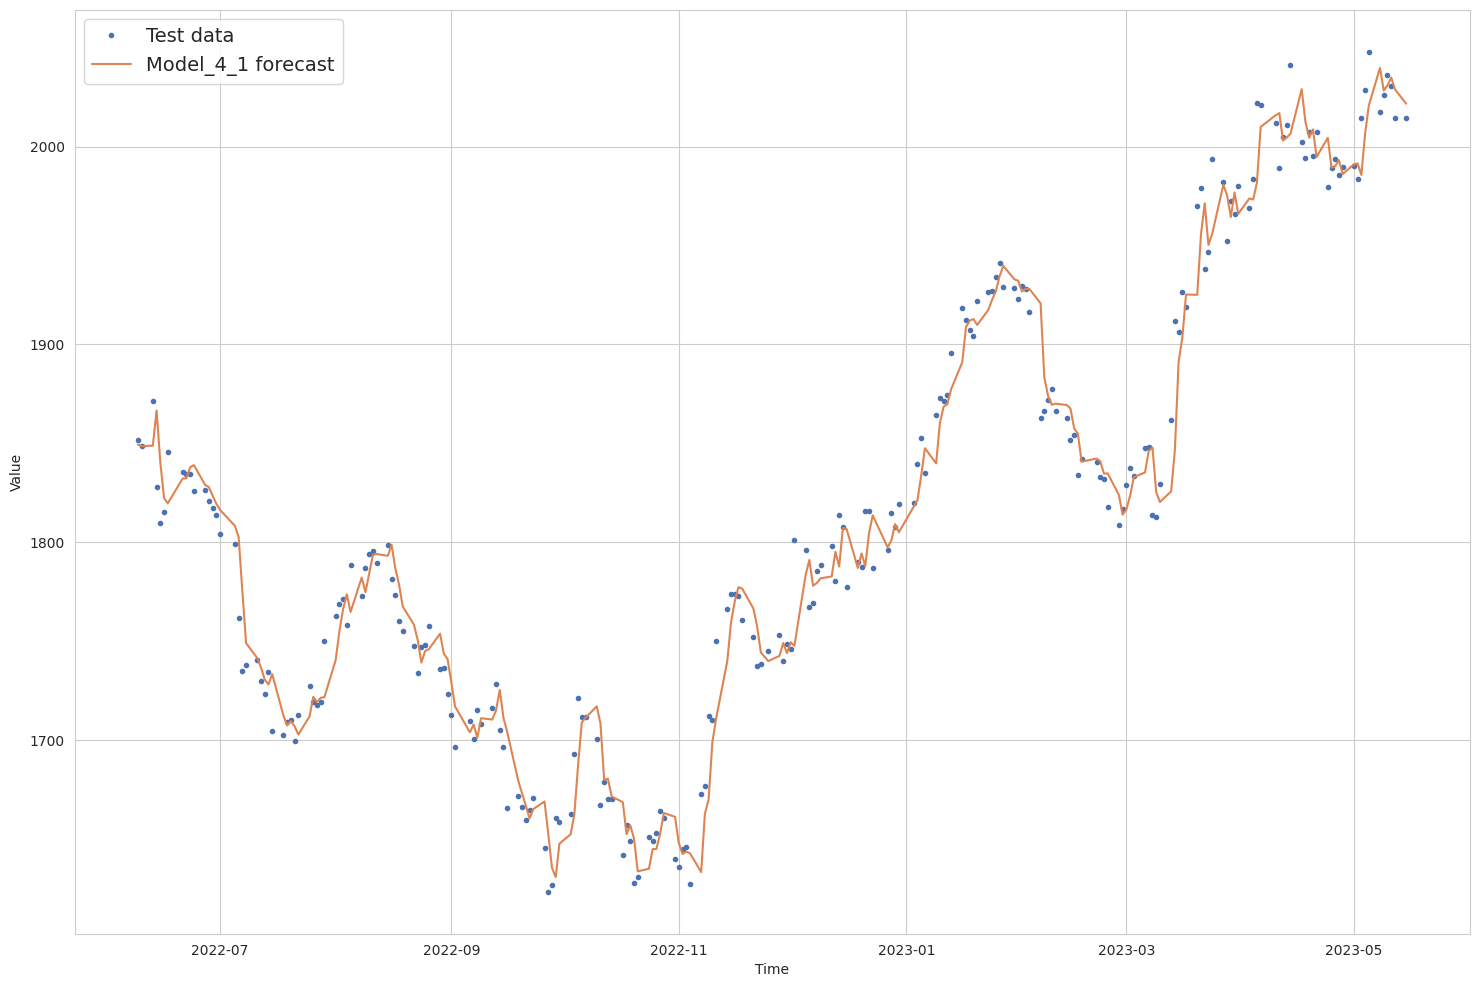

In [ ]:
# Visualise the differences. Observe that for Model_3_1 forecast and for the test data mean from the horizon was used
plt.figure(figsize=(18, 12))
plot_time_series(timesteps=X_test[-len(test_price_labels):-2], values=tf.reduce_mean(test_price_labels, axis=1)[:-2], start=900, end=-2,  format='.', label='Test data')
plot_time_series(timesteps=X_test[-len(test_price_labels):-2], values=model_4_1_best_preds[:-2],  format='-', start=900, end=-2,  label='Model_4_1 forecast')
plot_time_series(timesteps=X_test[-len(test_price_labels):-2], values=naive_forecast[-len(test_price_labels)-1:-2], start=900, end=-2,   format='-', label='Naive forecast')

## 9. Create multivariate dataset
Let's choose from available indices that are known to show correlation to the price of gold.

As it is shown in the literature Gold does not hold strong correlation with macroeconomic and stock indices. This is why the correlation with crude oil price and real interest rate should be taken into account.

### 9.1. Get additional data to feed the model

#### 9.1.1. Crude oil price

In [ ]:
df_crude_oil = yf.download('CL=F', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df_crude_oil.head(-10)

Open       High        Low      Close  Volume
Date                                                          
2000-08-23  31.950001  32.799999  31.950001  32.049999   79385
2000-08-24  31.900000  32.240002  31.400000  31.629999   72978
2000-08-25  31.700001  32.099998  31.320000  32.049999   44601
2000-08-28  32.040001  32.919998  31.860001  32.869999   46770
2000-08-29  32.820000  33.029999  32.560001  32.720001   49131
...               ...        ...        ...        ...     ...
2023-05-01  76.660004  76.690002  74.529999  75.660004  215017
2023-05-02  75.760002  76.110001  71.419998  71.660004  417820
2023-05-03  71.559998  71.790001  67.949997  68.599998  490523
2023-05-04  68.160004  69.839996  63.639999  68.559998  412495
2023-05-05  68.699997  71.809998  68.480003  71.339996  330585

[5702 rows x 5 columns]

In [ ]:
CRUDE_OIL_object = yf.Ticker('CL=F')

In [ ]:
CRUDE_OIL_object.fast_info['currency']

'USD'

##### 9.1.1.2. Compute covariance of the two indices.

In [ ]:
# Create a time series with gold price
GOLD_CLOSE_ds = df.Close
GOLD_CLOSE_ds

Date
2000-08-30     273.899994
2000-08-31     278.299988
2000-09-01     277.000000
2000-09-05     275.799988
2000-09-06     274.200012
                 ...     
2023-05-15    2018.000000
2023-05-16    1988.400024
2023-05-17    1980.699951
2023-05-18    1956.500000
2023-05-19    1978.699951
Name: Close, Length: 5702, dtype: float64

In [ ]:
GOLD_CLOSE_df = pd.DataFrame(GOLD_CLOSE_ds)
GOLD_CLOSE_df.head(3)

Close
Date                  
2000-08-30  273.899994
2000-08-31  278.299988
2000-09-01  277.000000

In [ ]:
# Create a time series with crude oil price
CRUDE_OIL_CLOSE_ds = df_crude_oil.Close
CRUDE_OIL_CLOSE_ds

Date
2000-08-23    32.049999
2000-08-24    31.629999
2000-08-25    32.049999
2000-08-28    32.869999
2000-08-29    32.720001
                ...    
2023-05-15    71.110001
2023-05-16    70.860001
2023-05-17    72.830002
2023-05-18    71.860001
2023-05-19    71.550003
Name: Close, Length: 5712, dtype: float64

In [ ]:
CRUDE_OIL_CLOSE_df = pd.DataFrame(CRUDE_OIL_CLOSE_ds)

In [ ]:
CRUDE_GOLD_df = CRUDE_OIL_CLOSE_df.join(GOLD_CLOSE_df, how='left', lsuffix='OIL', rsuffix='GOLD')

In [ ]:
CRUDE_GOLD_df.head(7)

CloseOIL   CloseGOLD
Date                             
2000-08-23  32.049999         NaN
2000-08-24  31.629999         NaN
2000-08-25  32.049999         NaN
2000-08-28  32.869999         NaN
2000-08-29  32.720001         NaN
2000-08-30  33.400002  273.899994
2000-08-31  33.099998  278.299988

In [ ]:
(CRUDE_GOLD_df.CloseGOLD[CRUDE_GOLD_df.CloseGOLD.isna() == True])

Date
2000-08-23   NaN
2000-08-24   NaN
2000-08-25   NaN
2000-08-28   NaN
2000-08-29   NaN
2005-03-30   NaN
2005-04-28   NaN
2005-06-29   NaN
2006-11-27   NaN
2018-01-29   NaN
2022-06-20   NaN
Name: CloseGOLD, dtype: float64

In [ ]:
np.cov(CRUDE_GOLD_df.dropna().CloseGOLD, CRUDE_GOLD_df.dropna().CloseOIL)

array([[269559.52459827,   6950.64427049],
       [  6950.64427049,    659.15215783]])

In [ ]:
# Create percentage change series for each Close value
CRUDE_GOLD_df['pctOIL'] = CRUDE_GOLD_df.CloseOIL.pct_change()
CRUDE_GOLD_df['pctGOLD'] = CRUDE_GOLD_df.CloseGOLD.pct_change()

In [ ]:
CRUDE_GOLD_df.shape

(5712, 4)

In [ ]:
CRUDE_GOLD_df.head(7)

CloseOIL   CloseGOLD    pctOIL   pctGOLD
Date                                                 
2000-08-23  32.049999         NaN       NaN       NaN
2000-08-24  31.629999         NaN -0.013105       NaN
2000-08-25  32.049999         NaN  0.013279       NaN
2000-08-28  32.869999         NaN  0.025585       NaN
2000-08-29  32.720001         NaN -0.004563       NaN
2000-08-30  33.400002  273.899994  0.020782       NaN
2000-08-31  33.099998  278.299988 -0.008982  0.016064

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler_GOLD = StandardScaler()
scaledGOLD = scaler_GOLD.fit_transform(CRUDE_GOLD_df.CloseGOLD.to_numpy().reshape(-1, 1))
scaledGOLD.shape

(5712, 1)

In [ ]:
scaler_OLI = StandardScaler()
scaledOIL = scaler_OLI.fit_transform(CRUDE_GOLD_df.CloseOIL.to_numpy().reshape(-1, 1))
scaledOIL.shape

(5712, 1)

In [ ]:
CRUDE_GOLD_df['CloseOIL_std'] = scaledOIL
CRUDE_GOLD_df['CloseGOLD_std'] = scaledGOLD

In [ ]:
CRUDE_GOLD_df.head(7)

CloseOIL   CloseGOLD    pctOIL   pctGOLD  CloseOIL_std  \
Date                                                                  
2000-08-23  32.049999         NaN       NaN       NaN     -1.237056   
2000-08-24  31.629999         NaN -0.013105       NaN     -1.253416   
2000-08-25  32.049999         NaN  0.013279       NaN     -1.237056   
2000-08-28  32.869999         NaN  0.025585       NaN     -1.205115   
2000-08-29  32.720001         NaN -0.004563       NaN     -1.210958   
2000-08-30  33.400002  273.899994  0.020782       NaN     -1.184470   
2000-08-31  33.099998  278.299988 -0.008982  0.016064     -1.196156   

            CloseGOLD_std  
Date                       
2000-08-23            NaN  
2000-08-24            NaN  
2000-08-25            NaN  
2000-08-28            NaN  
2000-08-29            NaN  
2000-08-30      -1.563768  
2000-08-31      -1.555292

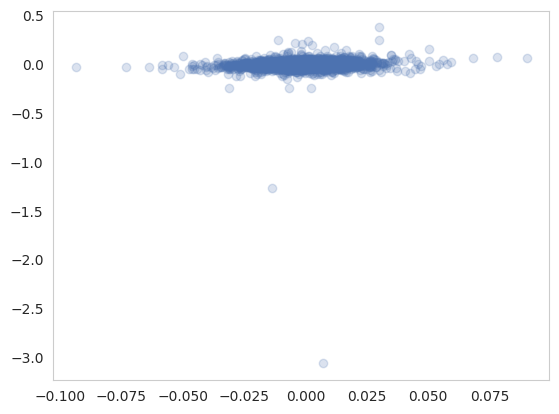

In [ ]:
plt.scatter(CRUDE_GOLD_df.pctGOLD, CRUDE_GOLD_df.pctOIL, alpha=.2)

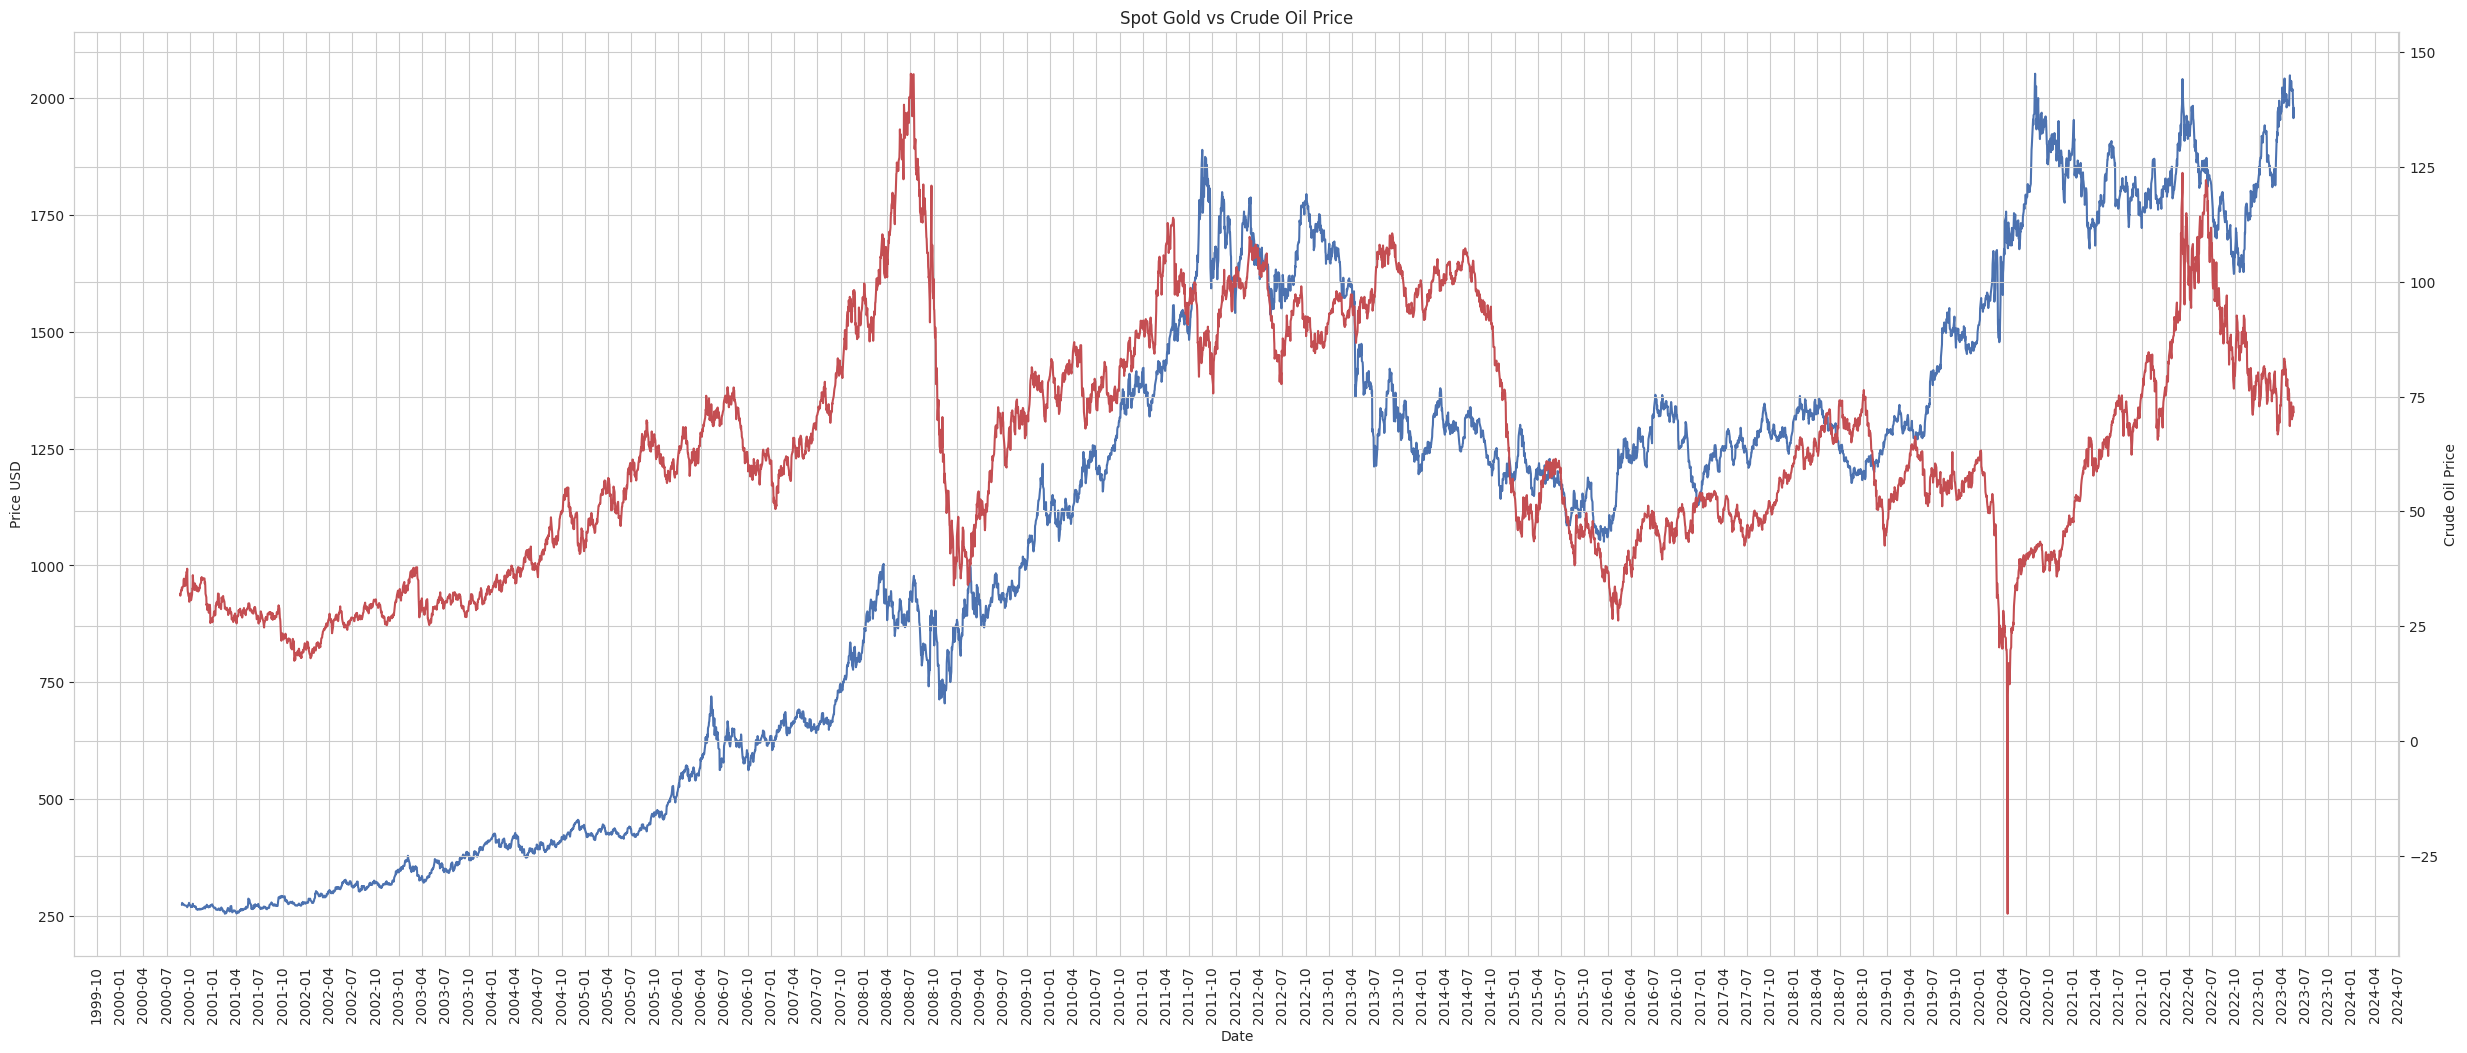

In [ ]:
sns.set_style('whitegrid')
sns.set_palette('deep')
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots()
fig.set_size_inches(30, 12)
plt.title('Spot Gold vs Crude Oil Price')
sns.lineplot(x='Date', y='CloseGOLD', data=CRUDE_GOLD_df.reset_index(), ax=ax, color='b')
ax.set_ylabel('Price USD')

ax2 = ax.twinx()

axlocator = matplotlib.dates.MonthLocator(bymonth=[1, 4, 7,10])
axformatter = matplotlib.dates.DateFormatter(fmt='%Y-%m')


ax.xaxis.set_major_locator(axlocator)
ax.xaxis.set_major_formatter(axformatter)
ax.tick_params(axis='x', which='major', labelrotation=90)

sns.lineplot(x='Date', y='CloseOIL', data=CRUDE_GOLD_df.reset_index(), ax=ax2, color='r')
ax2.set_ylabel('Crude Oil Price')

plt.show()

#### 9.1.2. Real interest rates
(Data was downloaded from: https://fred.stlouisfed.org/ )


In [ ]:
# Load the data
RIR_10Y_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bullion Predict data/REAINTRATREARAT10Y.csv')

In [ ]:
RIR_10Y_df.head()

DATE  REAINTRATREARAT10Y
0  1982-01-01            7.623742
1  1982-02-01            7.656648
2  1982-03-01            7.128993
3  1982-04-01            7.408347
4  1982-05-01            7.320041

In [ ]:
# Transform DATE column to datetime
RIR_10Y_df.DATE = RIR_10Y_df.DATE.astype('datetime64')

<Axes: xlabel='DATE'>

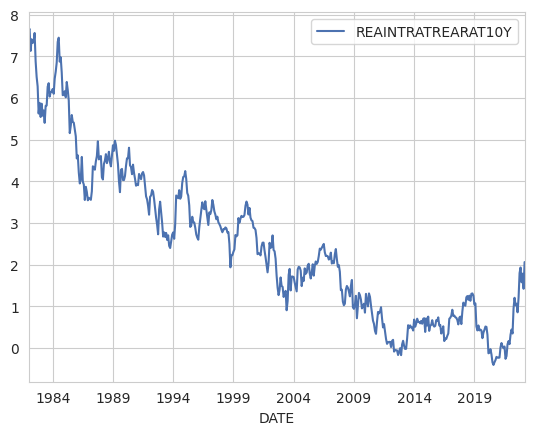

In [ ]:
RIR_10Y_df.plot(x='DATE', y='REAINTRATREARAT10Y')

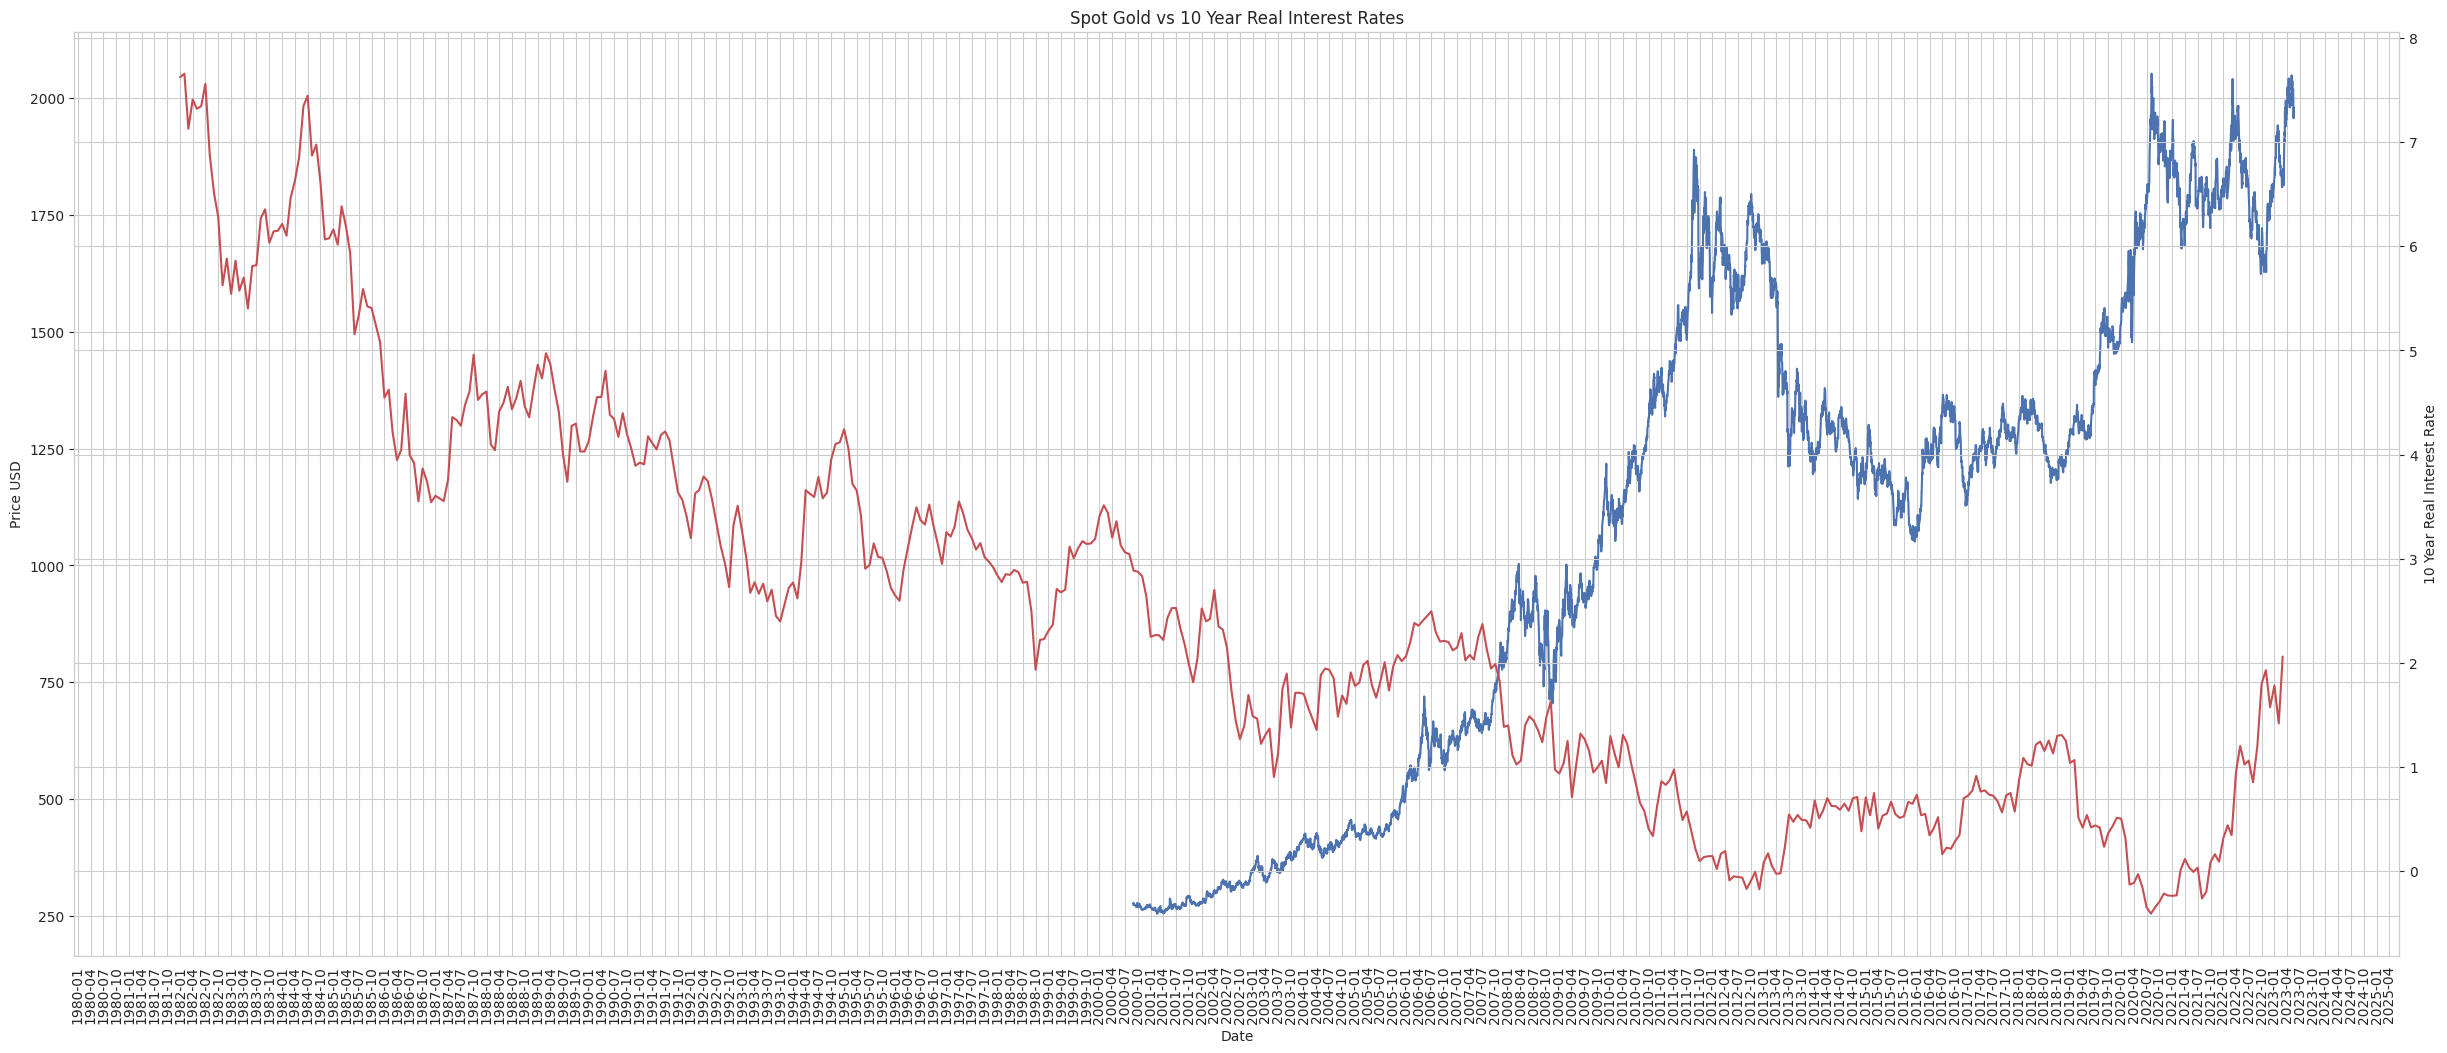

In [ ]:
sns.set_style('whitegrid')
sns.set_palette('deep')
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots()
fig.set_size_inches(30, 12)
plt.title('Spot Gold vs 10 Year Real Interest Rates')
sns.lineplot(x='Date', y='Close', data=gold_close_df.reset_index(), ax=ax, color='b')
ax.set_ylabel('Price USD')

ax2 = ax.twinx()

axlocator = matplotlib.dates.MonthLocator(bymonth=[1, 4, 7,10])
axformatter = matplotlib.dates.DateFormatter(fmt='%Y-%m')


ax.xaxis.set_major_locator(axlocator)
ax.xaxis.set_major_formatter(axformatter)
ax.tick_params(axis='x', which='major', labelrotation=90)

sns.lineplot(x=pd.to_datetime(RIR_10Y_df.DATE), y='REAINTRATREARAT10Y',  data=RIR_10Y_df, ax=ax2, color='r')
ax2.set_ylabel('10 Year Real Interest Rate')

plt.show()

In [ ]:
# Load the data
RIR_1Y_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bullion Predict data/REAINTRATREARAT1YE.csv')

In [ ]:
RIR_1Y_df.shape

(495, 2)

In [ ]:
RIR_1Y_df.DATE = RIR_1Y_df.DATE.astype('datetime64')

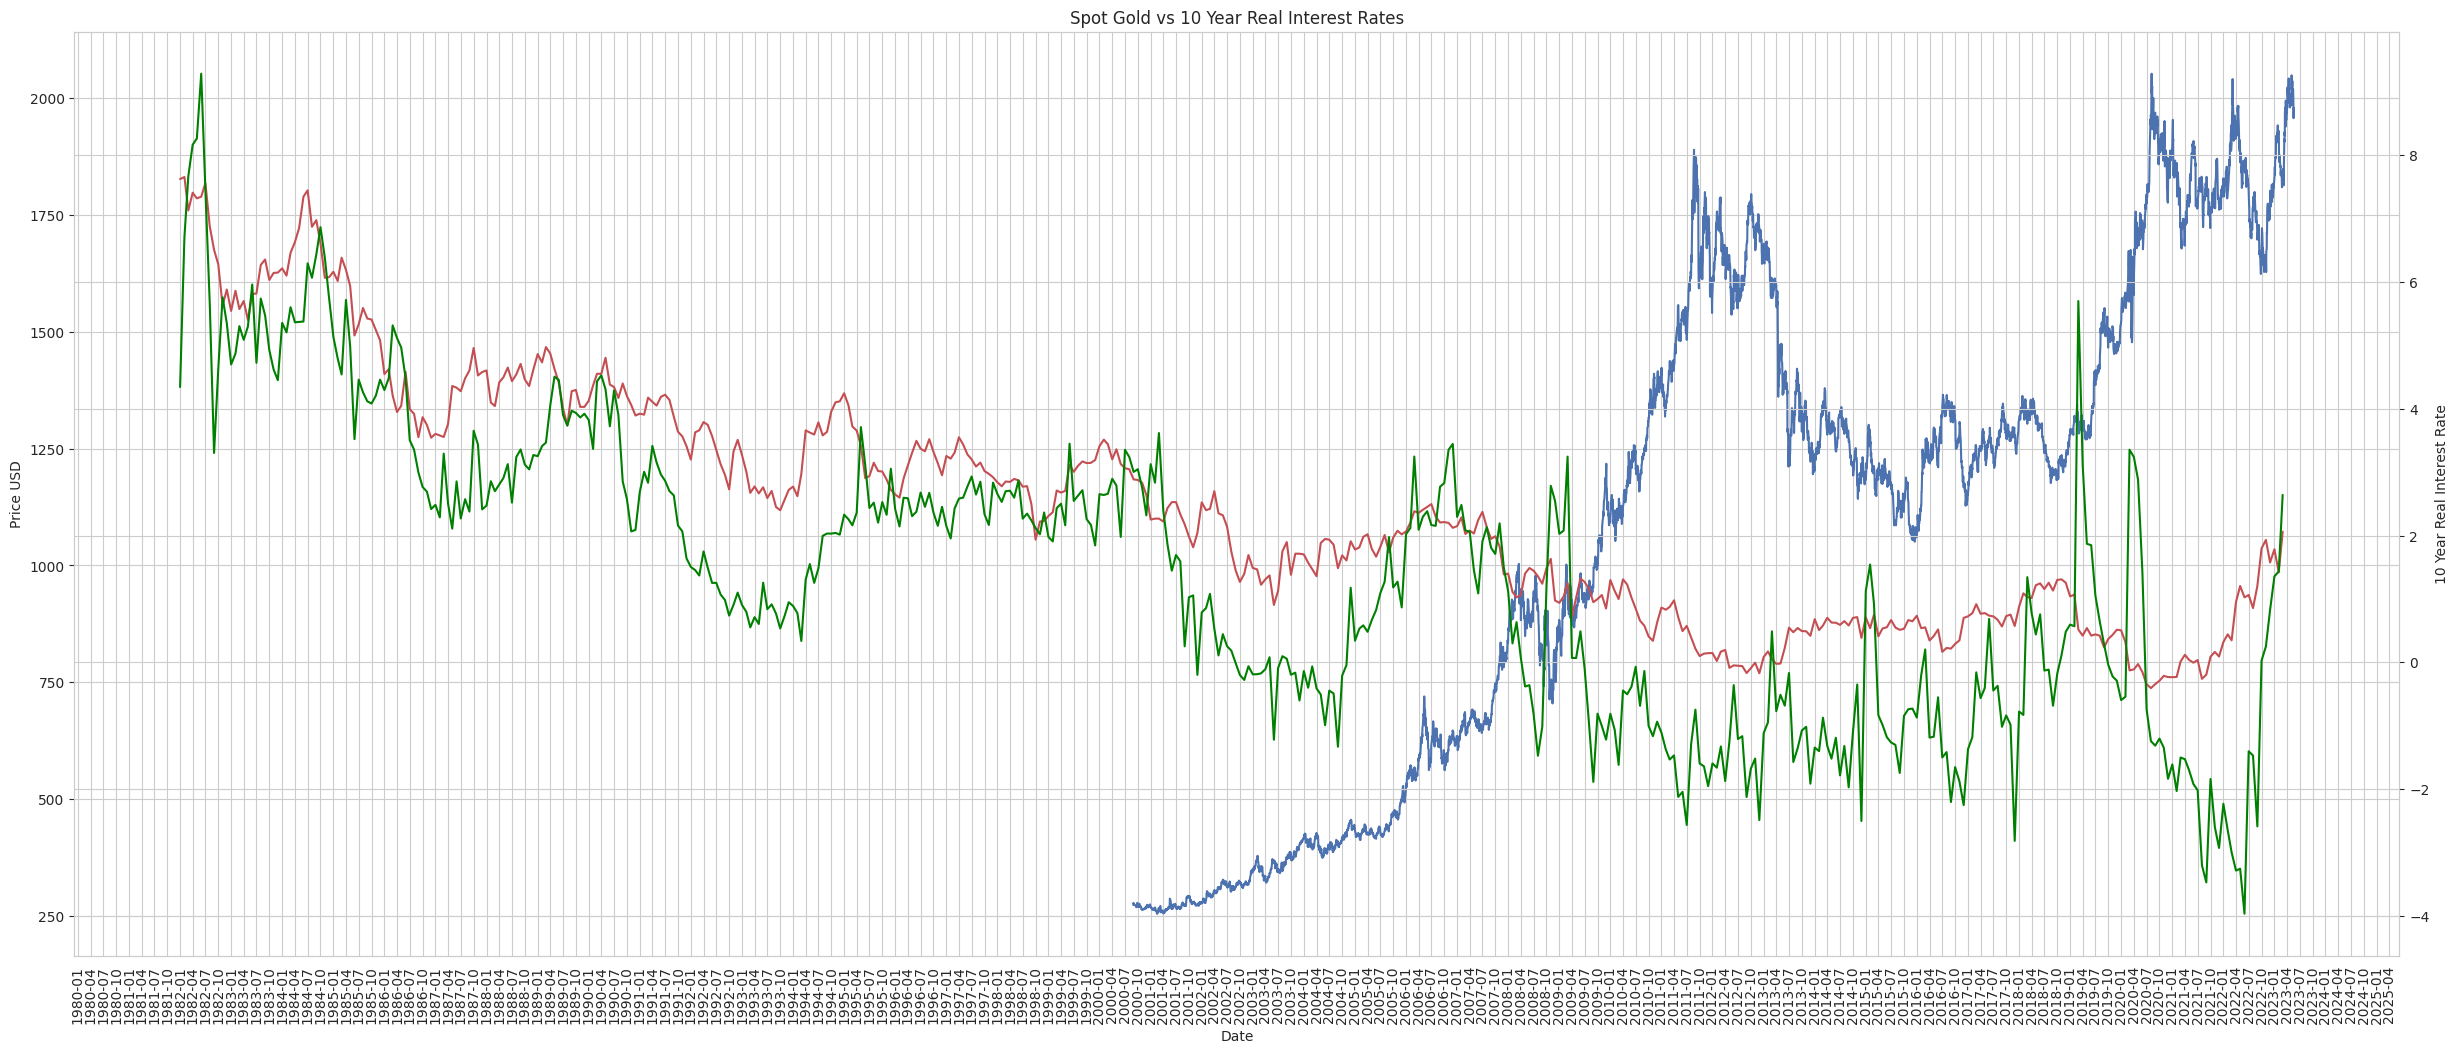

In [ ]:
sns.set_style('whitegrid')
sns.set_palette('deep')
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots()
fig.set_size_inches(30, 12)
plt.title('Spot Gold vs 10 Year Real Interest Rates')
sns.lineplot(x='Date', y='Close', data=gold_close_df.reset_index(), ax=ax, color='b')
ax.set_ylabel('Price USD')

ax2 = ax.twinx()

axlocator = matplotlib.dates.MonthLocator(bymonth=[1, 4, 7,10])
axformatter = matplotlib.dates.DateFormatter(fmt='%Y-%m')


ax.xaxis.set_major_locator(axlocator)
ax.xaxis.set_major_formatter(axformatter)
ax.tick_params(axis='x', which='major', labelrotation=90)

sns.lineplot(x=pd.to_datetime(RIR_10Y_df.DATE), y='REAINTRATREARAT10Y',  data=RIR_10Y_df, ax=ax2, color='r')
ax2.set_ylabel('10 Year Real Interest Rate')
sns.lineplot(x=pd.to_datetime(RIR_1Y_df.DATE), y='REAINTRATREARAT1YE',  data=RIR_1Y_df, ax=ax2, color='green')


plt.show()

#### 9.1.3. VIX index

In [ ]:
vix = yf.Ticker("^VIX")

In [ ]:
VIX_df = yf.download('^VIX', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
VIX_df.shape, VIX_df.head(3)

((8411, 5),
                  Open       High        Low      Close  Volume
 Date                                                          
 1990-01-02  17.240000  17.240000  17.240000  17.240000       0
 1990-01-03  18.190001  18.190001  18.190001  18.190001       0
 1990-01-04  19.219999  19.219999  19.219999  19.219999       0)

In [ ]:
VIX_CLOSE_df = pd.DataFrame(VIX_df['Close'].rename('CloseVIX'))

In [ ]:
VIX_CLOSE_df

CloseVIX
Date                 
1990-01-02  17.240000
1990-01-03  18.190001
1990-01-04  19.219999
1990-01-05  20.110001
1990-01-08  20.260000
...               ...
2023-05-15  17.120001
2023-05-16  17.990000
2023-05-17  16.870001
2023-05-18  16.049999
2023-05-19  16.809999

[8411 rows x 1 columns]

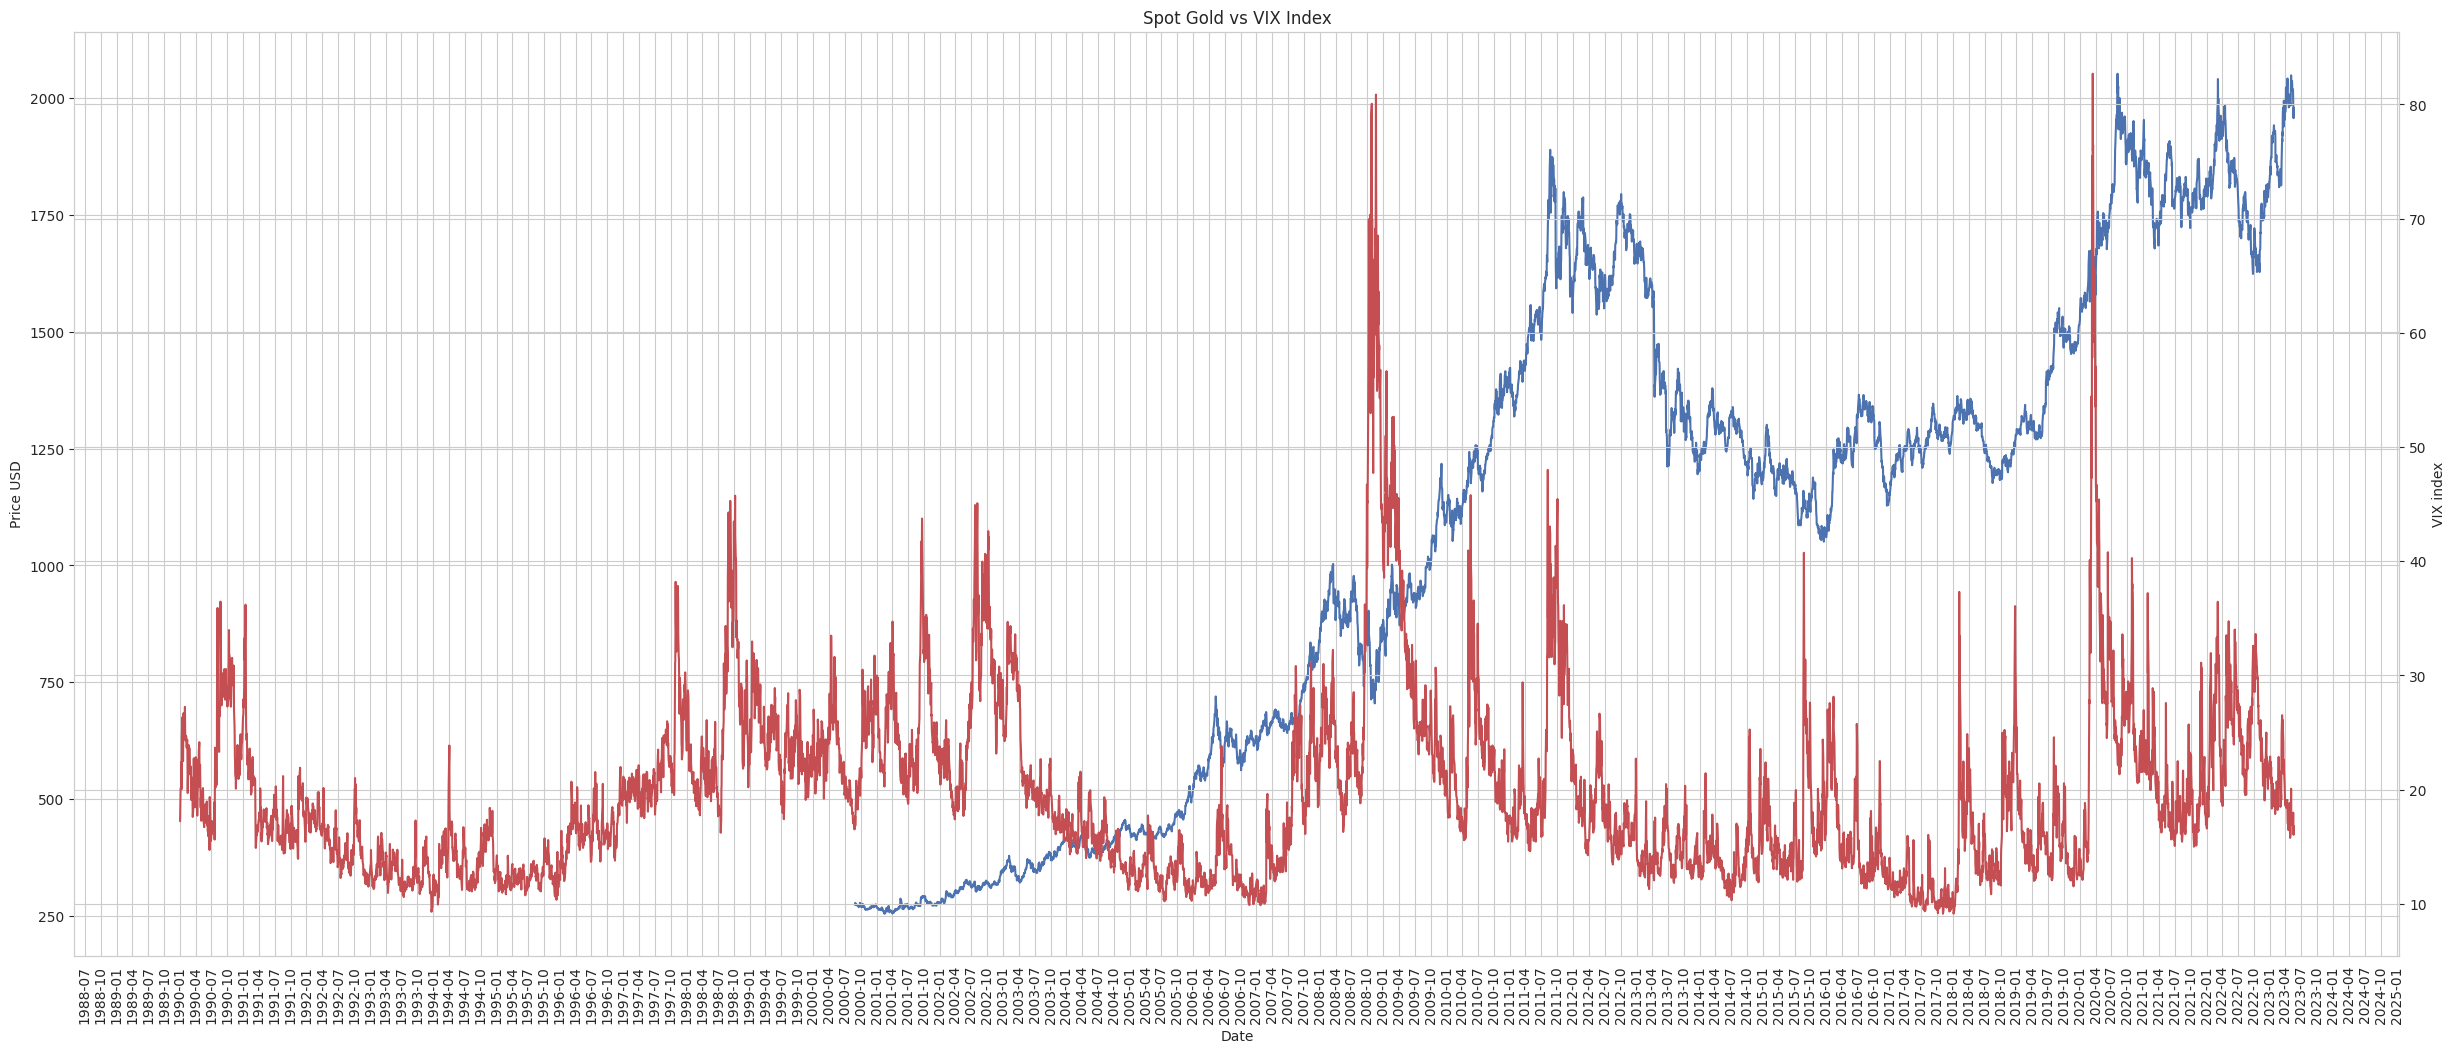

In [ ]:
sns.set_style('whitegrid')
sns.set_palette('deep')
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots()
fig.set_size_inches(30, 12)
plt.title('Spot Gold vs VIX Index')
sns.lineplot(x='Date', y='Close', data=gold_close_df.reset_index(), ax=ax, color='b')
ax.set_ylabel('Price USD')

ax2 = ax.twinx()

axlocator = matplotlib.dates.MonthLocator(bymonth=[1, 4, 7,10])
axformatter = matplotlib.dates.DateFormatter(fmt='%Y-%m')


ax.xaxis.set_major_locator(axlocator)
ax.xaxis.set_major_formatter(axformatter)
ax.tick_params(axis='x', which='major', labelrotation=90)

sns.lineplot(x='Date', y='CloseVIX',  data=VIX_CLOSE_df.reset_index(), ax=ax2, color='r')
ax2.set_ylabel('VIX index')

plt.show()

#### 9.1.4. USD Index


In [ ]:
USD_Index_df = yf.download('DX-Y.NYB', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
USD_I_CLOSE_df = pd.DataFrame(USD_Index_df.Close.rename('CloseUSDX'))

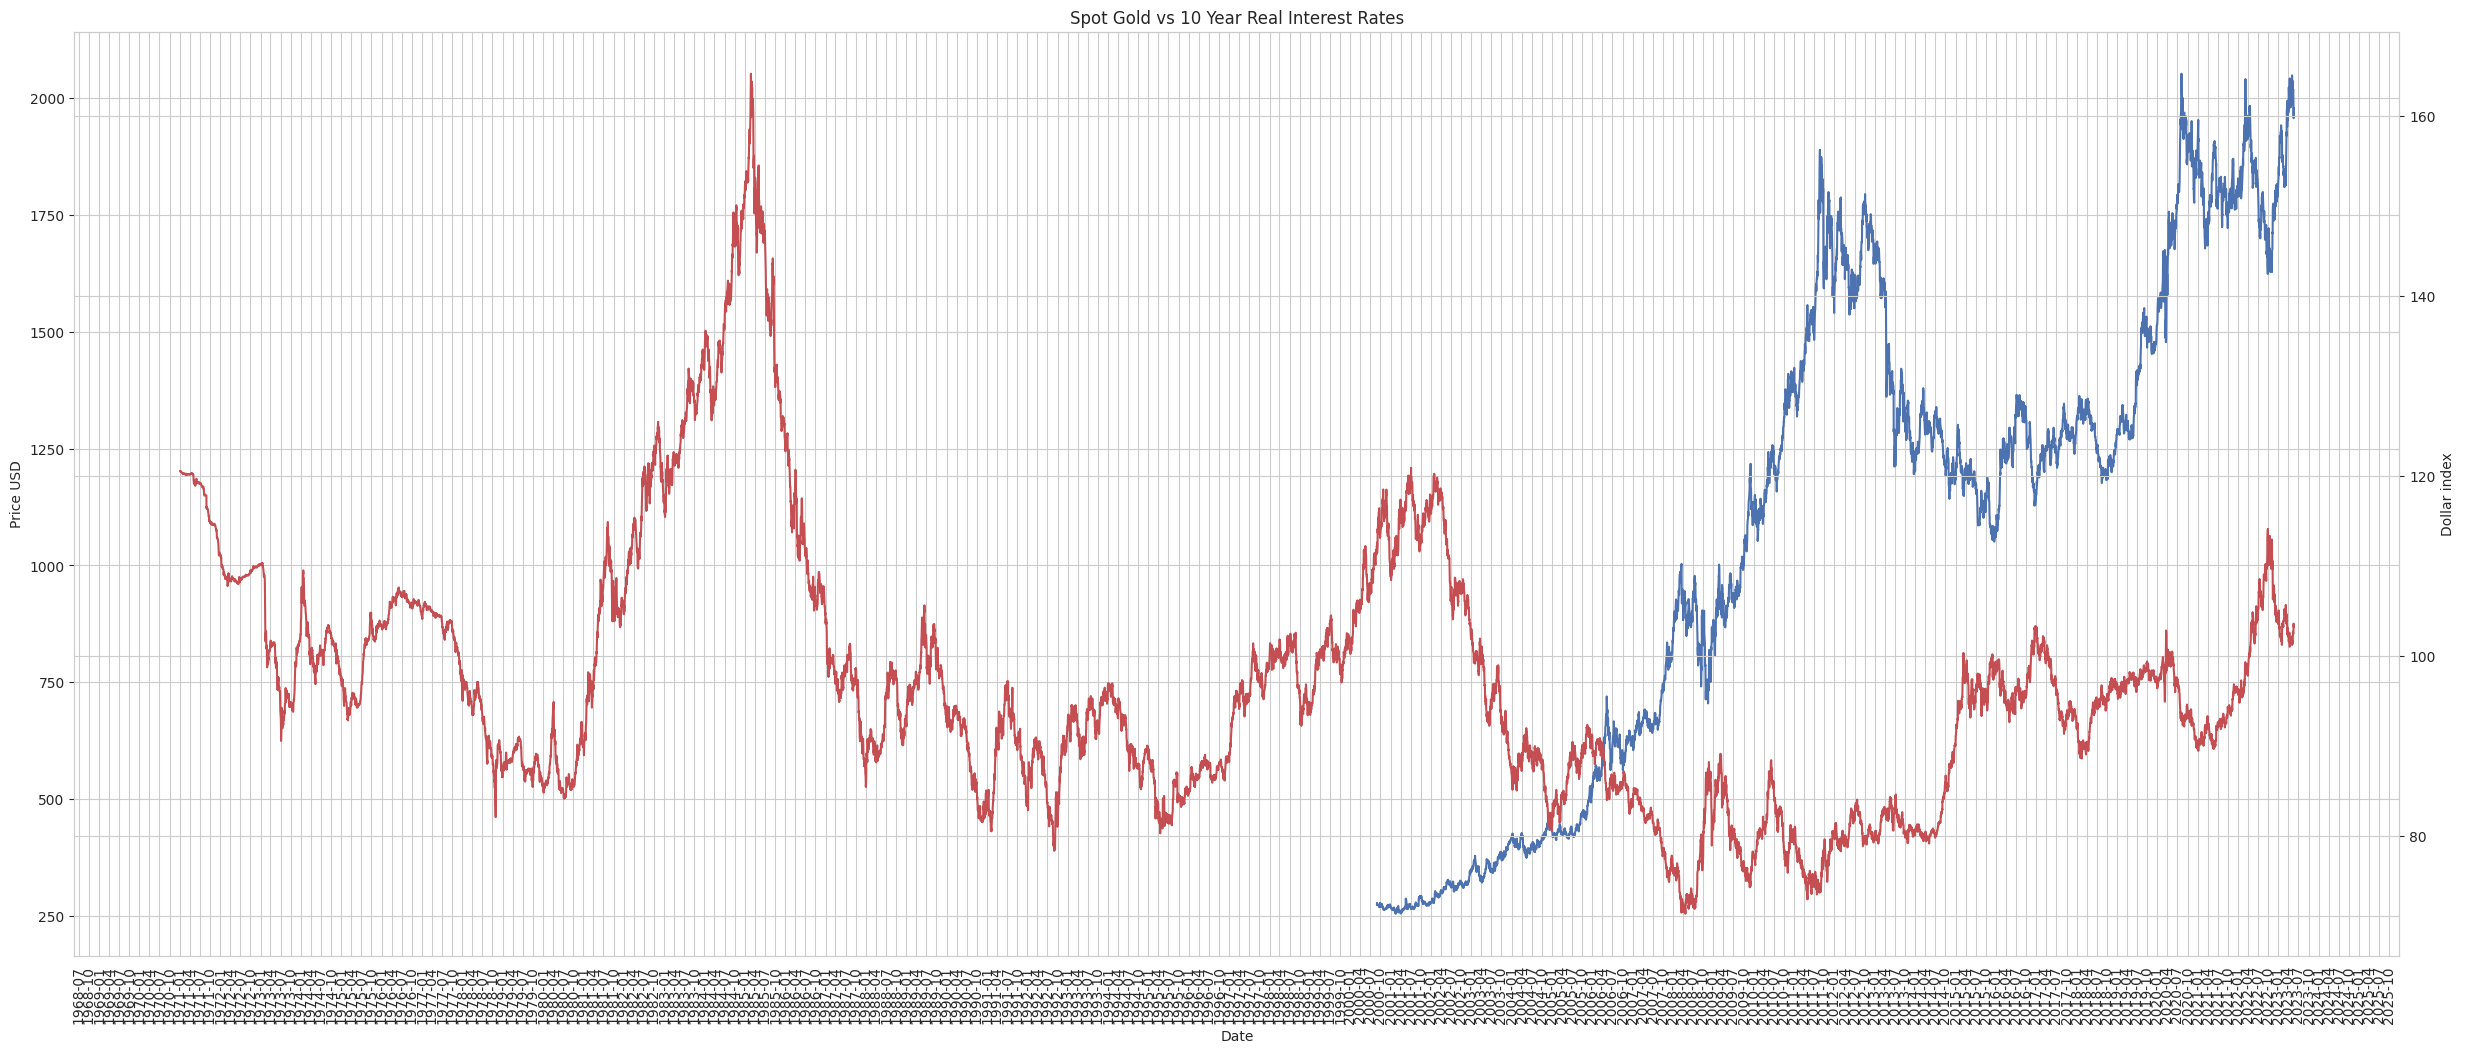

In [ ]:
sns.set_style('whitegrid')
sns.set_palette('deep')
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots()
fig.set_size_inches(30, 12)
plt.title('Spot Gold vs 10 Year Real Interest Rates')
sns.lineplot(x='Date', y='Close', data=gold_close_df.reset_index(), ax=ax, color='b')
ax.set_ylabel('Price USD')

ax2 = ax.twinx()

axlocator = matplotlib.dates.MonthLocator(bymonth=[1, 4, 7,10])
axformatter = matplotlib.dates.DateFormatter(fmt='%Y-%m')


ax.xaxis.set_major_locator(axlocator)
ax.xaxis.set_major_formatter(axformatter)
ax.tick_params(axis='x', which='major', labelrotation=90)

sns.lineplot(x='Date', y='CloseUSDX',  data=USD_I_CLOSE_df.reset_index(), ax=ax2, color='r')
ax2.set_ylabel('Dollar index')

plt.show()

### 9.2. Create a multivariate dataset

#### 9.2.1. Create a DataFrame with indices

In [ ]:
multivariate_df = CRUDE_GOLD_df[['CloseGOLD', 'CloseOIL']]

In [ ]:
multivariate_df.index.dtype, multivariate_df.index.name

(dtype('<M8[ns]'), 'Date')

In [ ]:
list_of_index_dfs = [USD_I_CLOSE_df, VIX_CLOSE_df, RIR_1Y_df, RIR_10Y_df]

In [ ]:
for df in list_of_index_dfs:
  if df.index.name != 'Date':
    df.rename_axis('Date', inplace=True)

In [ ]:
for el in list_of_index_dfs:
  multivariate_df=multivariate_df.merge(el, how='left', on='Date')

In [ ]:
multivariate_df.tail(15)

CloseGOLD   CloseOIL   CloseUSDX   CloseVIX  REAINTRATREARAT1YE  \
Date                                                                            
2023-05-01  1983.400024  75.660004  102.150002  16.080000                 NaN   
2023-05-02  2014.300049  71.660004  101.959999  17.780001                 NaN   
2023-05-03  2028.599976  68.599998  101.339996  18.340000                 NaN   
2023-05-04  2048.000000  68.559998  101.400002  20.090000                 NaN   
2023-05-05  2017.400024  71.339996  101.209999  17.190001                 NaN   
2023-05-08  2026.300049  73.160004  101.370003  16.980000                 NaN   
2023-05-09  2036.199951  73.709999  101.610001  17.709999                 NaN   
2023-05-10  2030.500000  72.559998  101.480003  16.940001                 NaN   
2023-05-11  2014.699951  70.870003  102.059998  16.930000                 NaN   
2023-05-12  2014.500000  70.040001  102.680000  17.030001                 NaN   
2023-05-15  2018.000000  71.110001  102.430000  17.120001                 NaN   
2023-05-16  1988.400024  70.860001  102.559998  17.990000                 NaN   
2023-05-17  1980.699951  72.830002  102.879997  16.870001                 NaN   
2023-05-18  1956.500000  71.860001  103.580002  16.049999                 NaN   
2023-05-19  1978.699951  71.550003  103.199997  16.809999                 NaN   

            REAINTRATREARAT10Y  
Date                            
2023-05-01                 NaN  
2023-05-02                 NaN  
2023-05-03                 NaN  
2023-05-04                 NaN  
2023-05-05                 NaN  
2023-05-08                 NaN  
2023-05-09                 NaN  
2023-05-10                 NaN  
2023-05-11                 NaN  
2023-05-12                 NaN  
2023-05-15                 NaN  
2023-05-16                 NaN  
2023-05-17                 NaN  
2023-05-18                 NaN  
2023-05-19                 NaN

In [ ]:
multivariate_df.REAINTRATREARAT1YE.fillna(method='bfill', inplace=True)
multivariate_df.REAINTRATREARAT10Y.fillna(method='bfill', inplace=True)

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

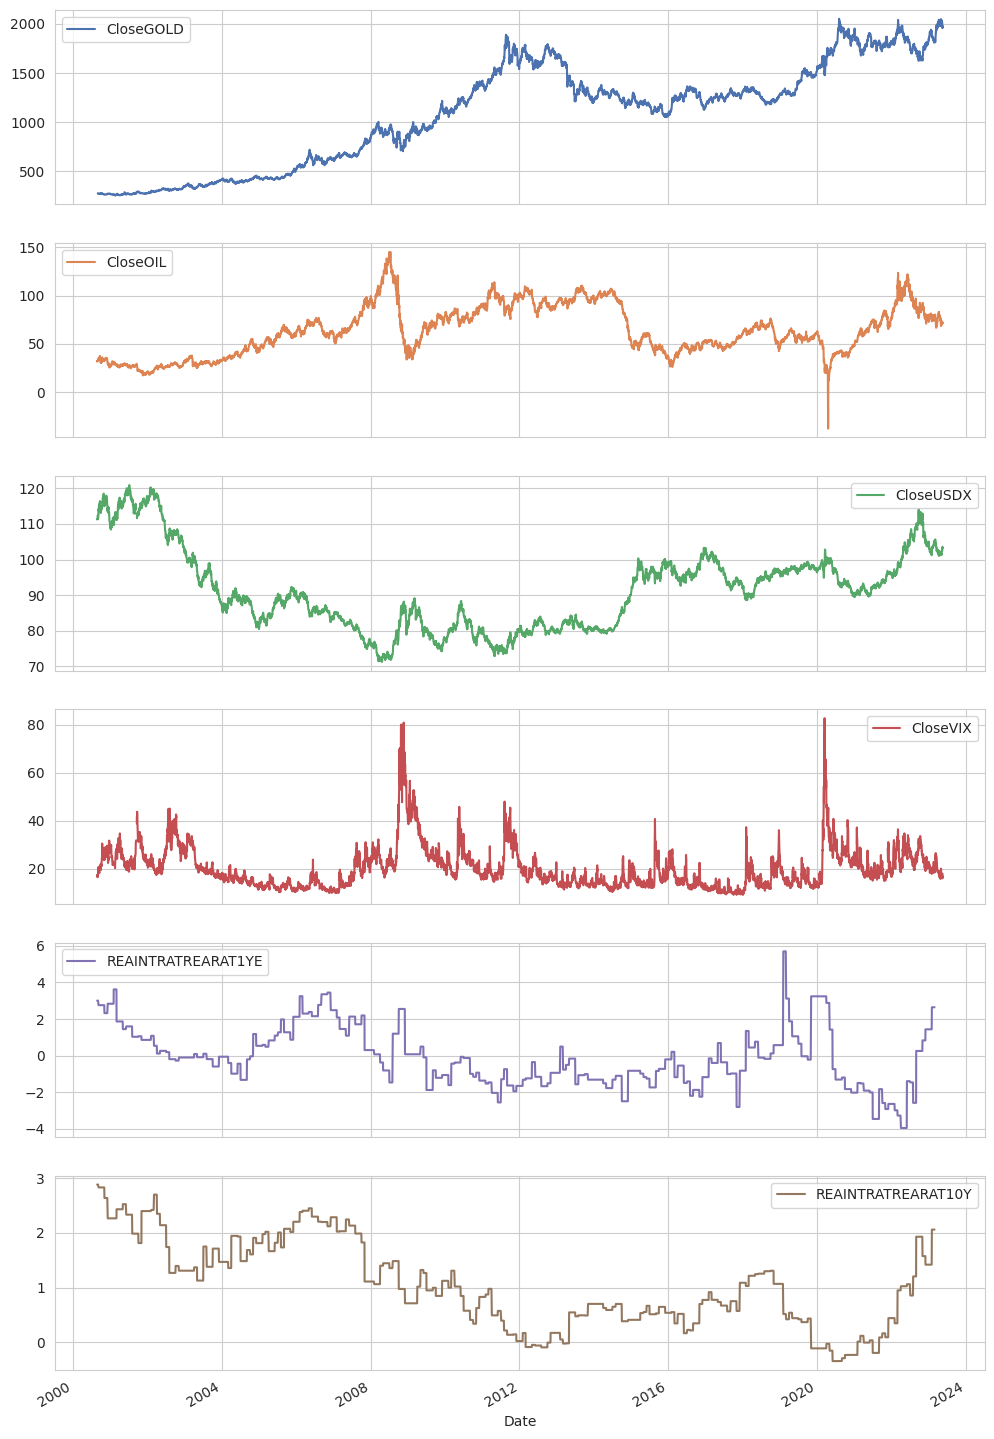

In [ ]:
multivariate_df.plot(subplots=True, sharey=False, sharex=True, figsize=(12,20))

In [ ]:
cycle_freq=60
corr = multivariate_df.rolling(cycle_freq).corr()['CloseGOLD']

In [ ]:
corr.unstack().columns[1:]

Index(['CloseOIL', 'CloseUSDX', 'CloseVIX', 'REAINTRATREARAT10Y',
       'REAINTRATREARAT1YE'],
      dtype='object')

Let's add US GDP growth data to our correlation graphs.
<a href='https://www.macrotrends.net/countries/USA/united-states/gdp-growth-rate'>U.S. GDP Growth Rate 1961-2023</a>

In [ ]:
# Load the data
gdp_gr_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bullion Predict data/US_GDP_growthrate.csv')

In [ ]:
gdp_gr_df

date  GDP Growth (%)  Annual Change
0   1961-12-31          2.3000            NaN
1   1962-12-31          6.1000           3.80
2   1963-12-31          4.4000          -1.70
3   1964-12-31          5.8000           1.40
4   1965-12-31          6.4000           0.60
..         ...             ...            ...
56  2017-12-31          2.2419           0.57
57  2018-12-31          2.9454           0.70
58  2019-12-31          2.2944          -0.65
59  2020-12-31         -2.7678          -5.06
60  2021-12-31          5.9455           8.71

[61 rows x 3 columns]

In [ ]:
gdp_gr_df.astype({'date': 'datetime64[ns]'})

date  GDP Growth (%)  Annual Change
0  1961-12-31          2.3000            NaN
1  1962-12-31          6.1000           3.80
2  1963-12-31          4.4000          -1.70
3  1964-12-31          5.8000           1.40
4  1965-12-31          6.4000           0.60
..        ...             ...            ...
56 2017-12-31          2.2419           0.57
57 2018-12-31          2.9454           0.70
58 2019-12-31          2.2944          -0.65
59 2020-12-31         -2.7678          -5.06
60 2021-12-31          5.9455           8.71

[61 rows x 3 columns]

In [ ]:
gdp_gr_df.date = pd.to_datetime(gdp_gr_df.date)


In [ ]:
gdp_gr_df.set_index('date')

GDP Growth (%)  Annual Change
date                                     
1961-12-31          2.3000            NaN
1962-12-31          6.1000           3.80
1963-12-31          4.4000          -1.70
1964-12-31          5.8000           1.40
1965-12-31          6.4000           0.60
...                    ...            ...
2017-12-31          2.2419           0.57
2018-12-31          2.9454           0.70
2019-12-31          2.2944          -0.65
2020-12-31         -2.7678          -5.06
2021-12-31          5.9455           8.71

[61 rows x 2 columns]

In [ ]:
multivariate_withGDP_df = pd.merge_asof(left=multivariate_df , right=gdp_gr_df.set_index('date'), left_index=True, right_index=True)

In [ ]:
multivariate_withGDP_df

CloseGOLD   CloseOIL   CloseUSDX   CloseVIX  REAINTRATREARAT1YE  \
Date                                                                            
2000-08-23          NaN  32.049999  111.419998  17.379999            3.003755   
2000-08-24          NaN  31.629999  111.230003  17.040001            3.003755   
2000-08-25          NaN  32.049999  111.349998  16.530001            3.003755   
2000-08-28          NaN  32.869999  111.459999  16.540001            3.003755   
2000-08-29          NaN  32.720001  112.199997  16.889999            3.003755   
...                 ...        ...         ...        ...                 ...   
2023-05-15  2018.000000  71.110001  102.430000  17.120001                 NaN   
2023-05-16  1988.400024  70.860001  102.559998  17.990000                 NaN   
2023-05-17  1980.699951  72.830002  102.879997  16.870001                 NaN   
2023-05-18  1956.500000  71.860001  103.580002  16.049999                 NaN   
2023-05-19  1978.699951  71.550003  103.199997  16.809999                 NaN   

            REAINTRATREARAT10Y  GDP Growth (%)  Annual Change  
Date                                                           
2000-08-23            2.885996          4.7945           0.31  
2000-08-24            2.885996          4.7945           0.31  
2000-08-25            2.885996          4.7945           0.31  
2000-08-28            2.885996          4.7945           0.31  
2000-08-29            2.885996          4.7945           0.31  
...                        ...             ...            ...  
2023-05-15                 NaN          5.9455           8.71  
2023-05-16                 NaN          5.9455           8.71  
2023-05-17                 NaN          5.9455           8.71  
2023-05-18                 NaN          5.9455           8.71  
2023-05-19                 NaN          5.9455           8.71  

[5712 rows x 8 columns]

#### 9.2.2. Plot the index to gold correlarion change with US GDP year-to-year change data

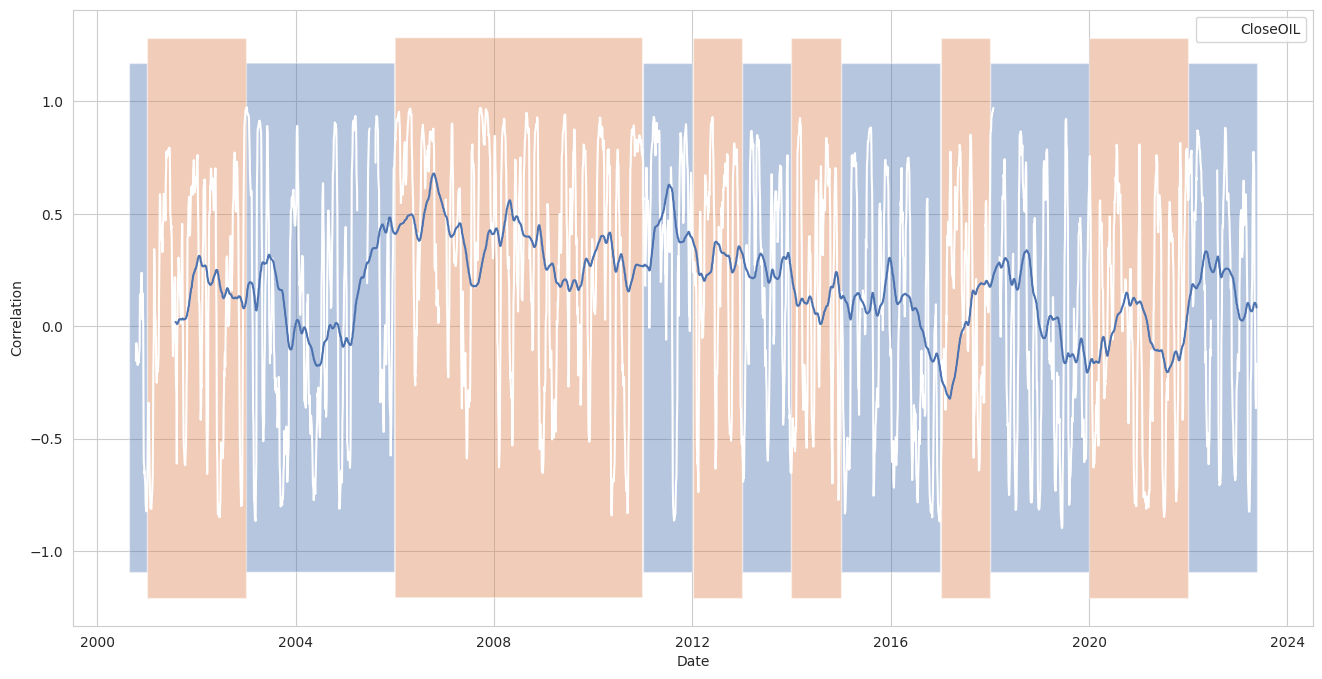

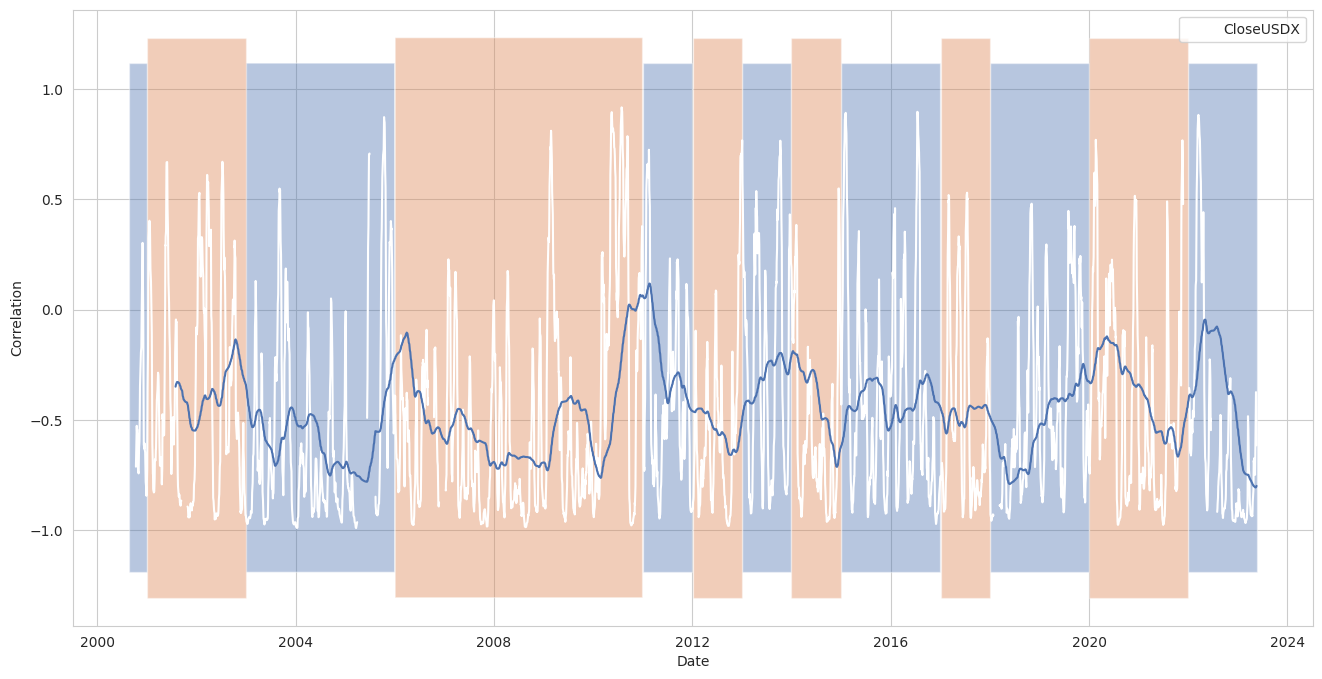

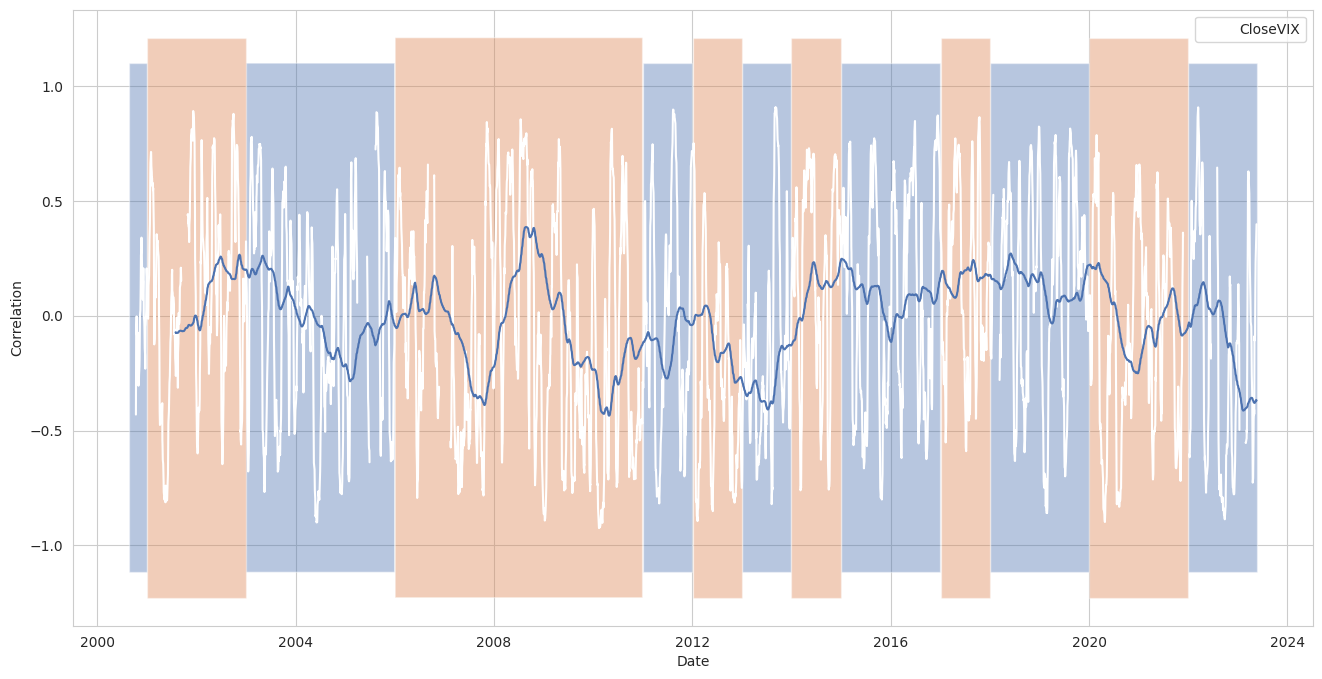

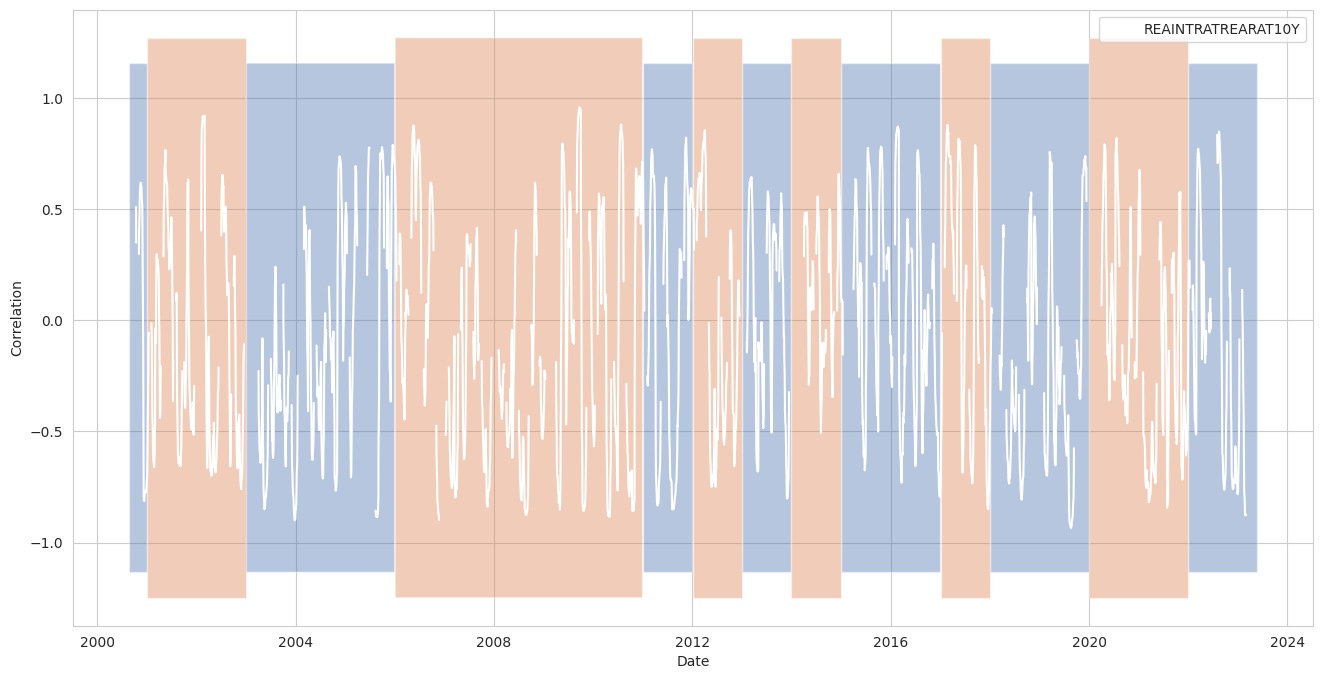

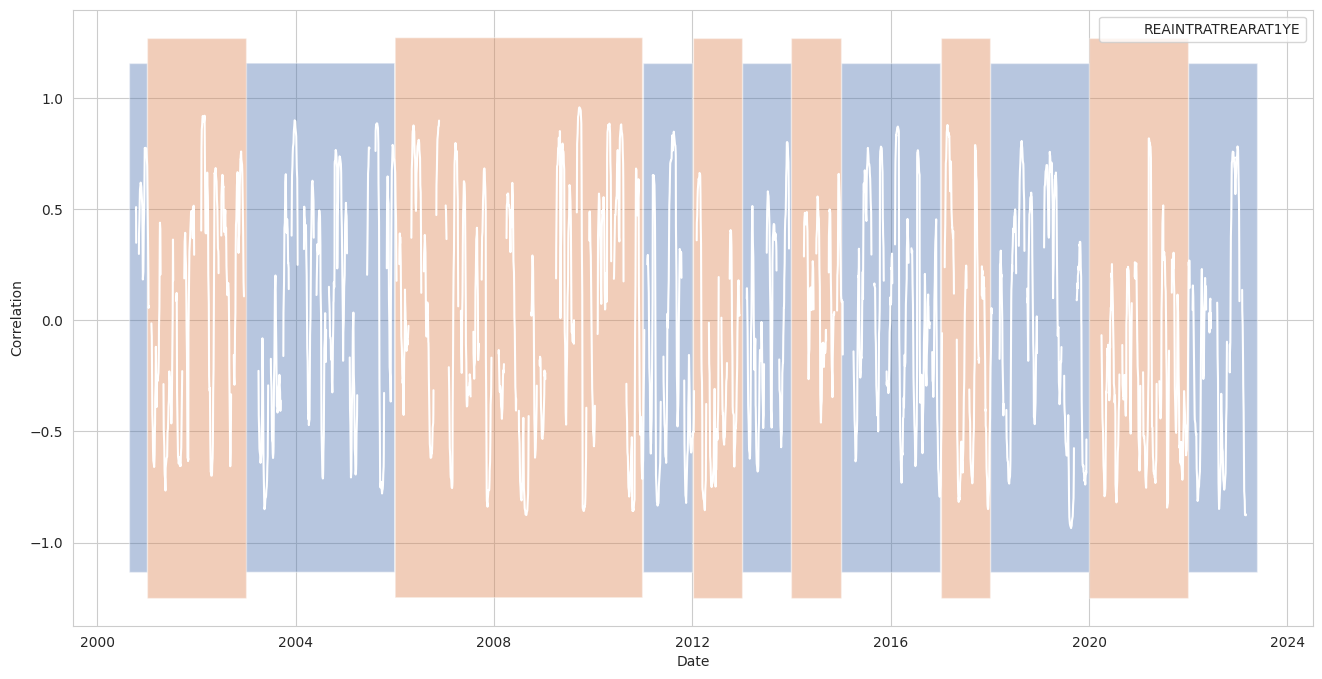

In [ ]:
# set the cycle frequency (in this example, monthly)
cycle_freq = 30

# calculate the rolling correlation between the dependent column and each predictor column over the cycle
corr = multivariate_df.rolling(cycle_freq).corr()['CloseGOLD']

# plot the results


for col in corr.unstack().columns[1:6]:
  fig, ax = plt.subplots(figsize=( 16, 8))
  ax.plot(corr.unstack()[col], label=col, color='white')
  ax.plot(corr.unstack()[col].fillna(method='ffill').rolling(200).mean())
  ax.set_xlabel('Date')
  ax.set_ylabel('Correlation')
  ax.legend()

  ax.fill_between(x=multivariate_withGDP_df.index, y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], alpha=0.2, color='none')
  ax.fill_between(x=multivariate_withGDP_df.index, y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], where=multivariate_withGDP_df['Annual Change'] > 0, alpha=0.4)
  ax.fill_between(x=multivariate_withGDP_df.index, y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], where=multivariate_withGDP_df['Annual Change'] < 0, alpha=0.4)

  # display the plot
  plt.show()





We can see that rolling mean for 30 days of index correlation GoldClose indicates positive correlation with OilClose and negative correlation with USDX. We will create two datasets: one only containing Gold, Oil and USDX and other with additional indices(VIX, and real interest rates).

Let's see which dataset will prove better for predicting Gold value.

### 9.3. Create

In [ ]:
WINDOW_SIZE, HORIZON

(7, 1)

In [ ]:
# Make a copy of the dataset
dataset_ONE = multivariate_withGDP_df[['CloseGOLD', 'CloseOIL', 'CloseUSDX']].dropna()

In [ ]:
# Add windowed columns
for column in dataset_ONE.columns:
  for i in range(WINDOW_SIZE):
    dataset_ONE[f'{column}+{i+1}'] = dataset_ONE[column].shift(periods=i+1)

In [ ]:
dataset_ONE

CloseGOLD   CloseOIL   CloseUSDX  CloseGOLD+1  CloseGOLD+2  \
Date                                                                       
2000-08-30   273.899994  33.400002  112.139999          NaN          NaN   
2000-08-31   278.299988  33.099998  112.599998   273.899994          NaN   
2000-09-01   277.000000  33.380001  111.419998   278.299988   273.899994   
2000-09-05   275.799988  33.799999  112.410004   277.000000   278.299988   
2000-09-06   274.200012  34.950001  114.120003   275.799988   277.000000   
...                 ...        ...         ...          ...          ...   
2023-05-15  2018.000000  71.110001  102.430000  2014.500000  2014.699951   
2023-05-16  1988.400024  70.860001  102.559998  2018.000000  2014.500000   
2023-05-17  1980.699951  72.830002  102.879997  1988.400024  2018.000000   
2023-05-18  1956.500000  71.860001  103.580002  1980.699951  1988.400024   
2023-05-19  1978.699951  71.550003  103.199997  1956.500000  1980.699951   

            CloseGOLD+3  CloseGOLD+4  CloseGOLD+5  CloseGOLD+6  CloseGOLD+7  \
Date                                                                          
2000-08-30          NaN          NaN          NaN          NaN          NaN   
2000-08-31          NaN          NaN          NaN          NaN          NaN   
2000-09-01          NaN          NaN          NaN          NaN          NaN   
2000-09-05   273.899994          NaN          NaN          NaN          NaN   
2000-09-06   278.299988   273.899994          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2023-05-15  2030.500000  2036.199951  2026.300049  2017.400024  2048.000000   
2023-05-16  2014.699951  2030.500000  2036.199951  2026.300049  2017.400024   
2023-05-17  2014.500000  2014.699951  2030.500000  2036.199951  2026.300049   
2023-05-18  2018.000000  2014.500000  2014.699951  2030.500000  2036.199951   
2023-05-19  1988.400024  2018.000000  2014.500000  2014.699951  2030.500000   

            ...  CloseOIL+5  CloseOIL+6  CloseOIL+7  CloseUSDX+1  CloseUSDX+2  \
Date        ...                                                                 
2000-08-30  ...         NaN         NaN         NaN          NaN          NaN   
2000-08-31  ...         NaN         NaN         NaN   112.139999          NaN   
2000-09-01  ...         NaN         NaN         NaN   112.599998   112.139999   
2000-09-05  ...         NaN         NaN         NaN   111.419998   112.599998   
2000-09-06  ...         NaN         NaN         NaN   112.410004   111.419998   
...         ...         ...         ...         ...          ...          ...   
2023-05-15  ...   73.160004   71.339996   68.559998   102.680000   102.059998   
2023-05-16  ...   73.709999   73.160004   71.339996   102.430000   102.680000   
2023-05-17  ...   72.559998   73.709999   73.160004   102.559998   102.430000   
2023-05-18  ...   70.870003   72.559998   73.709999   102.879997   102.559998   
2023-05-19  ...   70.040001   70.870003   72.559998   103.580002   102.879997   

            CloseUSDX+3  CloseUSDX+4  CloseUSDX+5  CloseUSDX+6  CloseUSDX+7  
Date                                                                         
2000-08-30          NaN          NaN          NaN          NaN          NaN  
2000-08-31          NaN          NaN          NaN          NaN          NaN  
2000-09-01          NaN          NaN          NaN          NaN          NaN  
2000-09-05   112.139999          NaN          NaN          NaN          NaN  
2000-09-06   112.599998   112.139999          NaN          NaN          NaN  
...                 ...          ...          ...          ...          ...  
2023-05-15   101.480003   101.610001   101.370003   101.209999   101.400002  
2023-05-16   102.059998   101.480003   101.610001   101.370003   101.209999  
2023-05-17   102.680000   102.059998   101.480003   101.610001   101.370003  
2023-05-18   102.430000   102.680000   102.059998   101.480003   101.610001  
2023-05

In [ ]:
# Create features and target dataset
dataset_ONE_X = dataset_ONE.dropna().drop(['CloseGOLD','CloseOIL', 'CloseUSDX'], axis=1).astype(np.float32)
dataset_ONE_y = dataset_ONE.dropna()['CloseGOLD'].astype(np.float32)

In [ ]:
# Check the datasets for missing values
for col in dataset_ONE_X.columns:
  print(sum(dataset_ONE_X[col].isna()))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
len(dataset_ONE_X.columns)

21

In [ ]:
# Crete tensor and reshape
dataset_ONE_X_tensor = dataset_ONE_X.values.reshape(-1, 3, 7)

In [ ]:
dataset_ONE_X_tensor[1], dataset_ONE_X_tensor.shape

(array([[273.1 , 273.3 , 274.  , 274.2 , 275.8 , 277.  , 278.3 ],
        [ 35.1 ,  33.7 ,  35.33,  34.95,  33.8 ,  33.38,  33.1 ],
        [115.37, 114.34, 113.65, 114.12, 112.41, 111.42, 112.6 ]],
       dtype=float32),
 (5691, 3, 7))

In [ ]:
dataset_ONE_y_tensor = dataset_ONE_y.values

In [ ]:
dataset_ONE_y_tensor.shape

(5691,)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split the data
X_ONE_train, X_ONE_test, y_ONE_train, y_ONE_test = train_test_split(dataset_ONE_X_tensor, dataset_ONE_y_tensor, shuffle=False, test_size=.15)

In [ ]:
len(X_ONE_train), len(X_ONE_test), len(y_ONE_train), len(y_ONE_test)

(4837, 854, 4837, 854)

In [ ]:
X_ONE_train.shape, X_ONE_test.shape, y_ONE_train.shape, y_ONE_test.shape

((4837, 3, 7), (854, 3, 7), (4837,), (854,))

## 10. Model 6: Dense model trained on multivariate dataset

### 10.1. Create two types of reshaping the dataset of the shape (n, 3, 7)

#### 10.1.1. "Concatenate" 3 indices side-by-side
So the first possibility is to reshape the dataset to preserve the order of each window.

In [ ]:
X_ONE_train[0,:,:]

array([[273.3 , 274.  , 274.2 , 275.8 , 277.  , 278.3 , 273.9 ],
       [ 33.7 ,  35.33,  34.95,  33.8 ,  33.38,  33.1 ,  33.4 ],
       [114.34, 113.65, 114.12, 112.41, 111.42, 112.6 , 112.14]],
      dtype=float32)

In [ ]:
X_ONE_train[0,:,:].reshape(-1)

array([273.3 , 274.  , 274.2 , 275.8 , 277.  , 278.3 , 273.9 ,  33.7 ,
        35.33,  34.95,  33.8 ,  33.38,  33.1 ,  33.4 , 114.34, 113.65,
       114.12, 112.41, 111.42, 112.6 , 112.14], dtype=float32)

In [ ]:
X_ONE_train.reshape(-1, 21).shape

(4837, 21)

In [ ]:
X_ONE_train.reshape(-1, 21)[0, :] == X_ONE_train[0,:,:].reshape(-1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
X_ONE_train_flat01 = X_ONE_train.reshape(-1, 21)

In [ ]:
X_ONE_test_flat01 = X_ONE_test.reshape(-1, 21)

#### 10.1.2. 'Concatenate" 3 timesteps side-by-side
The second, and more appealing, possibility is to preserve the timestep order. This way we take into account parallel changes of the three of the chosen indices...

In [ ]:
X_ONE_train[0, :, :].T.reshape(7, 3).reshape(-1)

array([273.3 ,  33.7 , 114.34, 274.  ,  35.33, 113.65, 274.2 ,  34.95,
       114.12, 275.8 ,  33.8 , 112.41, 277.  ,  33.38, 111.42, 278.3 ,
        33.1 , 112.6 , 273.9 ,  33.4 , 112.14], dtype=float32)

In [ ]:
np.transpose(X_ONE_train, axes=(0, 2, 1)).reshape(-1, 21).shape

(4837, 21)

In [ ]:
np.transpose(X_ONE_train, axes=(0, 2, 1)).reshape(-1, 21)[0] == X_ONE_train[0, :, :].T.reshape(7, 3).reshape(-1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
X_ONE_train_flat02 = np.transpose(X_ONE_train, axes=(0, 2, 1)).reshape(-1, 21)

In [ ]:
X_ONE_test_flat02 = np.transpose(X_ONE_test, axes=(0, 2, 1)).reshape(-1, 21)

### 10.2. Build the model and train it on flat01 dataset

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Construct the model
model_6a = Sequential(
    [
        Input(shape=(21,)),
        Dense(21, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(HORIZON, activation='linear')
    ], name='model_6a_dense'
)

# Compile the model
model_6a.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=['mse', 'mape']
)

# Fit the model
history_6a = model_6a.fit(x=X_ONE_train_flat01,
              y=y_ONE_train,
              epochs=100,
              verbose=1,
              batch_size=32,
              validation_data=(X_ONE_test_flat01, y_ONE_test),
              callbacks=[create_model_checkpoint(model_name=model_6a.name)])

Epoch 1/100
152/152 [==============================] - 3s 9ms/step - loss: 57.5950 - mse: 29892.8965 - mape: 5.8356 - val_loss: 23.0241 - val_mse: 929.1031 - val_mape: 1.2826
Epoch 2/100
152/152 [==============================] - 1s 3ms/step - loss: 12.4446 - mse: 322.2404 - mape: 1.3276 - val_loss: 24.2781 - val_mse: 970.0920 - val_mape: 1.3561
Epoch 3/100
152/152 [==============================] - 1s 3ms/step - loss: 13.0593 - mse: 342.1617 - mape: 1.3949 - val_loss: 23.2375 - val_mse: 856.8293 - val_mape: 1.2895
Epoch 4/100
152/152 [==============================] - 1s 7ms/step - loss: 11.4828 - mse: 275.6181 - mape: 1.2309 - val_loss: 22.2917 - val_mse: 796.7589 - val_mape: 1.2380
Epoch 5/100
152/152 [==============================] - 1s 7ms/step - loss: 13.9957 - mse: 389.3202 - mape: 1.4830 - val_loss: 17.1147 - val_mse: 554.6574 - val_mape: 0.9546
Epoch 6/100
152/152 [==============================] - 1s 3ms/step - loss: 10.5530 - mse: 238.0896 - mape: 1.1373 - val_loss: 57.7328

### 10.3. Evaluate the model trainded on flat01 dataset

In [ ]:
# First evaluation
model_6a_results = model_6a.evaluate(X_ONE_test_flat01, y_ONE_test)

27/27 [==============================] - 0s 2ms/step - loss: 21.2205 - mse: 714.8867 - mape: 1.1817


In [ ]:
naive_result

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

In [ ]:
# Load best performing model
model_6a_best = tf.keras.models.load_model('/content/model_experiments/model_6a_dense')

In [ ]:
model_6a_best_results = model_6a_best.evaluate(X_ONE_test_flat01, y_ONE_test)

27/27 [==============================] - 0s 2ms/step - loss: 14.0711 - mse: 397.4232 - mape: 0.7829


In [ ]:
model_6a_best_results

{'mae': 14.071053,
 'mse': 397.4232,
 'rmse': 19.935474,
 'mape': 0.7829429,
 'smape': 0.781641,
 'mase': 1.0075387}

In [ ]:
# Make predictions
model_6a_best_preds = make_preds(model_6a_best, X_ONE_test_flat01)

len(model_6a_best_preds), model_6a_best_preds[:10], len(y_ONE_test), y_ONE_test[:10]

27/27 [==============================] - 0s 1ms/step


(854,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1517.1779, 1523.6049, 1528.0485, 1549.0947, 1564.4144, 1572.3599,
        1560.5083, 1557.5942, 1561.8705, 1551.6107], dtype=float32)>,
 854,
 array([1519.5, 1524.5, 1549.2, 1566.2, 1571.8, 1557.4, 1551.7, 1557.5,
        1548.4, 1542.4], dtype=float32))

In [ ]:
# Produce metrics for model_6a_best
model_6a_best_results = produce_metrics(tf.cast(y_ONE_test, dtype=tf.float32), model_6a_best_preds)

In [ ]:
model_6a_best_results

{'mae': 14.071053,
 'mse': 397.4232,
 'rmse': 19.935474,
 'mape': 0.7829429,
 'smape': 0.781641,
 'mase': 1.0075387}

In [ ]:
model_1_1_best_results

{'mae': 237.65211,
 'mse': 92826.016,
 'rmse': 304.6736,
 'mape': 14.81863,
 'smape': 14.539687,
 'mase': 19.398224}

In [ ]:
model_2_1_best_results

{'mae': 236.06375,
 'mse': 91610.24,
 'rmse': 302.67184,
 'mape': 14.703503,
 'smape': 14.413929,
 'mase': 19.229536}

In [ ]:
naive_result

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

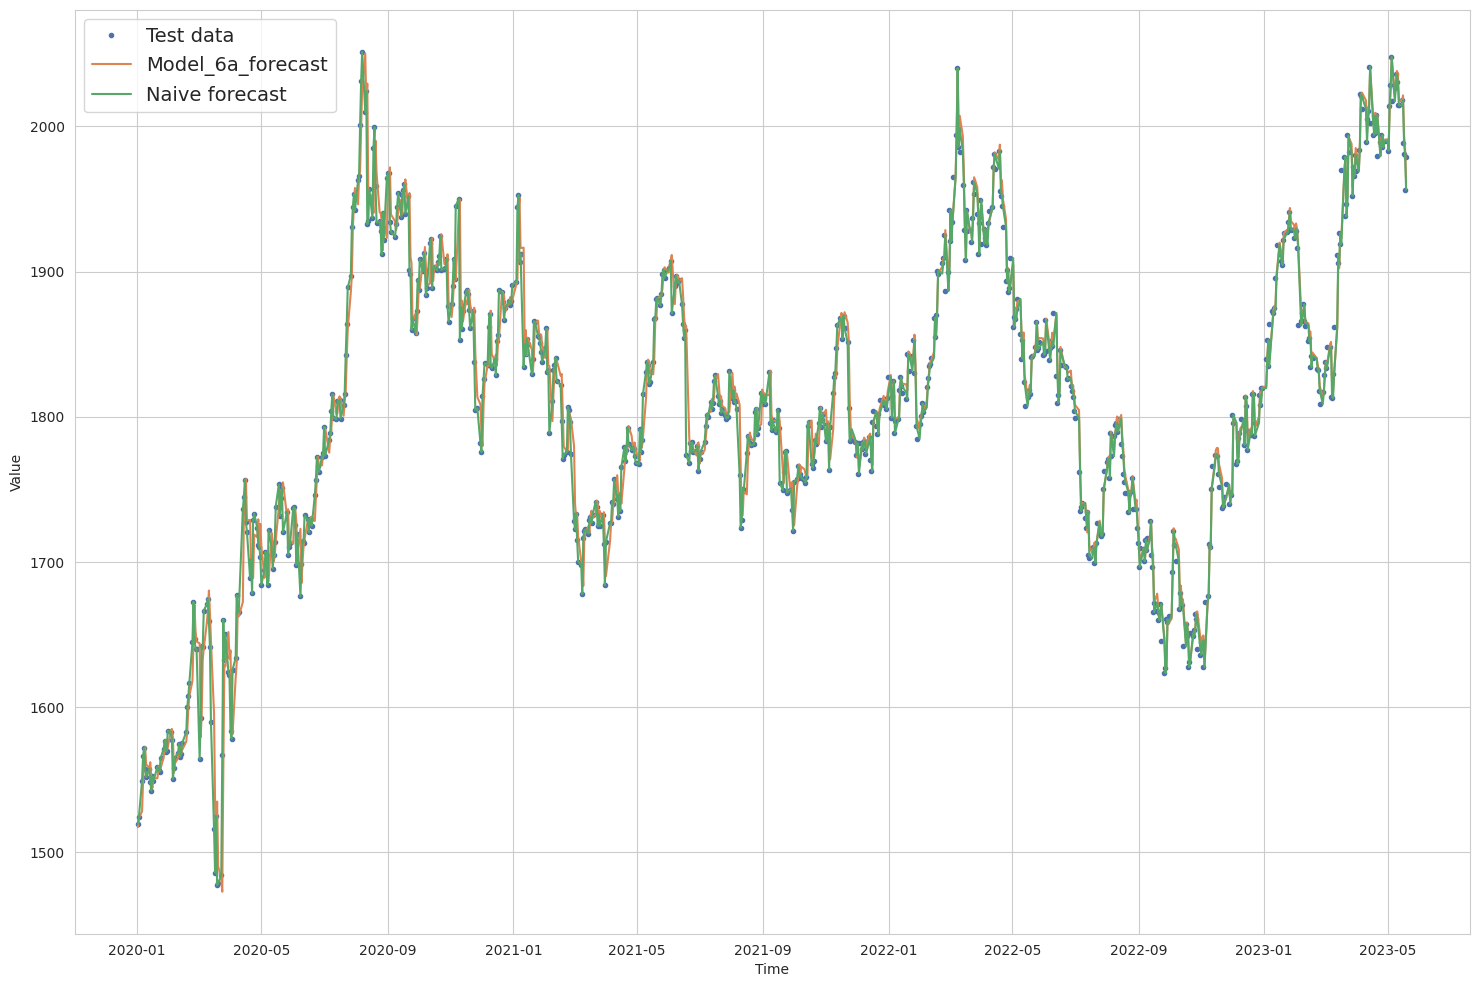

In [ ]:
# Visalise the differences
plt.figure(figsize=(18, 12))
plot_time_series(timesteps=X_test[-len(y_ONE_test):], values=tf.squeeze(y_ONE_test), format='.', label='Test data')
plot_time_series(timesteps=X_test[-len(y_ONE_test):], values=model_6a_best_preds, format='-', label='Model_6a_forecast')
plot_time_series(timesteps=X_test[-len(y_ONE_test):], values=naive_forecast[-len(y_ONE_test):], format='-', label='Naive forecast')

### 10.4. Build the model for flat02 dataset

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Construct the model
model_6b = Sequential(
    [
        Input(shape=(21,)),
        Dense(21, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(HORIZON, activation='linear')
    ], name='model_6b_dense'
)

# Compile the model
model_6b.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=['mse', 'mape']
)

# Fit the model
history_6a = model_6a.fit(x=X_ONE_train_flat02,
              y=y_ONE_train,
              epochs=100,
              verbose=1,
              batch_size=32,
              validation_data=(X_ONE_test_flat02, y_ONE_test),
              callbacks=[create_model_checkpoint(model_name=model_6b.name)])

Epoch 1/100
152/152 [==============================] - 1s 8ms/step - loss: 16.3549 - mse: 647.2184 - mape: 1.6934 - val_loss: 25.8917 - val_mse: 1081.6477 - val_mape: 1.4449
Epoch 2/100
152/152 [==============================] - 1s 4ms/step - loss: 12.1242 - mse: 308.8958 - mape: 1.2681 - val_loss: 29.8882 - val_mse: 1292.5686 - val_mape: 1.6527
Epoch 3/100
152/152 [==============================] - 1s 8ms/step - loss: 12.5109 - mse: 323.2984 - mape: 1.2946 - val_loss: 20.2772 - val_mse: 725.5707 - val_mape: 1.1317
Epoch 4/100
152/152 [==============================] - 1s 3ms/step - loss: 11.0861 - mse: 265.6926 - mape: 1.1616 - val_loss: 23.2086 - val_mse: 854.8273 - val_mape: 1.2856
Epoch 5/100
152/152 [==============================] - 1s 7ms/step - loss: 11.2978 - mse: 275.0745 - mape: 1.1749 - val_loss: 19.3282 - val_mse: 662.3929 - val_mape: 1.0783
Epoch 6/100
152/152 [==============================] - 1s 7ms/step - loss: 11.6708 - mse: 287.4221 - mape: 1.2242 - val_loss: 17.5031

### 10.5. Evaluate the model

In [ ]:
# Load best performing model
model_6b_best = tf.keras.models.load_model('/content/model_experiments/model_6b_dense')

In [ ]:
model_6b_best_results = model_6b_best.evaluate(X_ONE_test_flat02, y_ONE_test)

27/27 [==============================] - 0s 2ms/step - loss: 14.9300 - mse: 412.4258 - mape: 0.8294


In [ ]:
model_6b_best_results

[14.930002212524414, 412.4258117675781, 0.8294370174407959]

In [ ]:
# Make predictions
model_6b_best_preds = make_preds(model_6b_best, X_ONE_test_flat02)

len(model_6b_best_preds), model_6b_best_preds[:10], len(y_ONE_test), y_ONE_test[:10]

27/27 [==============================] - 0s 1ms/step


(854,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1514.5732, 1516.7963, 1521.084 , 1540.7136, 1562.1204, 1570.1469,
        1558.5751, 1550.2975, 1552.0979, 1547.9796], dtype=float32)>,
 854,
 array([1519.5, 1524.5, 1549.2, 1566.2, 1571.8, 1557.4, 1551.7, 1557.5,
        1548.4, 1542.4], dtype=float32))

In [ ]:
# Produce metrics for model_6a_best
model_6b_best_results = produce_metrics(tf.cast(y_ONE_test, dtype=tf.float32), model_6b_best_preds)

In [ ]:
model_6b_best_results

{'mae': 14.930001,
 'mse': 412.42578,
 'rmse': 20.308268,
 'mape': 0.829437,
 'smape': 0.8298577,
 'mase': 1.0690426}

In [ ]:
model_6a_best_results

{'mae': 14.071053,
 'mse': 397.4232,
 'rmse': 19.935474,
 'mape': 0.7829429,
 'smape': 0.781641,
 'mase': 1.0075387}

In [ ]:
model_1_1_best_results

{'mae': 237.65211,
 'mse': 92826.016,
 'rmse': 304.6736,
 'mape': 14.81863,
 'smape': 14.539687,
 'mase': 19.398224}

In [ ]:
model_2_1_best_results

{'mae': 236.06375,
 'mse': 91610.24,
 'rmse': 302.67184,
 'mape': 14.703503,
 'smape': 14.413929,
 'mase': 19.229536}

In [ ]:
naive_result

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

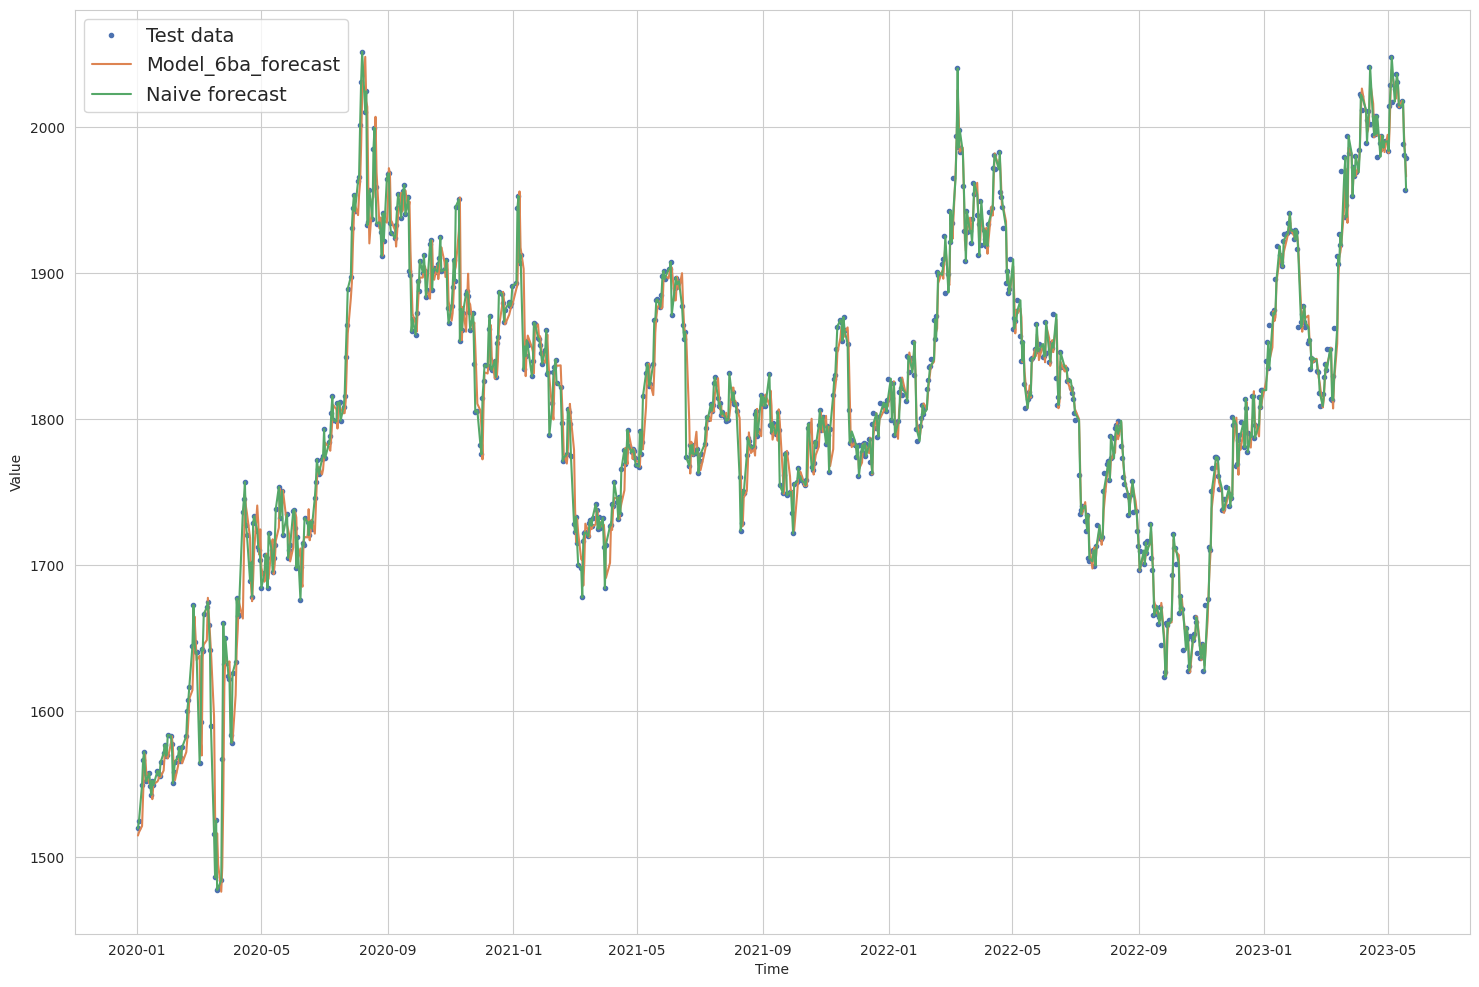

In [ ]:
# Visalise the differences
plt.figure(figsize=(18, 12))
plot_time_series(timesteps=X_test[-len(y_ONE_test):], values=tf.squeeze(y_ONE_test), format='.', label='Test data')
plot_time_series(timesteps=X_test[-len(y_ONE_test):], values=model_6b_best_preds, format='-', label='Model_6ba_forecast')
plot_time_series(timesteps=X_test[-len(y_ONE_test):], values=naive_forecast[-len(y_ONE_test):], format='-', label='Naive forecast')

## Intermission: check the results

In [ ]:
best_results_df = pd.DataFrame(naive_result, index=['naive_results']).transpose()

In [ ]:
globalsy = globals().copy()

In [ ]:
for key in globalsy.keys():
  if 'best_result' in key:
    if 'df' not in key:
      best_results_df = pd.concat([best_results_df, pd.DataFrame(globals()[key], index=[key]).transpose()], axis=1)

In [ ]:
best_results_df

naive_results  model_1_1_best_results  model_2_1_best_results  \
mae        12.263685              237.652115              236.063751   
mse       309.243055            92826.015625            91610.242188   
rmse       17.585308              304.673615              302.671844   
mape        0.711187               14.818630               14.703503   
smape       0.711108               14.539687               14.413929   
mase        1.000303               19.398224               19.229536   

       model_3_1_best_results  model_4_1_best_results  model_5_best_results  \
mae                 24.654978              237.644836            237.684799   
mse               1218.987305            92826.148438          92850.718750   
rmse                34.913998              304.673828            304.714142   
mape                 1.435264               14.818308             14.822463   
smape                1.432760               14.539459             14.539842   
mase                 2.010857               19.397629             19.400890   

       model_6a_best_results  model_6b_best_results  
mae                14.071053              14.930001  
mse               397.423187             412.425781  
rmse               19.935474              20.308268  
mape                0.782943               0.829437  
smape               0.781641               0.829858  
mase                1.007539               1.069043